# Carbon monoxide ($CO$)

Carbon monoxide ($CO$) does not poison plants since it is rapidly oxidised to form carbon dioxide $CO_2$ which is used for photosynthesis. Plants metabolise $CO$ to form $CO_2$ or $CH_4$.

Things to check:
- Correlation of rainy days+3 between drought & irrigated
- Correlation with Hamsin?
- Why can't I see the soil data?

In [1]:
import pandas as pd
import numpy as np
import glob
from scipy import stats

from plotnine import *

In [2]:
project_path = './'

data_path  = '../data/'
input_fn = 'all_data.csv'

graphs_path  = '../graphs/'

# Colours
cbPalette = ['#000000', '#0072B2', '#E69F00', '#CC00CC', '#009E73', '#D55E00', '#CC79A7', '#FF3300', '#F0E442', '#56B4E9']
bwPalette = ['#ffffff', '#b0b0b0']

In [3]:
def load_data(fn, silent=False):
    if (not silent): print('- All data')
    temp = pd.read_csv(fn, index_col=None)
    temp.rename({'date_mid_hour': 'timestamp'}, axis=1, inplace=True)
    temp['timestamp'] = pd.to_datetime(temp['timestamp'], format='%Y-%m-%d %H:%M:%S')
    if (not silent): print("    ", '100.0 %\t', fn.split('/')[-1])
    return(temp)

def bin_variable(data_column, steps):
    exponents = int(np.round(np.log10(steps)))
    # Determine minimum
    minimum = int(np.floor(min(data_column)))
    minimum = np.round(minimum, -exponents)-steps
    #print(minimum, steps, np.round(minimum, -exponents)-steps)
    # Determine max and round
    maximum = int(np.ceil(max(data_column)) + 2*steps)
    maximum = np.round(maximum, -exponents)+steps
    #print(maximum, steps, np.round(maximum, -exponents)+steps)
    # Create list of cuts
    bins = list(np.arange(minimum, maximum, steps))
    # create labels
    if( (steps % 2) > 0):
        # If there are decimals, just convert to text without rounding
        bin_labels = [x+(steps/2) for x in bins[:-1]]
    else:
        # If there are NO decimals, round the values, then convert to text
        bin_labels = [str(int(x+(steps/2))) for x in bins[:-1]]
    #bin_labels = [str(x+(steps/2)) for x in bins[:-1]]
    # Apply the bins
    bin_column = pd.cut(data_column, bins=bins, labels=bin_labels, include_lowest=True)
    return(bin_column)

# Order categorical columns
def order_cats(col, list_ordering):
    cat_dtype = pd.CategoricalDtype(categories=list_ordering, ordered=True)
    col = col.astype(cat_dtype)
    return(col)

def pvalue_text(p):
    if(p <= 0.001): p_text = '<.001'
    if(p > 0.001): p_text = '<.01'
    if(p > 0.01): p_text = '<.05'
    if(p > 0.05): p_text = p.round(2).astype(str)
    return(p_text)

### Data loading and figure creation

In [4]:
print('Loading data...')

df = load_data(data_path + input_fn, silent=False)

# Filter data
df = df.loc[(df['timestamp'] >= '2020-09-01 00:00') & (df['timestamp'] < '2021-09-01 00:00')].copy()
df = df.loc[df['status'] == 'cc'].copy()
df = df.loc[~df['rain'].isin(['Post-rain', 'Rain'])]
#df = df.loc[df['hamsin'] == False]
# Remove now-obsolete columns
#df.drop(['rain','hamsin','chamber'], axis=1, inplace=True)

df['doy'] = df['timestamp'].dt.strftime('%j').astype(int)
df['season2'] = 'wet'
df.loc[(df['doy'] >=  85) & (df['doy'] <= 114), 'season2'] = 'transition'
df.loc[(df['doy'] >= 115) & (df['doy'] <= 329), 'season2'] = 'dry'
df.loc[(df['doy'] >= 330) & (df['doy'] <= 355), 'season2'] = 'transition'

print('Done...')

Loading data...
- All data
     100.0 %	 all_data.csv
Done...


#### Notes

- In May 2022, there were cases of repeated measurements per hour. This is not relevant for this 2020-2021 study
- Lag b'Omer typically has high CO concentrations, but our measurement was offline: 29 Apr 2021 – 30 Apr 2021

C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 146 rows containing missing values.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


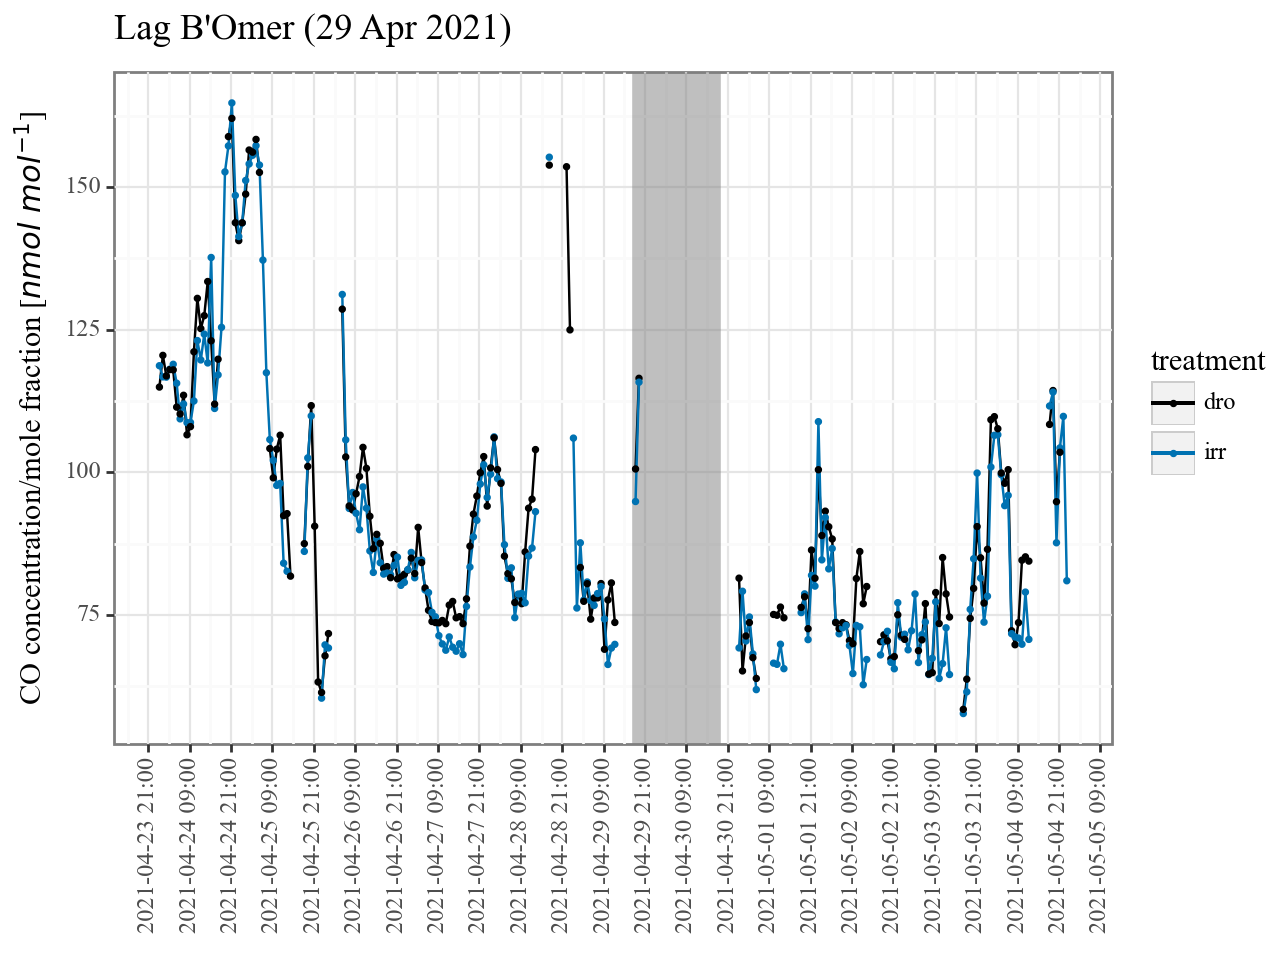

In [5]:
# Lag b'Omer typically has high CO concentrations, but our measurement was offline
# 29 Apr 2021 – 30 Apr 2021

# Show the ambient concentration of CO
temp = df.loc[(df['status'] == 'cc'), ['timestamp', 'treatment', 'chamber','conc.co.nmol_mol.filtered','flux.co.ch_oc.nmol_m2_s']]

temp['timestamp2'] = temp['timestamp'].dt.floor('30min') + pd.Timedelta('15min')
temp = temp.sort_values(by=['timestamp'])

temp = temp.loc[temp.duplicated('timestamp2', keep=False) == True].copy()

lag_b_omer = temp.loc[(temp['timestamp'] >= '2021-04-24') & (temp['timestamp'] <= '2021-05-05')]

#display(temp.loc[(temp['timestamp'] >= '2021-04-28') & (temp['timestamp'] <= '2021-04-29')])

plt = ggplot(lag_b_omer)
plt = plt + geom_vline(aes(xintercept=pd.to_datetime('2021-04-30 6:00')), colour='grey', size=18, alpha=0.5)
plt = plt + geom_line(aes(x='timestamp', y='conc.co.nmol_mol.filtered', colour='treatment'), size=0.5)
plt = plt + geom_point(aes(x='timestamp', y='conc.co.nmol_mol.filtered', colour='treatment'), size=0.5)
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + labs(y='CO concentration/mole fraction [$nmol~mol^{-1}$]')
plt = plt + ggtitle('Lag B\'Omer (29 Apr 2021)')
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), axis_title_x = element_blank(),
                  text=element_text(family="serif"))
plt = plt + scale_x_datetime(date_breaks = '12 hours', date_labels = '%Y-%m-%d %H:%M')
print(plt)

#### Information on columns

df['g_br'] = leaf_conductance

df['g_tw'] = total_water_conductance

df['g_tCO'] = total conductance for CO

In [6]:
# Midday data

temp = df.loc[df['status'] == 'cc', ['timestamp', 'treatment', 'chamber','season','rain','hamsin',
                                     'flux.co.ch_oc.nmol_m2_s',
                                     'flux.co2.ch_oc.umol_m2_s1',
                                     'flux.h2o.ch_oc.mmol_m2_s',
                                     'conc_ci.co.nmol_mol',
                                     #'conc_ci.h2o.mmol_mol',
                                     'g_tCO',
                                     'par.current.chamber.umol_m2_s1']]
# Remove now-obsolete columns
temp.drop(['rain','hamsin','chamber'], axis=1, inplace=True)

midday = temp.loc[(temp['timestamp'].dt.hour >= 10) & (temp['timestamp'].dt.hour < 15), ['season','treatment','flux.co.ch_oc.nmol_m2_s',
                                                                                         'conc_ci.co.nmol_mol',#'conc_ci.h2o.mmol_mol',
                                                                                         'g_tCO', 'par.current.chamber.umol_m2_s1']]
midday_means = midday.groupby(['season','treatment']).agg(['mean','median','std']).reset_index()
annual_means = midday.drop(columns='season').groupby(['treatment']).agg(['mean','median','std']).reset_index()

print('CO flux difference between droughted & irrigated:')
# t-tests Summer
a = midday.loc[(midday['season'] == 'Summer') & (midday['treatment'] == 'dro'),'flux.co.ch_oc.nmol_m2_s']
b = midday.loc[(midday['season'] == 'Summer') & (midday['treatment'] == 'irr'),'flux.co.ch_oc.nmol_m2_s']
t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
print('P =', pvalue_text(t[1]))

# t-tests Winter
a = midday.loc[(midday['season'] == 'Winter') & (midday['treatment'] == 'dro'),'flux.co.ch_oc.nmol_m2_s']
b = midday.loc[(midday['season'] == 'Winter') & (midday['treatment'] == 'irr'),'flux.co.ch_oc.nmol_m2_s']
t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
print('P =', pvalue_text(t[1]))

print('COi difference between winter & summer in droughted:')
a = midday.loc[(midday['season'] == 'Winter') & (midday['treatment'] == 'dro'),'conc_ci.co.nmol_mol']
b = midday.loc[(midday['season'] == 'Summer') & (midday['treatment'] == 'dro'),'conc_ci.co.nmol_mol']
t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
print('P =', pvalue_text(t[1]))

#print('H2Oi difference between winter & summer in droughted:')
## t-tests Summer
#a = midday.loc[(midday['season'] == 'Winter') & (midday['treatment'] == 'dro'),'conc_ci.h2o.mmol_mol']
#b = midday.loc[(midday['season'] == 'Summer') & (midday['treatment'] == 'dro'),'conc_ci.h2o.mmol_mol']
#t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
#print('P =', pvalue_text(t[1]))

#print('H2Oi difference summer in between dro & irr:')
## t-tests Summer
#a = midday.loc[(midday['season'] == 'Summer') & (midday['treatment'] == 'irr'),'conc_ci.h2o.mmol_mol']
#b = midday.loc[(midday['season'] == 'Summer') & (midday['treatment'] == 'dro'),'conc_ci.h2o.mmol_mol']
#t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
#print('P =', pvalue_text(t[1]))

print('g_tCO difference between winter & summer in droughted:')
# t-tests Summer
a = midday.loc[(midday['season'] == 'Winter') & (midday['treatment'] == 'dro'),'g_tCO']
b = midday.loc[(midday['season'] == 'Summer') & (midday['treatment'] == 'dro'),'g_tCO']
t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
print('P =', pvalue_text(t[1]))

print('PAR difference between irr & dro in autumn:')
# t-tests Summer
a = midday.loc[(midday['season'] == 'Autumn') & (midday['treatment'] == 'irr'),'par.current.chamber.umol_m2_s1']
b = midday.loc[(midday['season'] == 'Autumn') & (midday['treatment'] == 'dro'),'par.current.chamber.umol_m2_s1']
t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
print('P =', pvalue_text(t[1]))

# Means
print('Midday means, by season')
display(midday_means)
print('Midday means, annual')
display(annual_means)

# Correlation between transpiration and CO flux
#print('Correlation between H2Oi and CO flux')
#x = midday.loc[(midday['treatment'] == 'irr') &
#             ~(midday['conc_ci.h2o.mmol_mol'].isna()) &
#             ~(midday['flux.co.ch_oc.nmol_m2_s'].isna()), 'conc_ci.h2o.mmol_mol']
#y = midday.loc[(midday['treatment'] == 'irr') &
#             ~(midday['conc_ci.h2o.mmol_mol'].isna()) &
#             ~(midday['flux.co.ch_oc.nmol_m2_s'].isna()), 'flux.co.ch_oc.nmol_m2_s']
#res = stats.linregress(x, y)
#print(f"Irrigated R^2: {res.rvalue**2:.3f}")

#x = midday.loc[(midday['treatment'] == 'dro') &
#             ~(midday['conc_ci.h2o.mmol_mol'].isna()) &
#             ~(midday['flux.co.ch_oc.nmol_m2_s'].isna()), 'conc_ci.h2o.mmol_mol']
#y = midday.loc[(midday['treatment'] == 'dro') &
#             ~(midday['conc_ci.h2o.mmol_mol'].isna()) &
#             ~(midday['flux.co.ch_oc.nmol_m2_s'].isna()), 'flux.co.ch_oc.nmol_m2_s']
#res = stats.linregress(x, y)
#print(f"Droughted R^2: {res.rvalue**2:.3f}")

#x = midday.loc[~(midday['conc_ci.h2o.mmol_mol'].isna()) &
#             ~(midday['flux.co.ch_oc.nmol_m2_s'].isna()), 'conc_ci.h2o.mmol_mol']
#y = midday.loc[~(midday['conc_ci.h2o.mmol_mol'].isna()) &
#             ~(midday['flux.co.ch_oc.nmol_m2_s'].isna()), 'flux.co.ch_oc.nmol_m2_s']
#res = stats.linregress(x, y)
#print(f"Overall R^2: {res.rvalue**2:.3f}")

CO flux difference between droughted & irrigated:
P = <.001
P = <.05
COi difference between winter & summer in droughted:
P = <.001
g_tCO difference between winter & summer in droughted:
P = <.001
PAR difference between irr & dro in autumn:
P = 0.74
Midday means, by season


season treatment flux.co.ch_oc.nmol_m2_s                      \
                                       mean    median       std   
0  Autumn       dro                0.118623  0.141477  0.203105   
1  Autumn       irr                0.452634  0.441567  0.403185   
2  Spring       dro                0.768435  0.806630  0.400043   
3  Spring       irr                1.373354  1.429905  1.666321   
4  Summer       dro                1.231178  1.209114  0.417786   
5  Summer       irr                1.897316  2.081206  1.516078   
6  Winter       dro                0.076603  0.081536  0.583397   
7  Winter       irr               -0.015351 -0.031526  0.563845   

  conc_ci.co.nmol_mol                             g_tCO                      \
                 mean      median         std      mean    median       std   
0          154.165590  161.343814  130.638742  0.008617  0.007829  0.006566   
1          143.669225  140.902967   45.428134  0.079581  0.073876  0.046817   
2          447.689543  442.024801  220.185858  0.004352  0.002782  0.004390   
3          153.018430  146.814968  110.998670  0.131299  0.111911  0.073317   
4          576.285414  573.321167  205.065414  0.003303  0.002829  0.001966   
5          155.415953  154.625291   38.719067  0.065189  0.058244  0.032986   
6          157.914316  153.910812   39.418938  0.025103  0.020393  0.018500   
7          147.872222  147.601322   28.023461  0.204593  0.179686  0.107754   

  par.current.chamber.umol_m2_s1                           
                            mean       median         std  
0                     293.555485   226.078975  232.568956  
1                     300.252123   231.473124  220.727514  
2                    1669.407712  1818.400150  423.770016  
3                    1099.901481  1091.016132  455.502613  
4                    1875.589105  1919.244067  174.041129  
5                    1468.497844  1733.897953  549.955471  
6                     368.572329   226.469867  366.651385  
7                     319.843367   211.031248  266.047700

Midday means, annual


treatment flux.co.ch_oc.nmol_m2_s                     conc_ci.co.nmol_mol  \
                               mean    median       std                mean   
0       dro                0.508837  0.299420  0.682891          317.722441   
1       irr                0.810719  0.410069  1.354653          149.746744   

                              g_tCO                      \
       median         std      mean    median       std   
0  188.801557  239.630518  0.013165  0.006677  0.015878   
1  148.105644   57.122028  0.129534  0.100535  0.096642   

  par.current.chamber.umol_m2_s1                          
                            mean      median         std  
0                     927.169859  537.197368  774.098042  
1                     700.605759  471.162718  602.540538

Difference between treatments (CO flux)
Hot months, P = <.001
    Droughted: 1.11 ± 0.32
    Irrigated: 2.53 ± 1.12
Cool months, P = <.001
    Droughted: 0.09 ± 0.2
    Irrigated: 0.23 ± 0.4


C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 644 rows containing missing values.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms\geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


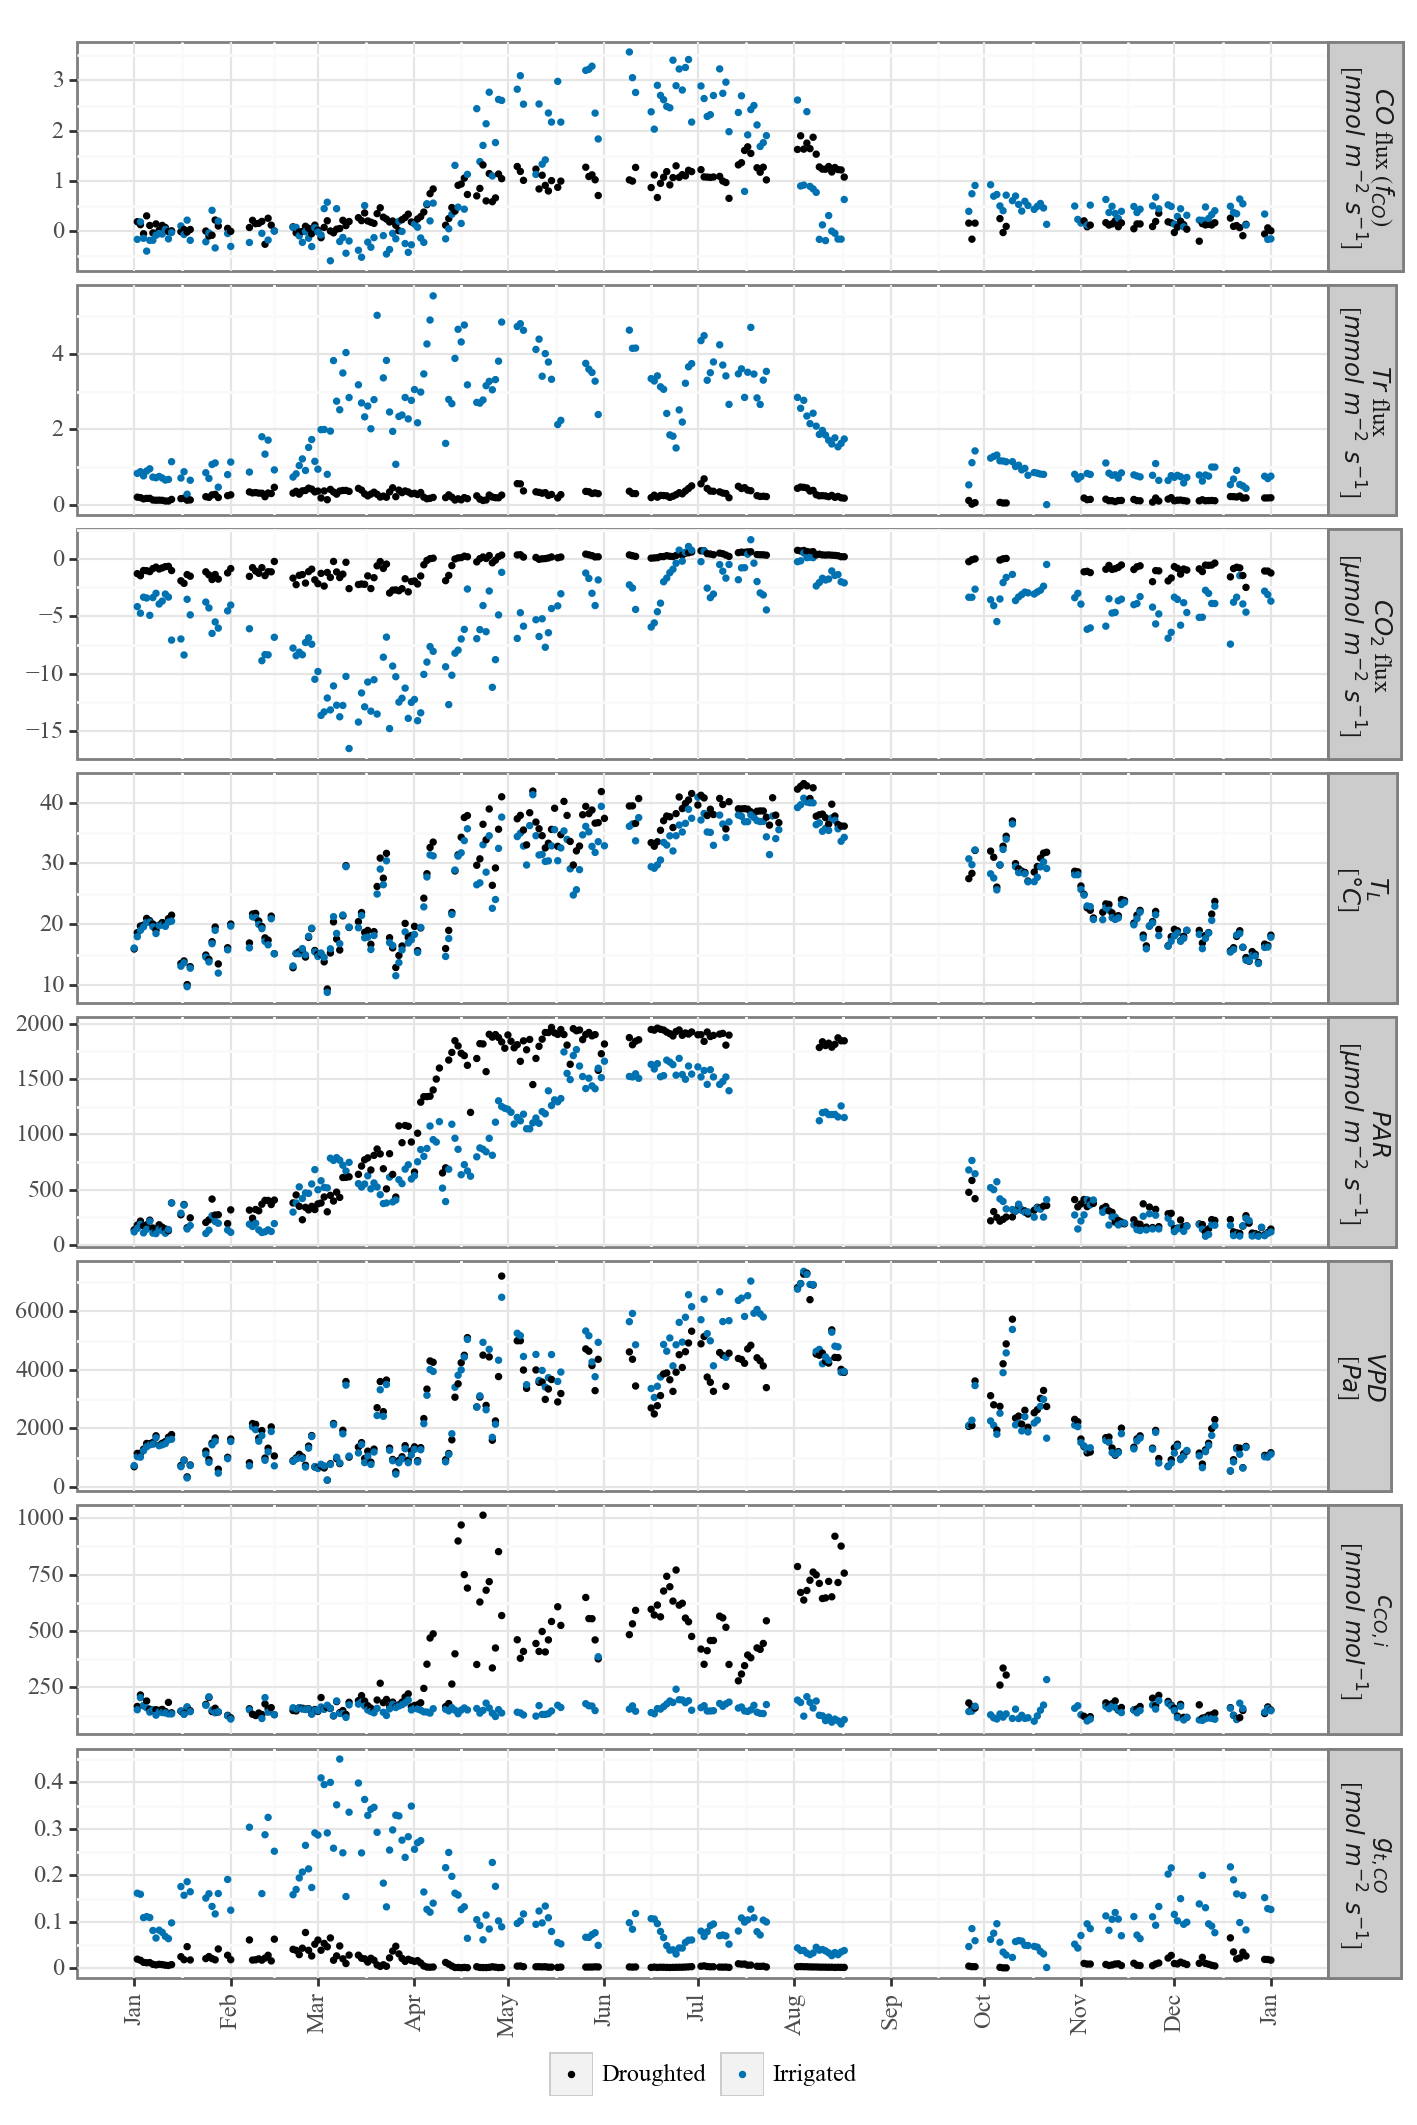

C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 19.0 x 27.000000000000004 cm image.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../graphs/01a_flux_annual.png
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 644 rows containing missing values.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms\geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the f

In [7]:
# Grid of midday CO & parameters thoughout the year (Figure 1)
#-------------------------------------------------------------

# Daily midday data
def pvalue_text(p):
    if(p <= 0.001): p_text = '<.001'
    if(p > 0.001): p_text = '<.01'
    if(p > 0.01): p_text = '<.05'
    if(p > 0.05): p_text = p.round(2).astype(str)
    return(p_text)

temp = df.loc[df['status'] == 'cc', ['timestamp', 'treatment', 'chamber','season','rain','hamsin',
                                     'flux.co.ch_oc.nmol_m2_s',
                                     'flux.co2.ch_oc.umol_m2_s1',
                                     'flux.h2o.ch_oc.mmol_m2_s',
                                     'temp.leaf.current.chamber.c.oc',
                                     'par.current.chamber.umol_m2_s1',
                                     'VPD.Pa.oc',
                                     'conc_ci.co.nmol_mol',
                                     #'conc.co.nmol_mol.oc.filtered.corrected',
                                     #'conc_ci.h2o.mmol_mol',
                                     'swc_10_30cm',
                                     'g_tCO']].copy()

# Remove now-obsolete columns
temp.drop(['rain','hamsin','chamber'], axis=1, inplace=True)

# Remove some bad values
temp.loc[temp['flux.co.ch_oc.nmol_m2_s'] < -0.8, 'flux.co.ch_oc.nmol_m2_s'] = np.nan
temp.loc[temp['conc_ci.co.nmol_mol'] < 10, 'conc_ci.co.nmol_mol'] = np.nan
temp.loc[(temp['flux.co.ch_oc.nmol_m2_s'] > 1) & (temp['timestamp'].dt.month < 4), 'flux.co.ch_oc.nmol_m2_s'] = np.nan
temp.loc[(temp['flux.co2.ch_oc.umol_m2_s1'] < -10) & (temp['timestamp'].dt.month >= 9), 'flux.co2.ch_oc.umol_m2_s1'] = np.nan
temp.loc[temp['flux.co2.ch_oc.umol_m2_s1'] > 2.5, 'flux.co2.ch_oc.umol_m2_s1'] = np.nan
#temp.loc[temp['conc.co.nmol_mol.oc.filtered.corrected'] < 50, 'conc.co.nmol_mol.oc.filtered.corrected'] = np.nan

temp['doy'] = temp['timestamp'].dt.strftime('%j').astype(int)
midday = temp.loc[(temp['timestamp'].dt.hour >= 10) & (temp['timestamp'].dt.hour < 15), ['timestamp','doy','treatment',
                                                                                         'flux.co.ch_oc.nmol_m2_s',
                                                                                         'flux.h2o.ch_oc.mmol_m2_s',
                                                                                         'flux.co2.ch_oc.umol_m2_s1',
                                                                                         'temp.leaf.current.chamber.c.oc',
                                                                                         'par.current.chamber.umol_m2_s1',
                                                                                         'VPD.Pa.oc',
                                                                                         'conc_ci.co.nmol_mol',
                                                                                         #'conc_ci.h2o.mmol_mol',
                                                                                         #'conc.co.nmol_mol.oc.filtered.corrected',
                                                                                         #'swc_10_30cm',
                                                                                         'g_tCO']]
midday.rename({'flux.co.ch_oc.nmol_m2_s': 'flux_co'}, axis=1, inplace=True)
midday.rename({'temp.leaf.current.chamber.c.oc': 'TL'}, axis=1, inplace=True)
midday2 = pd.melt(midday.loc[:, midday.columns != 'timestamp'], id_vars=['doy','treatment'])
grouped = midday2.groupby(['doy','treatment','variable']).agg(['mean','median','std']).reset_index()
grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns.values]
grouped['timestamp'] = pd.to_datetime(grouped['doy'], format='%j')
grouped['treatment'] = grouped['treatment'].str.replace('dro', 'Droughted')
grouped['treatment'] = grouped['treatment'].str.replace('irr', 'Irrigated')

print('Difference between treatments (CO flux)')
# Hot months, statistical differences
a = midday.loc[(midday['timestamp'].dt.month.isin([5,6,7])) & (midday['treatment'] == 'dro') & (~midday['flux_co'].isna()),'flux_co']
b = midday.loc[(midday['timestamp'].dt.month.isin([5,6,7])) & (midday['treatment'] == 'irr') & (~midday['flux_co'].isna()),'flux_co']
t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
print('Hot months, P =', pvalue_text(t[1]))
print('    Droughted:', np.round(np.mean(a),2), '±', np.round(np.std(a),2))
print('    Irrigated:', np.round(np.mean(b),2), '±', np.round(np.std(b),2))

# Hot months, statistical differences
a = midday.loc[(midday['timestamp'].dt.month.isin([10,11,12,1,2])) & (midday['treatment'] == 'dro') & (~midday['flux_co'].isna()),'flux_co']
b = midday.loc[(midday['timestamp'].dt.month.isin([10,11,12,1,2])) & (midday['treatment'] == 'irr') & (~midday['flux_co'].isna()),'flux_co']
t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
print('Cool months, P =', pvalue_text(t[1]))
print('    Droughted:', np.round(np.mean(a),2), '±', np.round(np.std(a),2))
print('    Irrigated:', np.round(np.mean(b),2), '±', np.round(np.std(b),2))

#grouped.loc[grouped['variable'] == 't_air', 'variable'] = '$T_{air}$ [$°C$]'
#grouped.loc[grouped['variable'] == 'flux_co', 'variable'] = 'CO flux [$nmol~m^{-2}~s^{-1}$]'
#grouped.loc[grouped['variable'] == 'par.current.chamber.umol_m2_s1', 'variable'] = 'PAR [$\mu mol~m^{-2}~s^{-1}$]'
#grouped.loc[grouped['variable'] == 'VPD.Pa', 'variable'] = 'VPD [$Pa$]'
#
grouped.loc[grouped['variable'] == 'flux_co', 'variable'] = '$CO$ flux ($f_{CO}$)\n[$nmol~m^{-2}~s^{-1}$]'
grouped.loc[grouped['variable'] == 'flux.h2o.ch_oc.mmol_m2_s', 'variable'] = '$Tr$ flux\n[$mmol~m^{-2}~s^{-1}$]'
grouped.loc[grouped['variable'] == 'flux.co2.ch_oc.umol_m2_s1', 'variable'] = '$CO_2$ flux\n[$\mu mol~m^{-2}~s^{-1}$]'
grouped.loc[grouped['variable'] == 'TL', 'variable'] = '$T_L$\n[$°C$]'
grouped.loc[grouped['variable'] == 'par.current.chamber.umol_m2_s1', 'variable'] = '$PAR$\n[$\mu mol~m^{-2}~s^{-1}$]'
grouped.loc[grouped['variable'] == 'VPD.Pa.oc', 'variable'] = '$VPD$\n[$Pa$]'
grouped.loc[grouped['variable'] == 'conc_ci.co.nmol_mol', 'variable'] = '$c_{CO,i}$\n[$nmol~mol^{-1}$]'
#grouped.loc[grouped['variable'] == 'conc_ci.h2o.mmol_mol', 'variable'] = '$c_{H_2 O,i}$'
#grouped.loc[grouped['variable'] == 'conc.co.nmol_mol.oc.filtered.corrected', 'variable'] = '$CO$ conc. (amb.)'
#grouped.loc[grouped['variable'] == 'swc_10_30cm', 'variable'] = 'SWC 10-30cm'
grouped.loc[grouped['variable'] == 'g_tCO', 'variable'] = '$g_{t,CO}$\n[$mol~m^{-2}~s^{-1}$]'


grouped['variable'] = order_cats(grouped['variable'], list_ordering=['$CO$ flux ($f_{CO}$)\n[$nmol~m^{-2}~s^{-1}$]',
                                                                     '$Tr$ flux\n[$mmol~m^{-2}~s^{-1}$]',
                                                                     '$CO_2$ flux\n[$\mu mol~m^{-2}~s^{-1}$]',
                                                                     '$T_L$\n[$°C$]',
                                                                     '$PAR$\n[$\mu mol~m^{-2}~s^{-1}$]',
                                                                     '$VPD$\n[$Pa$]',
                                                                     '$c_{CO,i}$\n[$nmol~mol^{-1}$]',
                                                                     #'$c_{H_2 O,i}$',
                                                                     #'$CO$ conc. (amb.)',
                                                                     '$g_{t,CO}$\n[$mol~m^{-2}~s^{-1}$]',
                                                                     #'SWC 10-30cm'
                                                                     ])

plt = ggplot(grouped)
plt = plt + geom_point(aes(x='timestamp', y='value_mean', colour='treatment', linetype='treatment'), size=0.5)
#plt = plt + geom_ribbon(aes(x='timestamp', ymin='value_mean - value_std', ymax='value_mean + value_std', fill='treatment'), alpha=0.1)
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), axis_title_x = element_blank(), axis_title_y = element_blank(),
                  text=element_text(family="serif"),
                  legend_box_spacing=0.01, legend_title = element_blank(), legend_position='bottom')
plt = plt + theme(figure_size=(18/2.54, 27/2.54))
#plt = plt + coord_cartesian(ylim=[-2.0, 7.0])
plt = plt + scale_x_datetime(date_breaks = '1 month', date_labels = '%b')
plt = plt + facet_grid('variable ~', scales='free_y')
print(plt)

plt.save(graphs_path + '01a_flux_annual.png', width=19, height=27, units='cm', dpi=600)
plt.save(graphs_path + '01a_flux_annual.pdf', width=19, height=27, units='cm', dpi=600)

C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 644 rows containing missing values.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms\geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curre

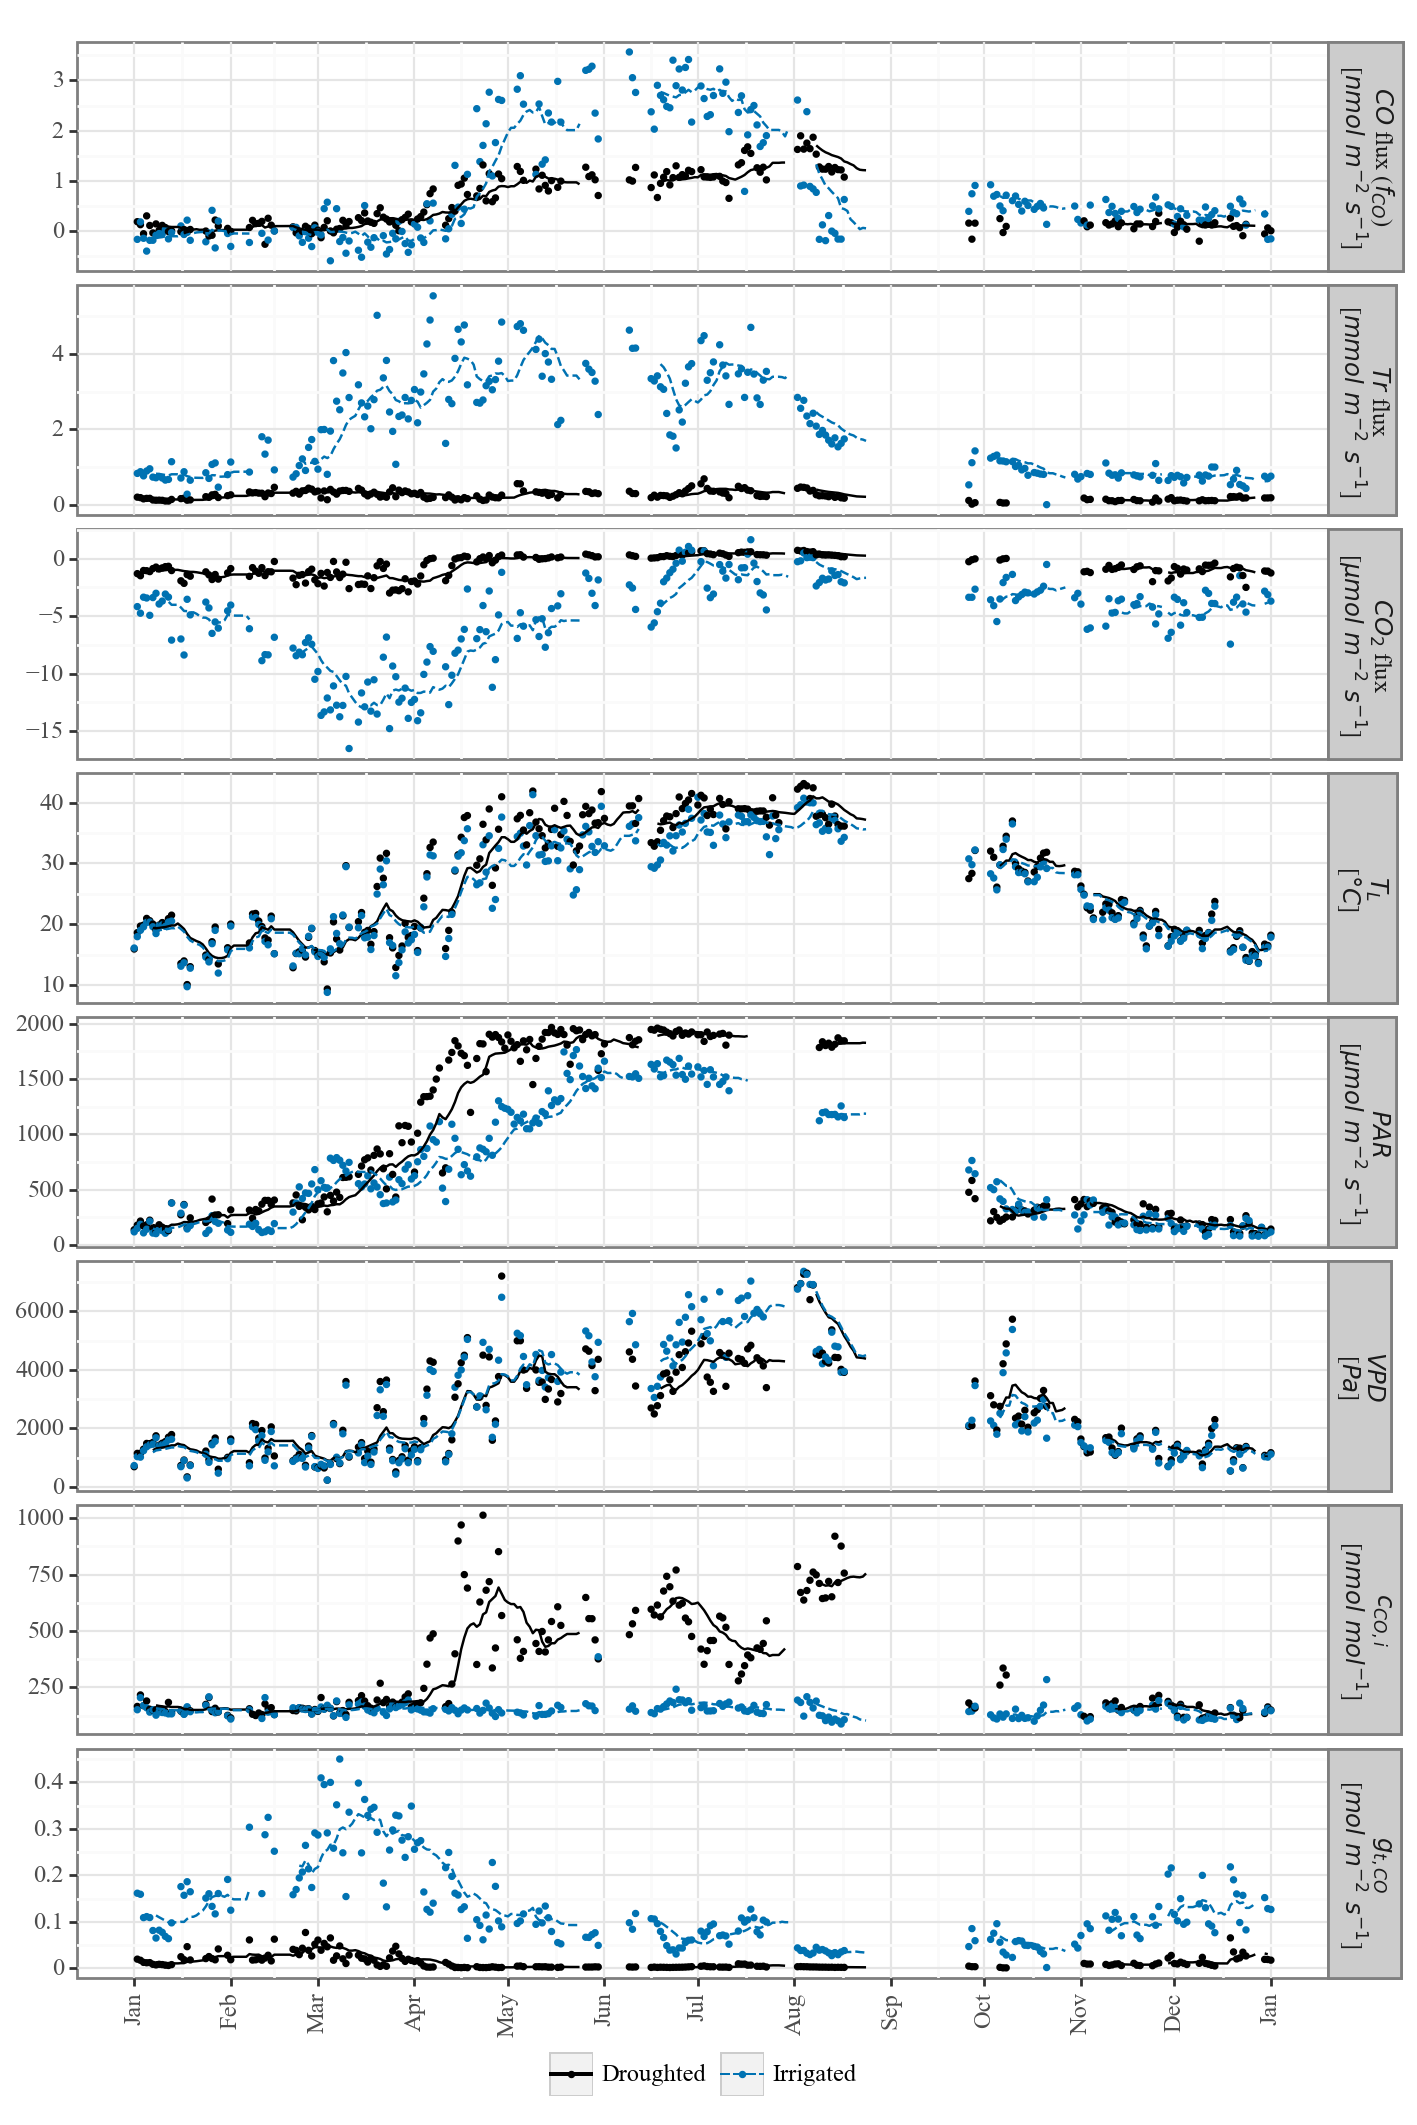

C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 19.0 x 27.000000000000004 cm image.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../graphs/01a_flux_annual_trendline.png
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point :

In [28]:
temp = df.loc[df['status'] == 'cc', ['timestamp', 'treatment', 'chamber','season','rain','hamsin',
                                     'flux.co.ch_oc.nmol_m2_s',
                                     'flux.co2.ch_oc.umol_m2_s1',
                                     'flux.h2o.ch_oc.mmol_m2_s',
                                     'temp.leaf.current.chamber.c.oc',
                                     'par.current.chamber.umol_m2_s1',
                                     'VPD.Pa.oc',
                                     'conc_ci.co.nmol_mol',
                                     #'conc.co.nmol_mol.oc.filtered.corrected',
                                     #'conc_ci.h2o.mmol_mol',
                                     'swc_10_30cm',
                                     'g_tCO']].copy()

# Remove now-obsolete columns
temp.drop(['rain','hamsin','chamber'], axis=1, inplace=True)

# Remove some bad values
temp.loc[temp['flux.co.ch_oc.nmol_m2_s'] < -0.8, 'flux.co.ch_oc.nmol_m2_s'] = np.nan
temp.loc[temp['conc_ci.co.nmol_mol'] < 10, 'conc_ci.co.nmol_mol'] = np.nan
temp.loc[(temp['flux.co.ch_oc.nmol_m2_s'] > 1) & (temp['timestamp'].dt.month < 4), 'flux.co.ch_oc.nmol_m2_s'] = np.nan
temp.loc[(temp['flux.co2.ch_oc.umol_m2_s1'] < -10) & (temp['timestamp'].dt.month >= 9), 'flux.co2.ch_oc.umol_m2_s1'] = np.nan
temp.loc[temp['flux.co2.ch_oc.umol_m2_s1'] > 2.5, 'flux.co2.ch_oc.umol_m2_s1'] = np.nan
#temp.loc[temp['conc.co.nmol_mol.oc.filtered.corrected'] < 50, 'conc.co.nmol_mol.oc.filtered.corrected'] = np.nan

temp['doy'] = temp['timestamp'].dt.strftime('%j').astype(int)
midday = temp.loc[(temp['timestamp'].dt.hour >= 10) & (temp['timestamp'].dt.hour < 15), ['timestamp','doy','treatment',
                                                                                         'flux.co.ch_oc.nmol_m2_s',
                                                                                         'flux.h2o.ch_oc.mmol_m2_s',
                                                                                         'flux.co2.ch_oc.umol_m2_s1',
                                                                                         'temp.leaf.current.chamber.c.oc',
                                                                                         'par.current.chamber.umol_m2_s1',
                                                                                         'VPD.Pa.oc',
                                                                                         'conc_ci.co.nmol_mol',
                                                                                         #'conc_ci.h2o.mmol_mol',
                                                                                         #'conc.co.nmol_mol.oc.filtered.corrected',
                                                                                         #'swc_10_30cm',
                                                                                         'g_tCO']]
midday.rename({'flux.co.ch_oc.nmol_m2_s': 'flux_co'}, axis=1, inplace=True)
midday.rename({'temp.leaf.current.chamber.c.oc': 'TL'}, axis=1, inplace=True)
midday2 = pd.melt(midday.loc[:, midday.columns != 'timestamp'], id_vars=['doy','treatment'])
grouped = midday2.groupby(['doy','treatment','variable']).agg(['mean','median','std']).reset_index()
grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns.values]
grouped['timestamp'] = pd.to_datetime(grouped['doy'], format='%j')
grouped['treatment'] = grouped['treatment'].str.replace('dro', 'Droughted')
grouped['treatment'] = grouped['treatment'].str.replace('irr', 'Irrigated')

grouped.loc[grouped['variable'] == 'flux_co', 'variable'] = '$CO$ flux ($f_{CO}$)\n[$nmol~m^{-2}~s^{-1}$]'
grouped.loc[grouped['variable'] == 'flux.h2o.ch_oc.mmol_m2_s', 'variable'] = '$Tr$ flux\n[$mmol~m^{-2}~s^{-1}$]'
grouped.loc[grouped['variable'] == 'flux.co2.ch_oc.umol_m2_s1', 'variable'] = '$CO_2$ flux\n[$\mu mol~m^{-2}~s^{-1}$]'
grouped.loc[grouped['variable'] == 'TL', 'variable'] = '$T_L$\n[$°C$]'
grouped.loc[grouped['variable'] == 'par.current.chamber.umol_m2_s1', 'variable'] = '$PAR$\n[$\mu mol~m^{-2}~s^{-1}$]'
grouped.loc[grouped['variable'] == 'VPD.Pa.oc', 'variable'] = '$VPD$\n[$Pa$]'
grouped.loc[grouped['variable'] == 'conc_ci.co.nmol_mol', 'variable'] = '$c_{CO,i}$\n[$nmol~mol^{-1}$]'
grouped.loc[grouped['variable'] == 'g_tCO', 'variable'] = '$g_{t,CO}$\n[$mol~m^{-2}~s^{-1}$]'


grouped['variable'] = order_cats(grouped['variable'], list_ordering=['$CO$ flux ($f_{CO}$)\n[$nmol~m^{-2}~s^{-1}$]',
                                                                     '$Tr$ flux\n[$mmol~m^{-2}~s^{-1}$]',
                                                                     '$CO_2$ flux\n[$\mu mol~m^{-2}~s^{-1}$]',
                                                                     '$T_L$\n[$°C$]',
                                                                     '$PAR$\n[$\mu mol~m^{-2}~s^{-1}$]',
                                                                     '$VPD$\n[$Pa$]',
                                                                     '$c_{CO,i}$\n[$nmol~mol^{-1}$]',
                                                                     '$g_{t,CO}$\n[$mol~m^{-2}~s^{-1}$]'
                                                                     ])

point_df = grouped.copy()

#----------------
# Running average

# Try to do a running avg for Dan
grouped = midday.groupby(['doy','treatment']).agg(['mean']).reset_index()
grouped = grouped.loc[grouped['doy'] < 366].copy()
grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns.values]
grouped.drop(['timestamp_mean'], axis=1, inplace=True)

# Make sure all doys are available
import itertools
doy_list = list(range(1, 366))
treatments = ['dro', 'irr']
combinations = list(itertools.product(doy_list, treatments))
time_df = pd.DataFrame(combinations, columns=['doy', 'treatment'])
grouped = time_df.merge(grouped, how='left', on=['doy','treatment'])
grouped['timestamp'] = pd.to_datetime(grouped['doy'], format='%j')

window_size = 14
cols = ['flux_co_mean', 'flux.h2o.ch_oc.mmol_m2_s_mean','flux.co2.ch_oc.umol_m2_s1_mean','TL_mean',
        'par.current.chamber.umol_m2_s1_mean','VPD.Pa.oc_mean','conc_ci.co.nmol_mol_mean','g_tCO_mean']
df_interpolated = grouped.groupby(['treatment'])[cols].transform(lambda s: s.rolling(window_size, min_periods=int(window_size/2)).mean())
df_temp = pd.concat([grouped[['doy', 'timestamp', 'treatment']], df_interpolated], axis=1)

graph_df = pd.melt(df_temp, id_vars=['timestamp','doy','treatment'])

graph_df['treatment'] = graph_df['treatment'].str.replace('dro', 'Droughted')
graph_df['treatment'] = graph_df['treatment'].str.replace('irr', 'Irrigated')

graph_df.loc[graph_df['variable'] == 'flux_co_mean', 'variable'] = '$CO$ flux ($f_{CO}$)\n[$nmol~m^{-2}~s^{-1}$]'
graph_df.loc[graph_df['variable'] == 'flux.h2o.ch_oc.mmol_m2_s_mean', 'variable'] = '$Tr$ flux\n[$mmol~m^{-2}~s^{-1}$]'
graph_df.loc[graph_df['variable'] == 'flux.co2.ch_oc.umol_m2_s1_mean', 'variable'] = '$CO_2$ flux\n[$\mu mol~m^{-2}~s^{-1}$]'
graph_df.loc[graph_df['variable'] == 'TL_mean', 'variable'] = '$T_L$\n[$°C$]'
graph_df.loc[graph_df['variable'] == 'par.current.chamber.umol_m2_s1_mean', 'variable'] = '$PAR$\n[$\mu mol~m^{-2}~s^{-1}$]'
graph_df.loc[graph_df['variable'] == 'VPD.Pa.oc_mean', 'variable'] = '$VPD$\n[$Pa$]'
graph_df.loc[graph_df['variable'] == 'conc_ci.co.nmol_mol_mean', 'variable'] = '$c_{CO,i}$\n[$nmol~mol^{-1}$]'
graph_df.loc[graph_df['variable'] == 'g_tCO_mean', 'variable'] = '$g_{t,CO}$\n[$mol~m^{-2}~s^{-1}$]'

graph_df['variable'] = order_cats(graph_df['variable'], list_ordering=['$CO$ flux ($f_{CO}$)\n[$nmol~m^{-2}~s^{-1}$]',
                                                                     '$Tr$ flux\n[$mmol~m^{-2}~s^{-1}$]',
                                                                     '$CO_2$ flux\n[$\mu mol~m^{-2}~s^{-1}$]',
                                                                     '$T_L$\n[$°C$]',
                                                                     '$PAR$\n[$\mu mol~m^{-2}~s^{-1}$]',
                                                                     '$VPD$\n[$Pa$]',
                                                                     '$c_{CO,i}$\n[$nmol~mol^{-1}$]',
                                                                     '$g_{t,CO}$\n[$mol~m^{-2}~s^{-1}$]'
                                                                     ])

plt = ggplot(graph_df)
plt = plt + geom_point(aes(x='timestamp', y='value_mean', colour='treatment', linetype='treatment'), data=point_df, size=0.5)
plt = plt + geom_line(aes(x='timestamp', y='value', colour='treatment', linetype='treatment'), size=0.5)
#plt = plt + geom_ribbon(aes(x='timestamp', ymin='value_mean - value_std', ymax='value_mean + value_std', fill='treatment'), alpha=0.1)
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), axis_title_x = element_blank(), axis_title_y = element_blank(),
                  text=element_text(family="serif"),
                  legend_box_spacing=0.01, legend_title = element_blank(), legend_position='bottom')
plt = plt + theme(figure_size=(18/2.54, 27/2.54))
plt = plt + scale_x_datetime(date_breaks = '1 month', date_labels = '%b')
plt = plt + facet_grid('variable ~', scales='free_y')
print(plt)

plt.save(graphs_path + '01a_flux_annual_trendline.png', width=19, height=27, units='cm', dpi=600)
plt.save(graphs_path + '01a_flux_annual_trendline.pdf', width=19, height=27, units='cm', dpi=600)

C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms\geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms

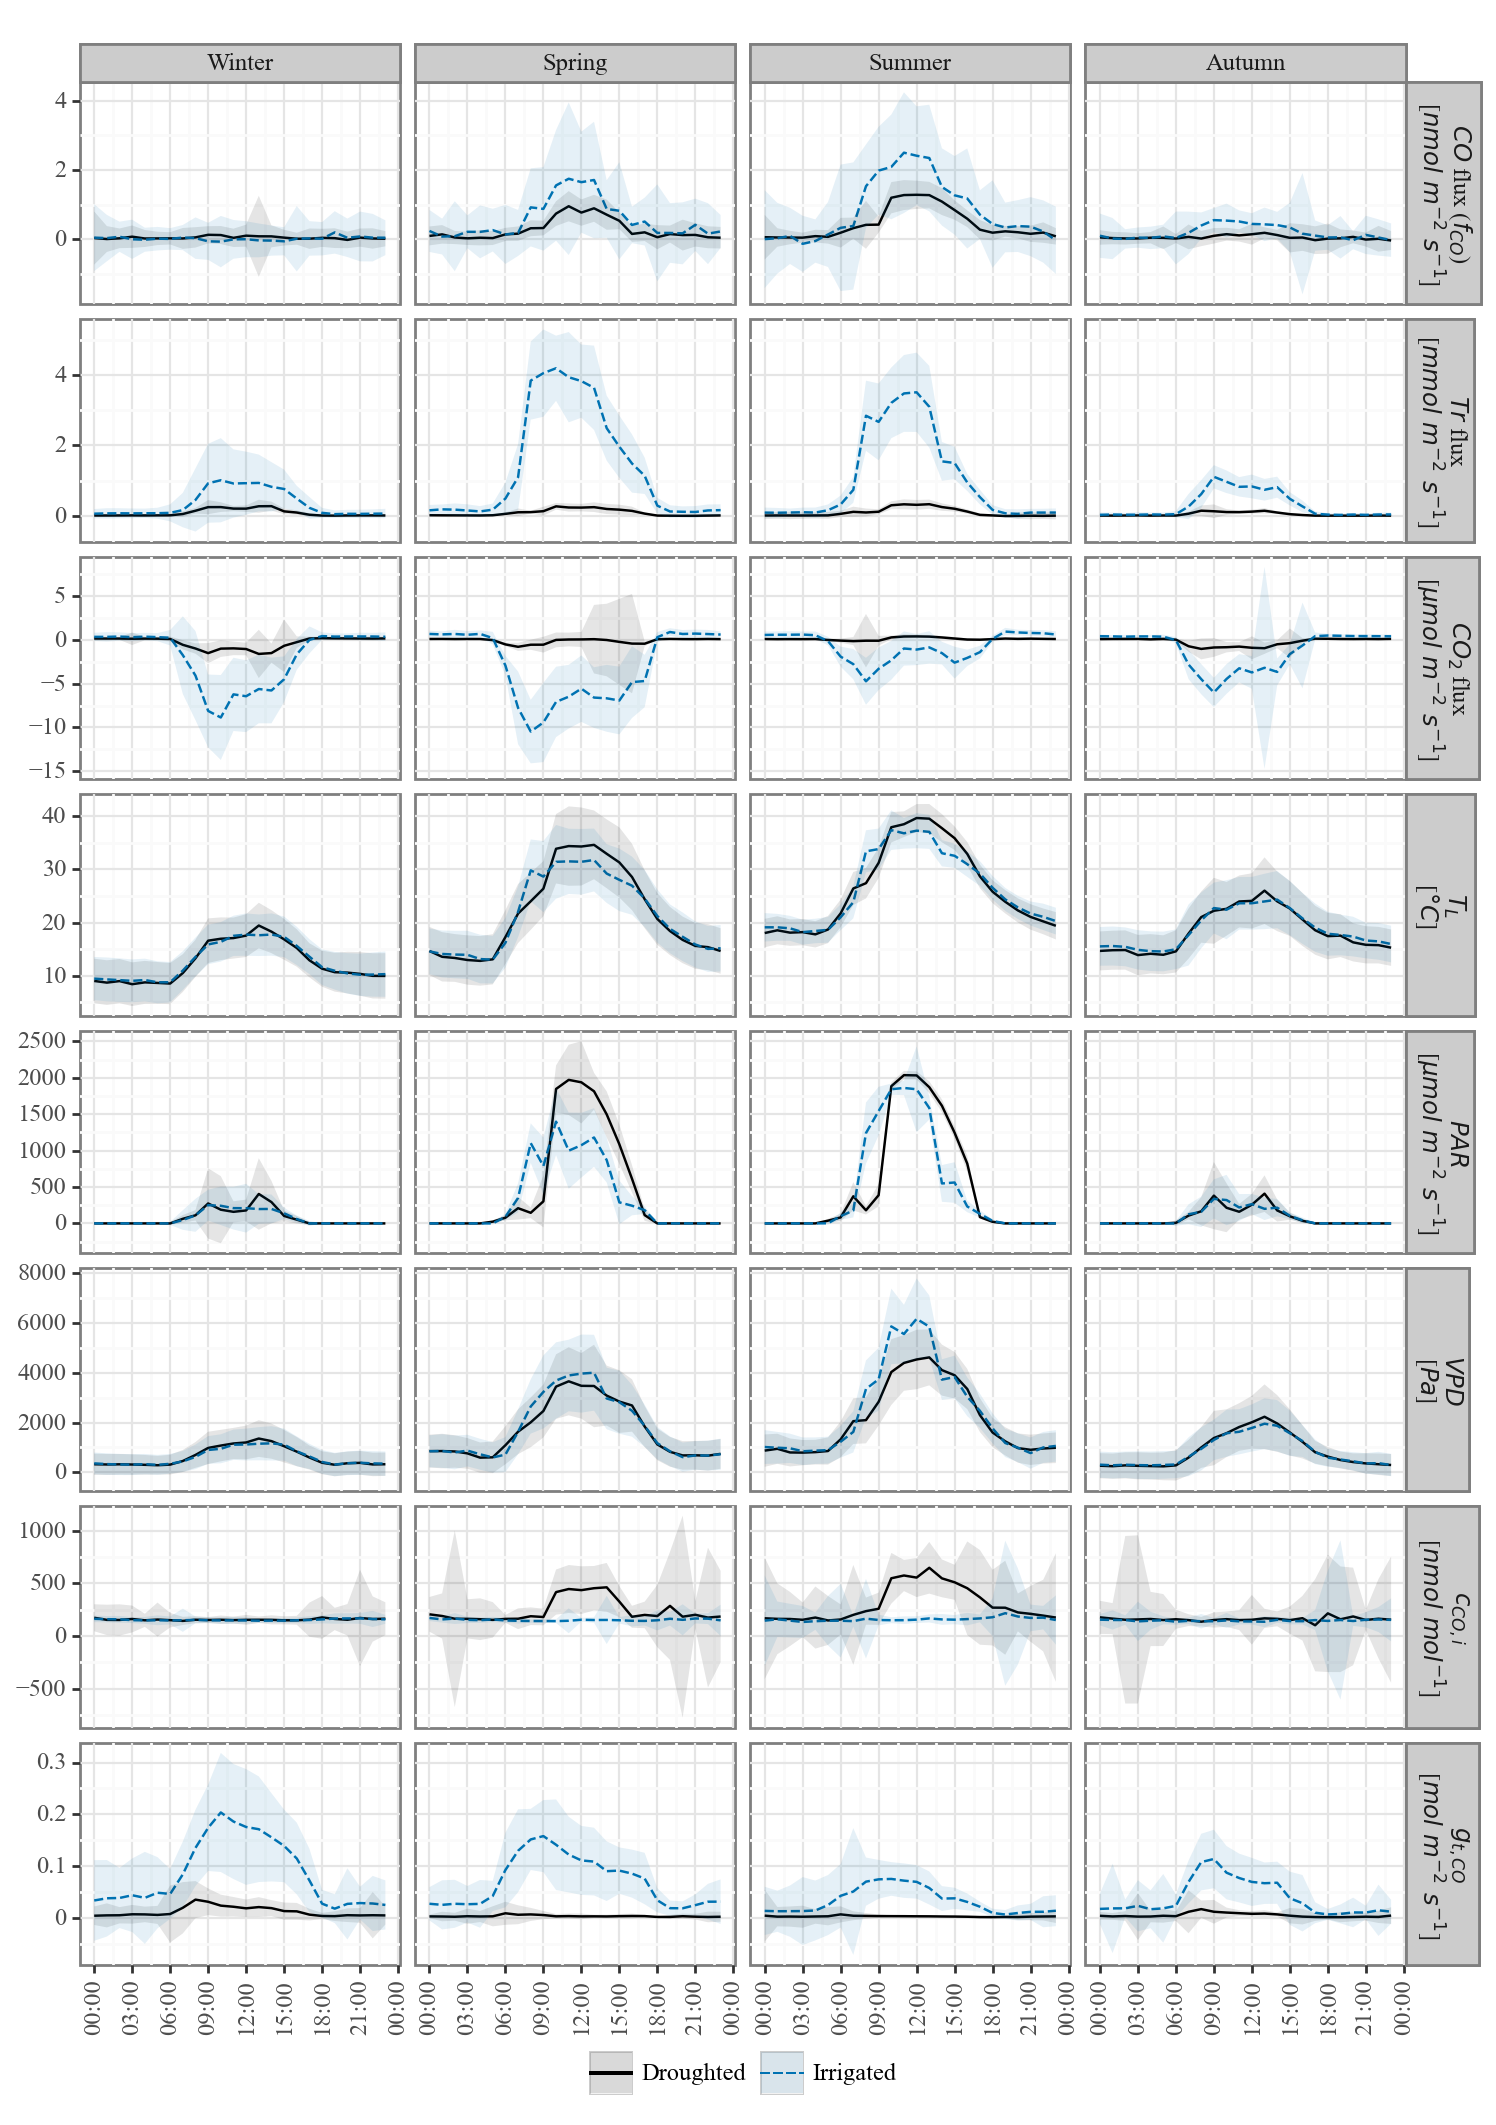

C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 19.0 x 27.000000000000004 cm image.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../graphs/02_diurnal_all_seasonal.png
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms\geom.py:289: FutureWarning: The default

In [13]:
# Diurnals by season (Figure 2) - ultra-everything edition
#------------------------------

# Colours
cbPalette = ['#000000', '#0072B2', '#E69F00', '#CC00CC', '#009E73', '#D55E00', '#CC79A7', '#FF3300', '#F0E442', '#56B4E9']

temp = df.loc[df['status'] == 'cc', ['timestamp', 'treatment', 'chamber','season','rain','hamsin',
                                     'flux.co.ch_oc.nmol_m2_s',
                                     'flux.h2o.ch_oc.mmol_m2_s',
                                     'flux.co2.ch_oc.umol_m2_s1',
                                     'temp.leaf.current.chamber.c.oc',
                                     'par.current.chamber.umol_m2_s1',
                                     'VPD.Pa.oc',
                                     'conc_ci.co.nmol_mol',
                                     'g_tCO'
                                    ]]
# Remove now-obsolete columns
temp.drop(['rain','hamsin','chamber'], axis=1, inplace=True)

temp = temp.groupby(['treatment', 'season']).resample('1h', on='timestamp').mean()
temp = temp.reset_index()

# Convert wide to long
long = pd.melt(temp, id_vars=['timestamp','treatment','season'])
long['time']  = long['timestamp'].dt.strftime('%H:%M')
# Rename all columns
long.loc[long['variable'] == 'flux.co.ch_oc.nmol_m2_s', 'variable'] = '$CO$ flux ($f_{CO}$)\n[$nmol~m^{-2}~s^{-1}$]'
long.loc[long['variable'] == 'flux.h2o.ch_oc.mmol_m2_s', 'variable'] = '$Tr$ flux\n[$mmol~m^{-2}~s^{-1}$]'
long.loc[long['variable'] == 'flux.co2.ch_oc.umol_m2_s1', 'variable'] = '$CO_2$ flux\n[$\mu mol~m^{-2}~s^{-1}$]'
long.loc[long['variable'] == 'temp.leaf.current.chamber.c.oc', 'variable'] = '$T_L$\n[$°C$]'
long.loc[long['variable'] == 'par.current.chamber.umol_m2_s1', 'variable'] = '$PAR$\n[$\mu mol~m^{-2}~s^{-1}$]'
long.loc[long['variable'] == 'VPD.Pa.oc', 'variable'] = '$VPD$\n[$Pa$]'
long.loc[long['variable'] == 'conc_ci.co.nmol_mol', 'variable'] = '$c_{CO,i}$\n[$nmol~mol^{-1}$]'
long.loc[long['variable'] == 'g_tCO', 'variable'] = '$g_{t,CO}$\n[$mol~m^{-2}~s^{-1}$]'

long['treatment'] = long['treatment'].str.replace('dro', 'Droughted')
long['treatment'] = long['treatment'].str.replace('irr', 'Irrigated')

grouped = long.groupby(['time','season','treatment','variable']).agg(['mean','median','std'])
# Reset index and rename columns
grouped = grouped.reset_index()
grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns.values]
grouped.columns = grouped.columns.str.replace('.', '_')

grouped['timestamp'] = pd.to_datetime(grouped['time'], format='%H:%M')

# Order columns
def order_cats(col, list_ordering):
    cat_dtype = pd.CategoricalDtype(categories=list_ordering, ordered=True)
    col = col.astype(cat_dtype)
    return(col)
grouped['season'] = order_cats(grouped['season'], list_ordering=['Winter','Spring','Summer','Autumn'])
#grouped['season'] = order_cats(grouped['season'], list_ordering=['wet','transition','dry'])
grouped['variable'] = order_cats(grouped['variable'], list_ordering=['$CO$ flux ($f_{CO}$)\n[$nmol~m^{-2}~s^{-1}$]',
                                                                     '$Tr$ flux\n[$mmol~m^{-2}~s^{-1}$]',
                                                                     '$CO_2$ flux\n[$\mu mol~m^{-2}~s^{-1}$]',
                                                                     '$T_L$\n[$°C$]',
                                                                     '$PAR$\n[$\mu mol~m^{-2}~s^{-1}$]',
                                                                     '$VPD$\n[$Pa$]',
                                                                     '$c_{CO,i}$\n[$nmol~mol^{-1}$]',
                                                                     '$g_{t,CO}$\n[$mol~m^{-2}~s^{-1}$]'])

# Plot the diurnal
plt = ggplot(grouped)
plt = plt + geom_line(aes(x='timestamp', y='value_median', colour='treatment', linetype='treatment'), size=0.5)
plt = plt + geom_ribbon(aes(x='timestamp', ymin='value_median - value_std', ymax='value_median + value_std', fill='treatment'), alpha=0.1)
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + labs(x='Time of day', y='Flux', colour='Treatment', fill='Treatment', linetype='Treatment')
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), axis_title_x = element_blank(), axis_title_y = element_blank(),
                  text=element_text(family="serif"),
                  legend_box_spacing=0.01, legend_title = element_blank(), legend_position='bottom')
plt = plt + facet_grid('variable ~ season', scales='free_y')
plt = plt + theme(figure_size=(19/2.54, 27/2.54))
#plt = plt + coord_cartesian(ylim=[-2.0, 7.0])
plt = plt + scale_x_datetime(date_breaks = '3 hours', date_labels = '%H:%M')
print(plt)

plt.save(graphs_path + '02_diurnal_all_seasonal.png', width=19, height=27, units='cm', dpi=600)
plt.save(graphs_path + '02_diurnal_all_seasonal.pdf', width=19, height=27, units='cm', dpi=600)

C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms\geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms

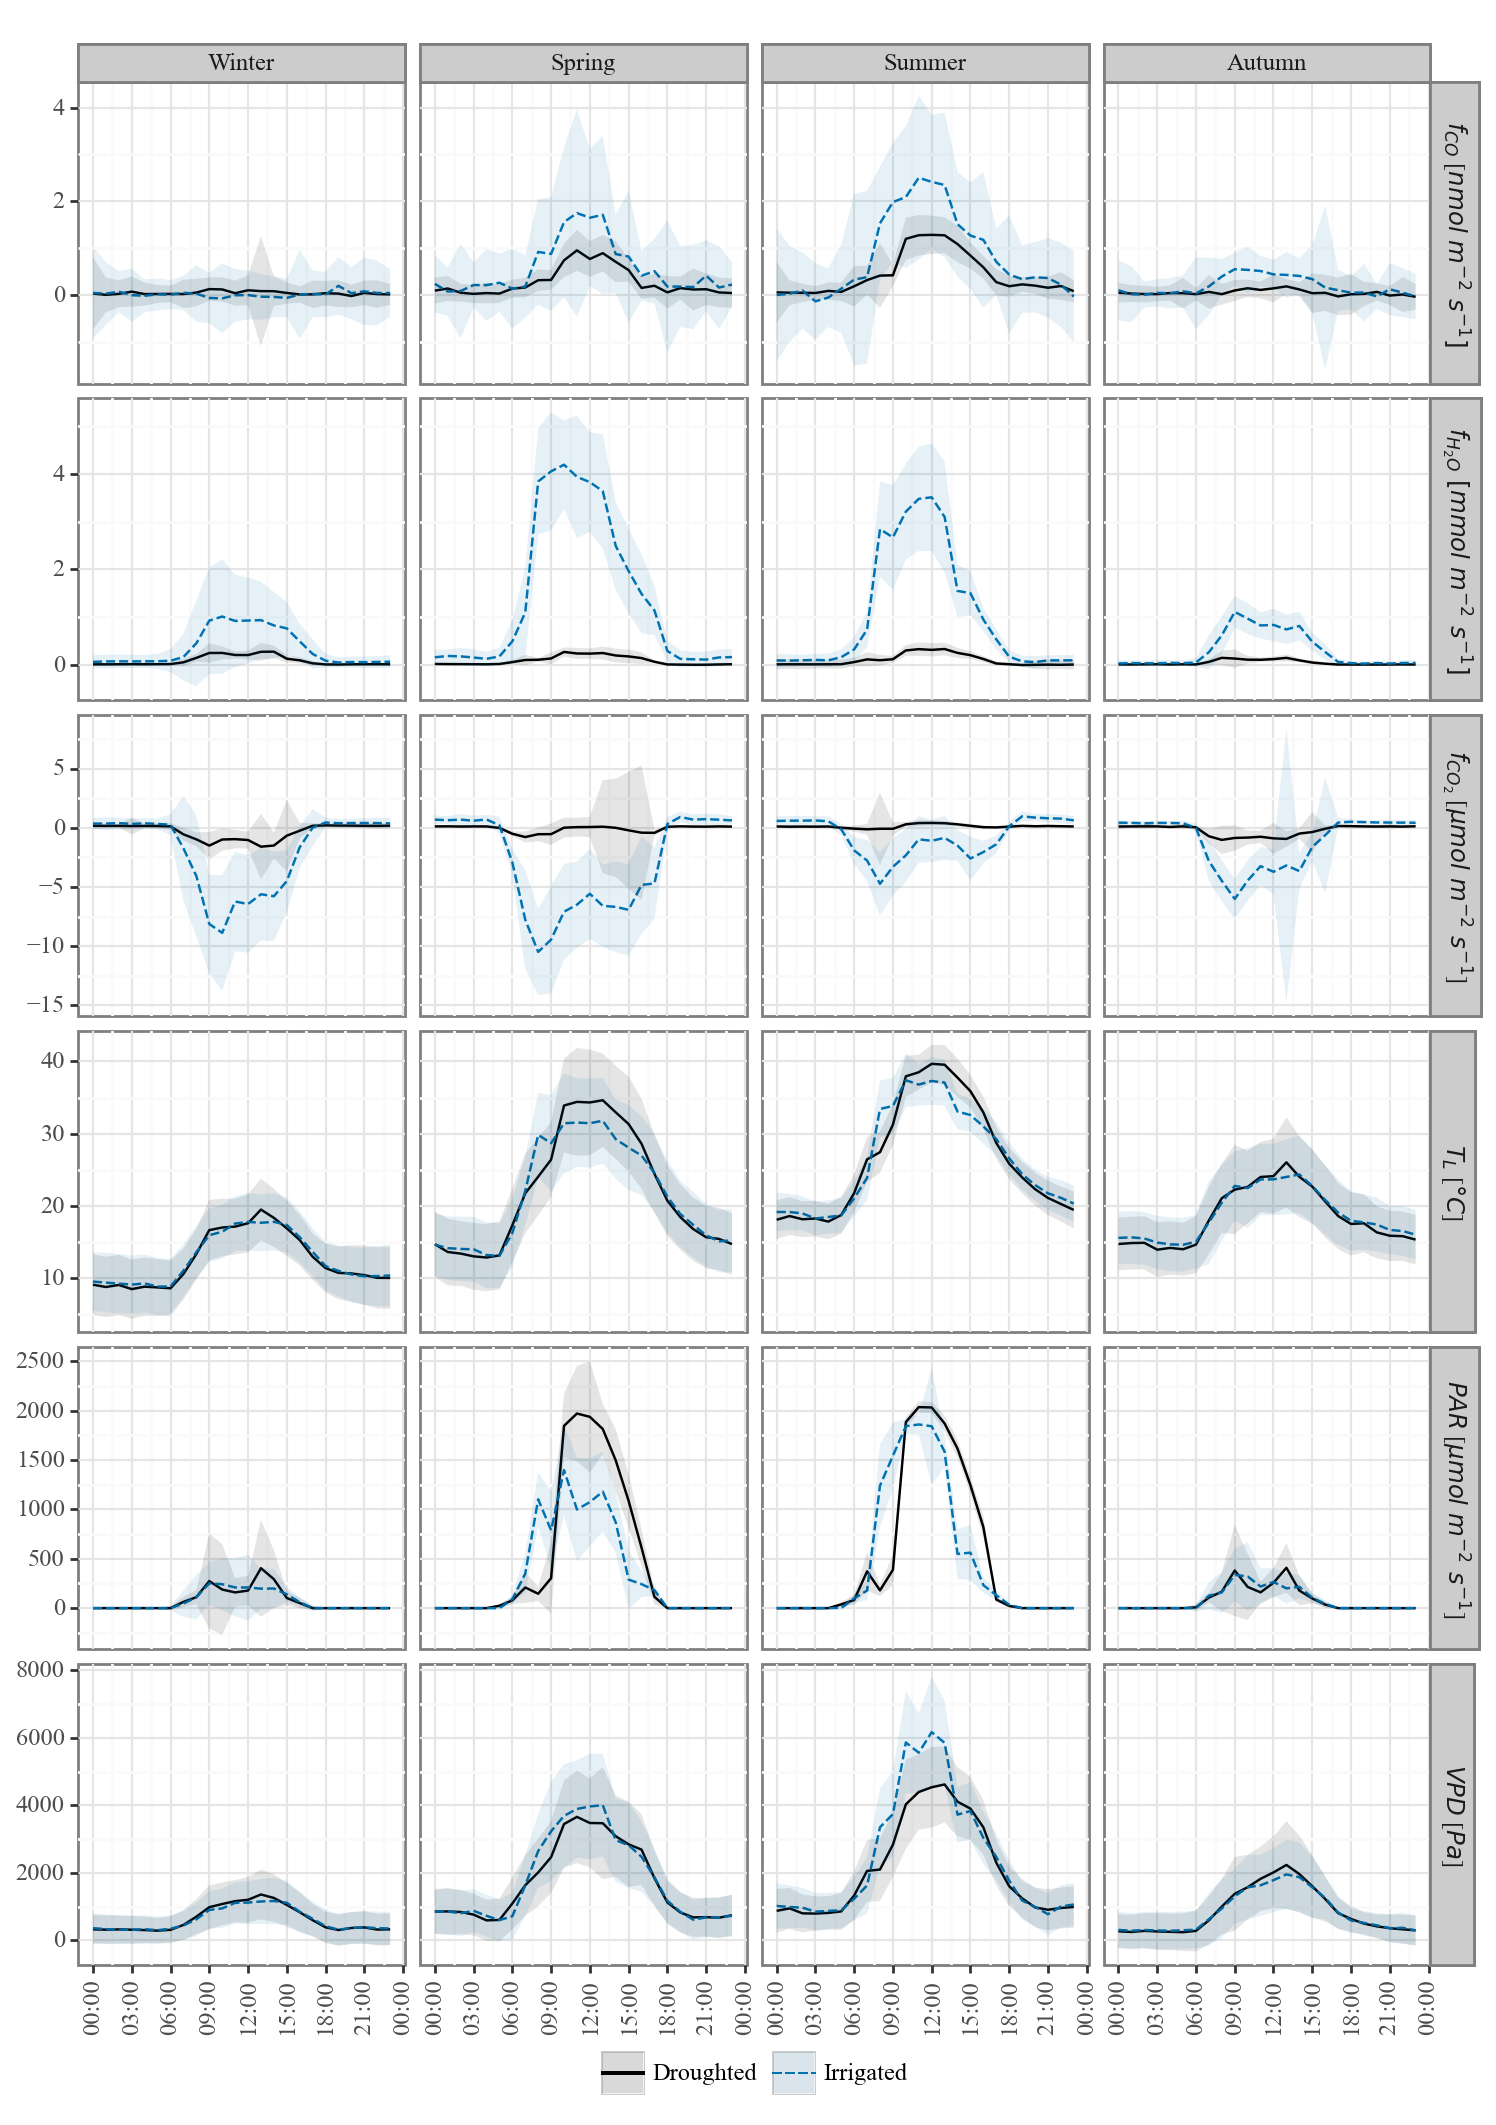

C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 19.0 x 27.000000000000004 cm image.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../graphs/02a_diurnal_flux_seasonal.png
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms\geom.py:289: FutureWarning: The defau

In [15]:
# Grid of CO vs parameters by season (Figure 2b)
#----------------------------------------------

# Colours
cbPalette = ['#000000', '#0072B2', '#E69F00', '#CC00CC', '#009E73', '#D55E00', '#CC79A7', '#FF3300', '#F0E442', '#56B4E9']

temp = df.loc[df['status'] == 'cc', ['timestamp', 'treatment', 'chamber','season','rain','hamsin',
                                     'flux.co.ch_oc.nmol_m2_s',
                                     'flux.h2o.ch_oc.mmol_m2_s',
                                     'flux.co2.ch_oc.umol_m2_s1',
                                     'temp.leaf.current.chamber.c.oc',
                                     'par.current.chamber.umol_m2_s1',
                                     'VPD.Pa.oc',
                                     #'g_tCO'
                                    ]]
# Remove now-obsolete columns
temp.drop(['rain','hamsin','chamber'], axis=1, inplace=True)

temp = temp.groupby(['treatment', 'season']).resample('1h', on='timestamp').mean()
temp = temp.reset_index()

# Convert wide to long
long = pd.melt(temp, id_vars=['timestamp','treatment','season'])
long['time']  = long['timestamp'].dt.strftime('%H:%M')
# Rename all columns
long.loc[long['variable'] == 'flux.co.ch_oc.nmol_m2_s', 'variable'] = '$f_{CO}$ [$nmol~m^{-2}~s^{-1}]$'
long.loc[long['variable'] == 'flux.h2o.ch_oc.mmol_m2_s', 'variable'] = '$f_{H_2 O}~ [mmol~m^{-2}~s^{-1}]$'
#long.loc[long['variable'] == 'g_tCO', 'variable'] = '$g_{t,CO}~ [mol~m^{-2}~s^{-1}]$'
long.loc[long['variable'] == 'flux.co2.ch_oc.umol_m2_s1', 'variable'] = '$f_{CO_2}$ [$\mu mol~m^{-2}~s^{-1}$]'
long.loc[long['variable'] == 'temp.leaf.current.chamber.c.oc', 'variable'] = '$T_L$ [$°C$]'
long.loc[long['variable'] == 'par.current.chamber.umol_m2_s1', 'variable'] = '$PAR$ [$\mu mol~m^{-2}~s^{-1}$]'
long.loc[long['variable'] == 'VPD.Pa.oc', 'variable'] = '$VPD$ [$Pa$]'
long['treatment'] = long['treatment'].str.replace('dro', 'Droughted')
long['treatment'] = long['treatment'].str.replace('irr', 'Irrigated')

grouped = long.groupby(['time','season','treatment','variable']).agg(['mean','median','std'])
# Reset index and rename columns
grouped = grouped.reset_index()
grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns.values]
grouped.columns = grouped.columns.str.replace('.', '_')

grouped['timestamp'] = pd.to_datetime(grouped['time'], format='%H:%M')

# Order columns
def order_cats(col, list_ordering):
    cat_dtype = pd.CategoricalDtype(categories=list_ordering, ordered=True)
    col = col.astype(cat_dtype)
    return(col)
grouped['season'] = order_cats(grouped['season'], list_ordering=['Winter','Spring','Summer','Autumn'])
#grouped['season'] = order_cats(grouped['season'], list_ordering=['wet','transition','dry'])
grouped['variable'] = order_cats(grouped['variable'], list_ordering=['$f_{CO}$ [$nmol~m^{-2}~s^{-1}]$',
                                                                     '$f_{H_2 O}~ [mmol~m^{-2}~s^{-1}]$',
                                                                     '$f_{CO_2}$ [$\mu mol~m^{-2}~s^{-1}$]',
                                                                     '$T_L$ [$°C$]',
                                                                     '$PAR$ [$\mu mol~m^{-2}~s^{-1}$]',
                                                                     '$VPD$ [$Pa$]',
                                                                     #'$g_{t,CO}~ [mol~m^{-2}~s^{-1}]$'
                                                                    ])

# Plot the diurnal
plt = ggplot(grouped)
plt = plt + geom_line(aes(x='timestamp', y='value_median', colour='treatment', linetype='treatment'), size=0.5)
plt = plt + geom_ribbon(aes(x='timestamp', ymin='value_median - value_std', ymax='value_median + value_std', fill='treatment'), alpha=0.1)
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + labs(x='Time of day', y='Flux', colour='Treatment', fill='Treatment', linetype='Treatment')
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), axis_title_x = element_blank(), axis_title_y = element_blank(),
                  text=element_text(family="serif"),
                  legend_box_spacing=0.01, legend_title = element_blank(), legend_position='bottom')
plt = plt + facet_grid('variable ~ season', scales='free_y')
plt = plt + theme(figure_size=(19/2.54, 27/2.54))
#plt = plt + coord_cartesian(ylim=[-2.0, 7.0])
plt = plt + scale_x_datetime(date_breaks = '3 hours', date_labels = '%H:%M')
print(plt)

plt.save(graphs_path + '02a_diurnal_flux_seasonal.png', width=19, height=27, units='cm', dpi=600)
plt.save(graphs_path + '02a_diurnal_flux_seasonal.pdf', width=19, height=27, units='cm', dpi=600)

C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms\geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms

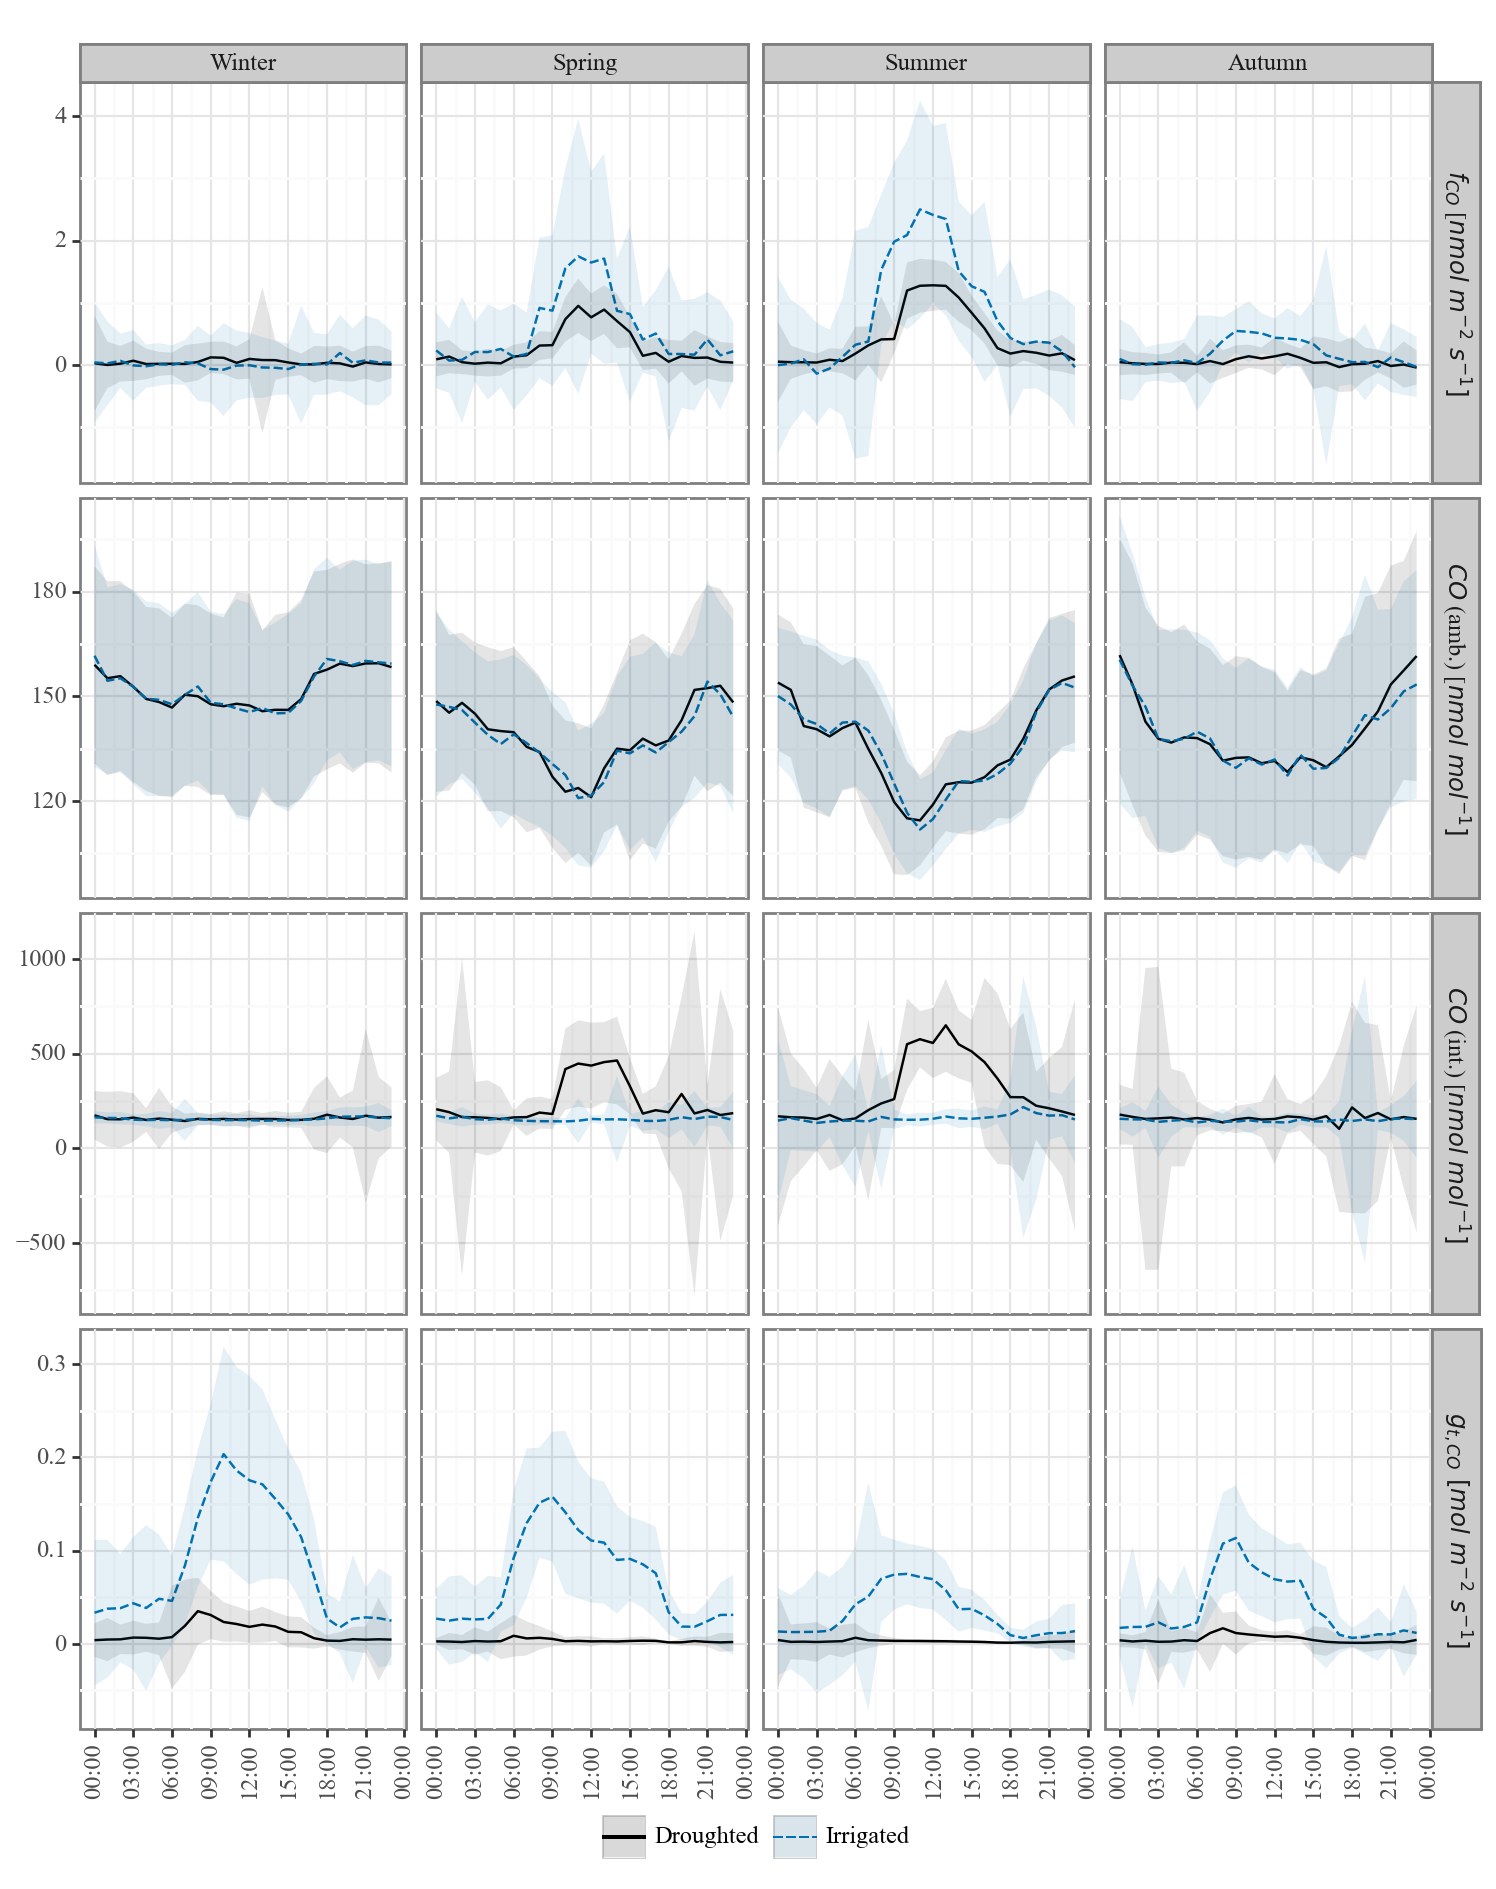

C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 19.0 x 24.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../graphs/02a_diurnal_concentrations_seasonal.png
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms\geom.py:289: FutureWarning: The default o

In [16]:
# Grid of CO vs concentrations by season
#-----------------------------------------

# Colours
cbPalette = ['#000000', '#0072B2', '#E69F00', '#CC00CC', '#009E73', '#D55E00', '#CC79A7', '#FF3300', '#F0E442', '#56B4E9']

temp = df.loc[df['status'] == 'cc', ['timestamp', 'treatment', 'chamber','season','rain','hamsin',
                                     'flux.co.ch_oc.nmol_m2_s',
                                     'conc.co.nmol_mol.oc.filtered.corrected',
                                     'conc_ci.co.nmol_mol',
                                     'g_tCO']].copy()

# Remove now-obsolete columns
temp.drop(['rain','hamsin','chamber'], axis=1, inplace=True)

temp = temp.groupby(['treatment', 'season']).resample('1h', on='timestamp').mean()
temp = temp.reset_index()

# Convert wide to long
long = pd.melt(temp, id_vars=['timestamp','treatment','season'])
long['time']  = long['timestamp'].dt.strftime('%H:%M')
# Rename all columns
long.loc[long['variable'] == 'flux.co.ch_oc.nmol_m2_s', 'variable'] = '$f_{CO}$ [$nmol~m^{-2}~s^{-1}]$'
long.loc[long['variable'] == 'conc.co.nmol_mol.oc.filtered.corrected', 'variable'] = '$CO$ (amb.) [$nmol~mol^{-1}]$'
long.loc[long['variable'] == 'conc_ci.co.nmol_mol', 'variable'] = '$CO$ (int.) [$nmol~mol^{-1}]$'
long.loc[long['variable'] == 'g_tCO', 'variable'] = '$g_{t,CO}~ [mol~m^{-2}~s^{-1}]$'

long['treatment'] = long['treatment'].str.replace('dro', 'Droughted')
long['treatment'] = long['treatment'].str.replace('irr', 'Irrigated')

grouped = long.groupby(['time','season','treatment','variable']).agg(['mean','median','std'])
# Reset index and rename columns
grouped = grouped.reset_index()
grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns.values]
grouped.columns = grouped.columns.str.replace('.', '_')

grouped['timestamp'] = pd.to_datetime(grouped['time'], format='%H:%M')

# Order columns
def order_cats(col, list_ordering):
    cat_dtype = pd.CategoricalDtype(categories=list_ordering, ordered=True)
    col = col.astype(cat_dtype)
    return(col)
grouped['season'] = order_cats(grouped['season'], list_ordering=['Winter','Spring','Summer','Autumn'])
grouped['variable'] = order_cats(grouped['variable'], list_ordering=['$f_{CO}$ [$nmol~m^{-2}~s^{-1}]$',
                                                                     '$CO$ (amb.) [$nmol~mol^{-1}]$',
                                                                     '$CO$ (int.) [$nmol~mol^{-1}]$',
                                                                     '$g_{t,CO}~ [mol~m^{-2}~s^{-1}]$'])

# Plot the diurnal
plt = ggplot(grouped)
plt = plt + geom_line(aes(x='timestamp', y='value_median', colour='treatment', linetype='treatment'), size=0.5)
plt = plt + geom_ribbon(aes(x='timestamp', ymin='value_median - value_std', ymax='value_median + value_std', fill='treatment'), alpha=0.1)
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + labs(x='Time of day', y='Flux', colour='Treatment', fill='Treatment', linetype='Treatment')
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), axis_title_x = element_blank(), axis_title_y = element_blank(),
                  text=element_text(family="serif"),
                  legend_box_spacing=0.01, legend_title = element_blank(), legend_position='bottom')
plt = plt + facet_grid('variable ~ season', scales='free_y')
plt = plt + theme(figure_size=(19/2.54, 24/2.54))
#plt = plt + coord_cartesian(ylim=[-2.0, 7.0])
plt = plt + scale_x_datetime(date_breaks = '3 hours', date_labels = '%H:%M')
print(plt)

plt.save(graphs_path + '02a_diurnal_concentrations_seasonal.png', width=19, height=24, units='cm', dpi=600)
plt.save(graphs_path + '02a_diurnal_concentrations_seasonal.pdf', width=19, height=24, units='cm', dpi=600)

C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms\geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms

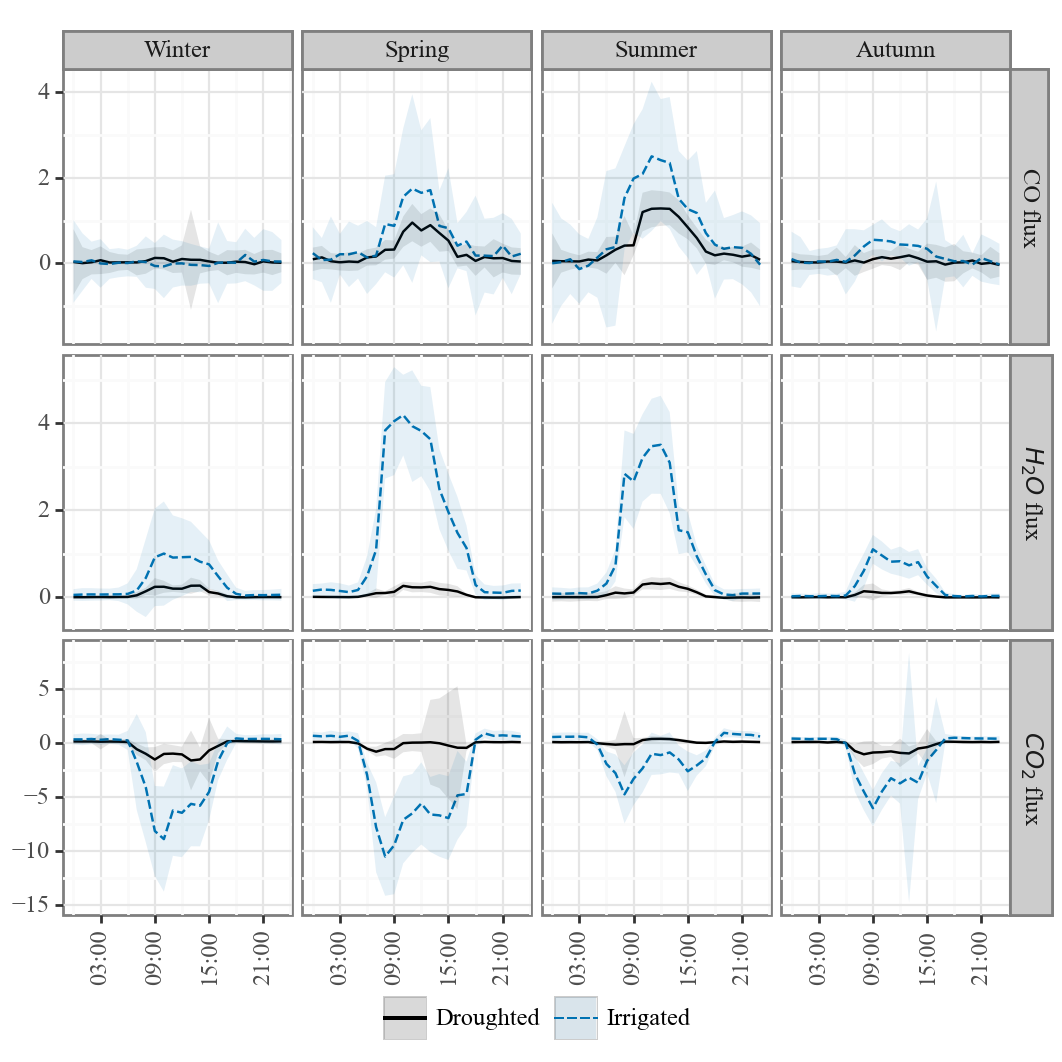

C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 13.500000000000002 x 13.500000000000002 cm image.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../graphs/presentationEGU/p02a1_diurnal_flux_seasonal.png
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms\geom.

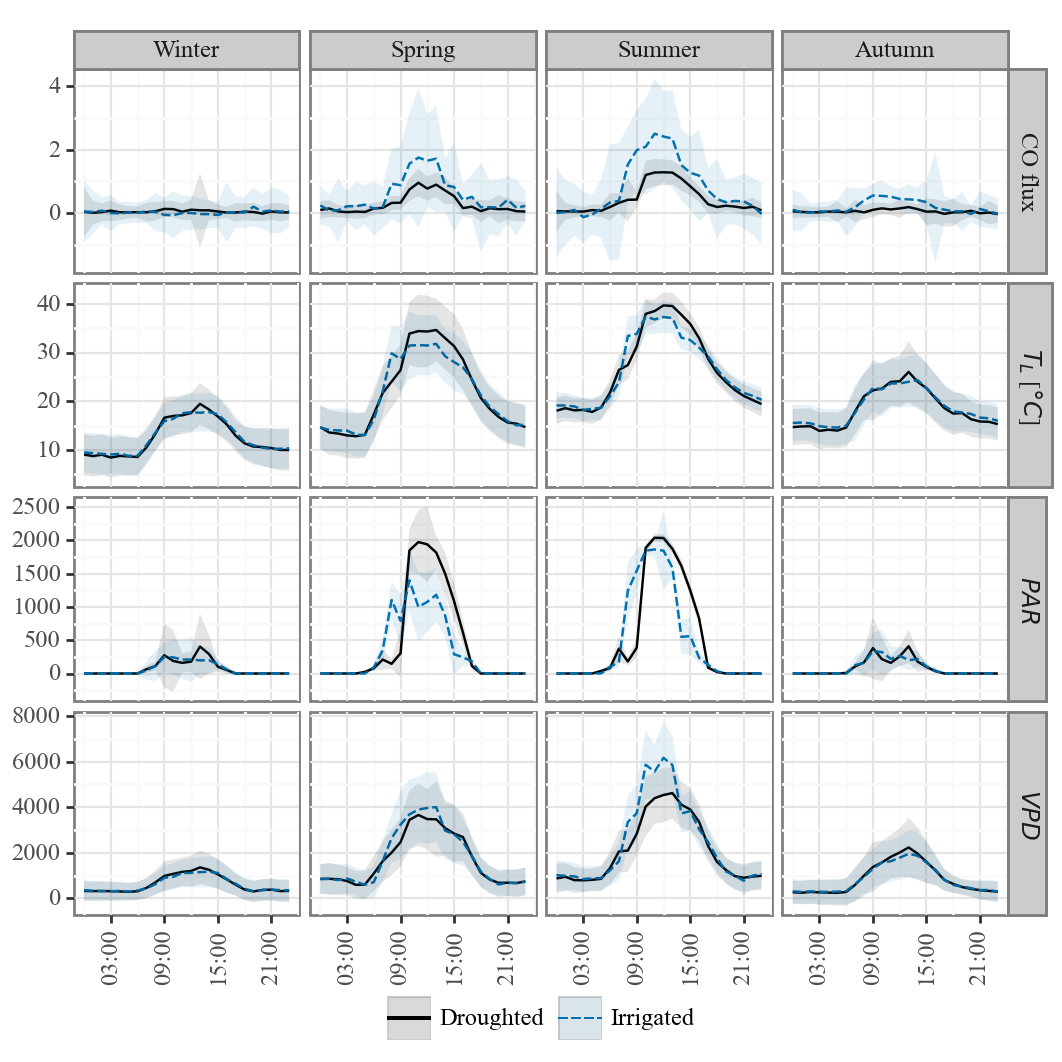

C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 13.500000000000002 x 13.500000000000002 cm image.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../graphs/presentationEGU/p02a2_diurnal_flux_seasonal.png
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms\geom.

In [11]:
# PRESENTATION EGU
#------------------

# Colours
cbPalette = ['#000000', '#0072B2', '#E69F00', '#CC00CC', '#009E73', '#D55E00', '#CC79A7', '#FF3300', '#F0E442', '#56B4E9']

temp = df.loc[df['status'] == 'cc', ['timestamp', 'treatment', 'chamber','season','rain','hamsin',
                                     'flux.co.ch_oc.nmol_m2_s',
                                     'flux.h2o.ch_oc.mmol_m2_s',
                                     'flux.co2.ch_oc.umol_m2_s1']]
# Remove now-obsolete columns
temp.drop(['rain','hamsin','chamber'], axis=1, inplace=True)

temp = temp.groupby(['treatment', 'season']).resample('1h', on='timestamp').mean()
temp = temp.reset_index()

# Convert wide to long
long = pd.melt(temp, id_vars=['timestamp','treatment','season'])
long['time']  = long['timestamp'].dt.strftime('%H:%M')
# Rename all columns
long.loc[long['variable'] == 'flux.co.ch_oc.nmol_m2_s', 'variable'] = 'CO flux'
long.loc[long['variable'] == 'flux.h2o.ch_oc.mmol_m2_s', 'variable'] = '$H_2 O$ flux'
long.loc[long['variable'] == 'flux.co2.ch_oc.umol_m2_s1', 'variable'] = '$CO_2$ flux'
long['treatment'] = long['treatment'].str.replace('dro', 'Droughted')
long['treatment'] = long['treatment'].str.replace('irr', 'Irrigated')

grouped = long.groupby(['time','season','treatment','variable']).agg(['mean','median','std'])
# Reset index and rename columns
grouped = grouped.reset_index()
grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns.values]
grouped.columns = grouped.columns.str.replace('.', '_')

grouped['timestamp'] = pd.to_datetime(grouped['time'], format='%H:%M')

# Order columns
def order_cats(col, list_ordering):
    cat_dtype = pd.CategoricalDtype(categories=list_ordering, ordered=True)
    col = col.astype(cat_dtype)
    return(col)
grouped['season'] = order_cats(grouped['season'], list_ordering=['Winter','Spring','Summer','Autumn'])
grouped['variable'] = order_cats(grouped['variable'], list_ordering=['CO flux',
                                                                     '$H_2 O$ flux',
                                                                     '$CO_2$ flux'])

# Plot the diurnal
plt = ggplot(grouped)
plt = plt + geom_line(aes(x='timestamp', y='value_median', colour='treatment', linetype='treatment'), size=0.5)
plt = plt + geom_ribbon(aes(x='timestamp', ymin='value_median - value_std', ymax='value_median + value_std', fill='treatment'), alpha=0.1)
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + labs(x='Time of day', y='Flux', colour='Treatment', fill='Treatment', linetype='Treatment')
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), axis_title_x = element_blank(), axis_title_y = element_blank(),
                  text=element_text(family="serif"),
                  legend_box_spacing=0.01, legend_title = element_blank(), legend_position='bottom')
plt = plt + facet_grid('variable ~ season', scales='free_y')
plt = plt + theme(figure_size=(13.5/2.54, 13.5/2.54))
plt = plt + scale_x_datetime(date_breaks = '6 hours', date_labels = '%H:%M')
print(plt)

plt.save(graphs_path + 'presentationEGU/p02a1_diurnal_flux_seasonal.png', width=13.5, height=13.5, units='cm', dpi=600)

#-------------------

cbPalette = ['#000000', '#0072B2', '#E69F00', '#CC00CC', '#009E73', '#D55E00', '#CC79A7', '#FF3300', '#F0E442', '#56B4E9']

temp = df.loc[df['status'] == 'cc', ['timestamp', 'treatment', 'chamber','season','rain','hamsin',
                                     'flux.co.ch_oc.nmol_m2_s',
                                     'par.current.chamber.umol_m2_s1',
                                     'temp.leaf.current.chamber.c.oc',
                                     'VPD.Pa.oc']]
# Remove now-obsolete columns
temp.drop(['rain','hamsin','chamber'], axis=1, inplace=True)

temp = temp.groupby(['treatment', 'season']).resample('1h', on='timestamp').mean()
temp = temp.reset_index()

# Convert wide to long
long = pd.melt(temp, id_vars=['timestamp','treatment','season'])
long['time']  = long['timestamp'].dt.strftime('%H:%M')
# Rename all columns
long.loc[long['variable'] == 'flux.co.ch_oc.nmol_m2_s', 'variable'] = 'CO flux'
long.loc[long['variable'] == 'temp.leaf.current.chamber.c.oc', 'variable'] = '$T_L$ [$°C$]'
long.loc[long['variable'] == 'par.current.chamber.umol_m2_s1', 'variable'] = '$PAR$'
long.loc[long['variable'] == 'g_tCO', 'variable'] = 'CO cond.'
long.loc[long['variable'] == 'VPD.Pa.oc', 'variable'] = '$VPD$'
long['treatment'] = long['treatment'].str.replace('dro', 'Droughted')
long['treatment'] = long['treatment'].str.replace('irr', 'Irrigated')

grouped = long.groupby(['time','season','treatment','variable']).agg(['mean','median','std'])
# Reset index and rename columns
grouped = grouped.reset_index()
grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns.values]
grouped.columns = grouped.columns.str.replace('.', '_')

grouped['timestamp'] = pd.to_datetime(grouped['time'], format='%H:%M')

# Order columns
def order_cats(col, list_ordering):
    cat_dtype = pd.CategoricalDtype(categories=list_ordering, ordered=True)
    col = col.astype(cat_dtype)
    return(col)
grouped['season'] = order_cats(grouped['season'], list_ordering=['Winter','Spring','Summer','Autumn'])
grouped['variable'] = order_cats(grouped['variable'], list_ordering=['CO flux',
                                                                     '$T_L$ [$°C$]',
                                                                     '$PAR$',
                                                                     '$VPD$'])

# Plot the diurnal
plt = ggplot(grouped)
plt = plt + geom_line(aes(x='timestamp', y='value_median', colour='treatment', linetype='treatment'), size=0.5)
plt = plt + geom_ribbon(aes(x='timestamp', ymin='value_median - value_std', ymax='value_median + value_std', fill='treatment'), alpha=0.1)
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + labs(x='Time of day', y='Flux', colour='Treatment', fill='Treatment', linetype='Treatment')
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), axis_title_x = element_blank(), axis_title_y = element_blank(),
                  text=element_text(family="serif"),
                  legend_box_spacing=0.01, legend_title = element_blank(), legend_position='bottom')
plt = plt + facet_grid('variable ~ season', scales='free_y')
plt = plt + theme(figure_size=(13.5/2.54, 13.5/2.54))
plt = plt + scale_x_datetime(date_breaks = '6 hours', date_labels = '%H:%M')
print(plt)

plt.save(graphs_path + 'presentationEGU/p02a2_diurnal_flux_seasonal.png', width=13.5, height=13.5, units='cm', dpi=600)

C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms\geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms

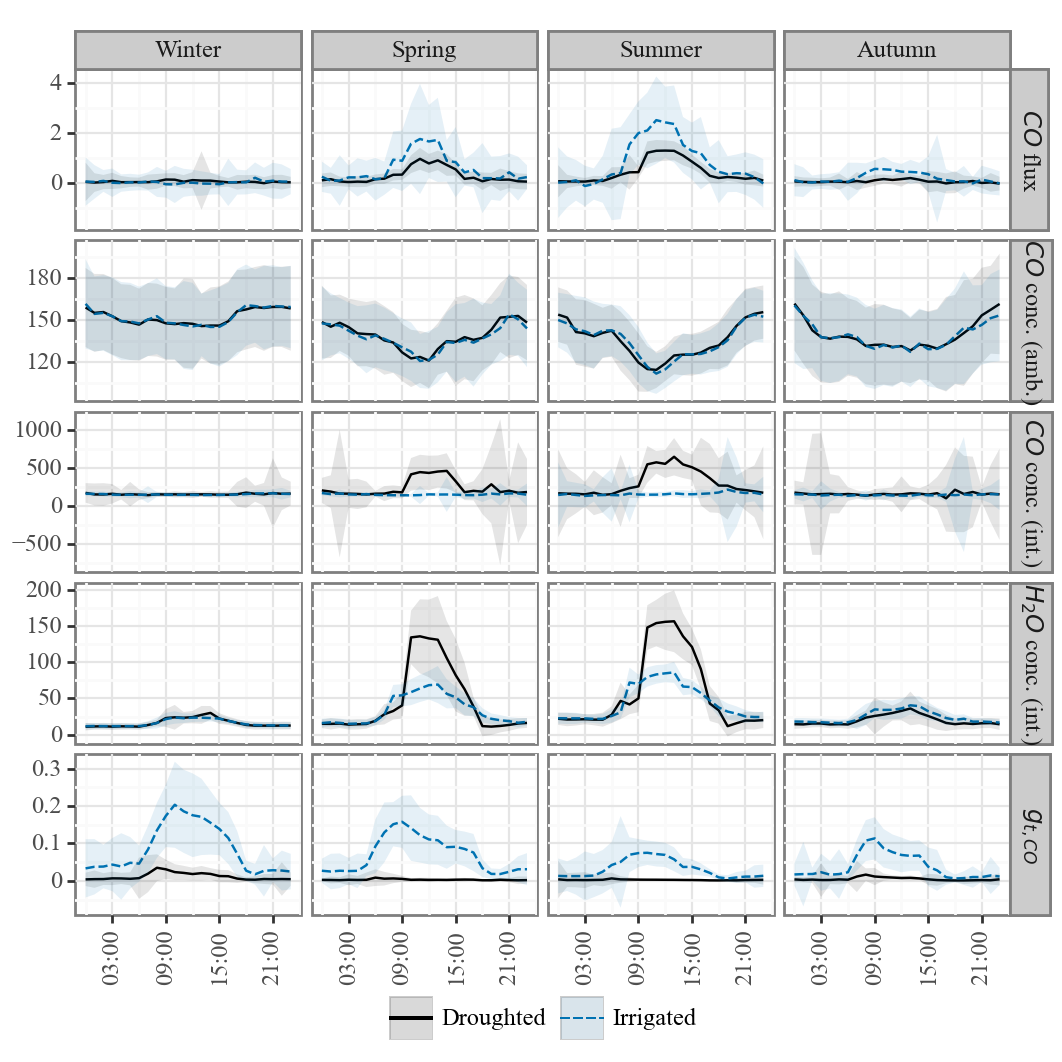

C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 13.500000000000002 x 13.500000000000002 cm image.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../graphs/presentationEGU/p02a_diurnal_concentrations_seasonal.png
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ge

In [12]:
# Presentation EGU
#-------------------

temp = df.loc[df['status'] == 'cc', ['timestamp', 'treatment', 'chamber','season','rain','hamsin',
                                     'flux.co.ch_oc.nmol_m2_s',
                                     'conc.co.nmol_mol.oc.filtered.corrected',
                                     'conc_ci.co.nmol_mol',
                                     'conc_ci.h2o.mmol_mol',
                                     'g_tCO']].copy()

# Remove now-obsolete columns
temp.drop(['rain','hamsin','chamber'], axis=1, inplace=True)

temp = temp.groupby(['treatment', 'season']).resample('1h', on='timestamp').mean()
temp = temp.reset_index()

# Convert wide to long
long = pd.melt(temp, id_vars=['timestamp','treatment','season'])
long['time']  = long['timestamp'].dt.strftime('%H:%M')
# Rename all columns
long.loc[long['variable'] == 'flux.co.ch_oc.nmol_m2_s', 'variable'] = '$CO$ flux'
long.loc[long['variable'] == 'conc.co.nmol_mol.oc.filtered.corrected', 'variable'] = '$CO$ conc. (amb.)'
long.loc[long['variable'] == 'conc_ci.co.nmol_mol', 'variable'] = '$CO$ conc. (int.)'
long.loc[long['variable'] == 'conc_ci.h2o.mmol_mol', 'variable'] = '$H_2 O$ conc. (int.)'
long.loc[long['variable'] == 'g_tCO', 'variable'] = '$g_{t,CO}$'

long['treatment'] = long['treatment'].str.replace('dro', 'Droughted')
long['treatment'] = long['treatment'].str.replace('irr', 'Irrigated')

grouped = long.groupby(['time','season','treatment','variable']).agg(['mean','median','std'])
# Reset index and rename columns
grouped = grouped.reset_index()
grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns.values]
grouped.columns = grouped.columns.str.replace('.', '_')

grouped['timestamp'] = pd.to_datetime(grouped['time'], format='%H:%M')

# Order columns
def order_cats(col, list_ordering):
    cat_dtype = pd.CategoricalDtype(categories=list_ordering, ordered=True)
    col = col.astype(cat_dtype)
    return(col)
grouped['season'] = order_cats(grouped['season'], list_ordering=['Winter','Spring','Summer','Autumn'])
grouped['variable'] = order_cats(grouped['variable'], list_ordering=['$CO$ flux',
                                                                     '$CO$ conc. (amb.)',
                                                                     '$CO$ conc. (int.)',
                                                                     '$H_2 O$ conc. (int.)',
                                                                     '$g_{t,CO}$'])


# Plot the diurnal
plt = ggplot(grouped)
plt = plt + geom_line(aes(x='timestamp', y='value_median', colour='treatment', linetype='treatment'), size=0.5)
plt = plt + geom_ribbon(aes(x='timestamp', ymin='value_median - value_std', ymax='value_median + value_std', fill='treatment'), alpha=0.1)
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + labs(x='Time of day', y='Flux', colour='Treatment', fill='Treatment', linetype='Treatment')
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), axis_title_x = element_blank(), axis_title_y = element_blank(),
                  text=element_text(family="serif"),
                  legend_box_spacing=0.01, legend_title = element_blank(), legend_position='bottom')
plt = plt + facet_grid('variable ~ season', scales='free_y')
plt = plt + theme(figure_size=(13.5/2.54, 13.5/2.54))
plt = plt + scale_x_datetime(date_breaks = '6 hours', date_labels = '%H:%M')
print(plt)

plt.save(graphs_path + 'presentationEGU/p02a_diurnal_concentrations_seasonal.png', width=13.5, height=13.5, units='cm', dpi=600)

Difference between treatments
Hot months, P = <.001
    Droughted: 1.11 ± 0.32
    Irrigated: 2.5 ± 1.17
Cool months, P = <.001
    Droughted: 0.06 ± 0.58
    Irrigated: 0.22 ± 0.45


C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms\geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms

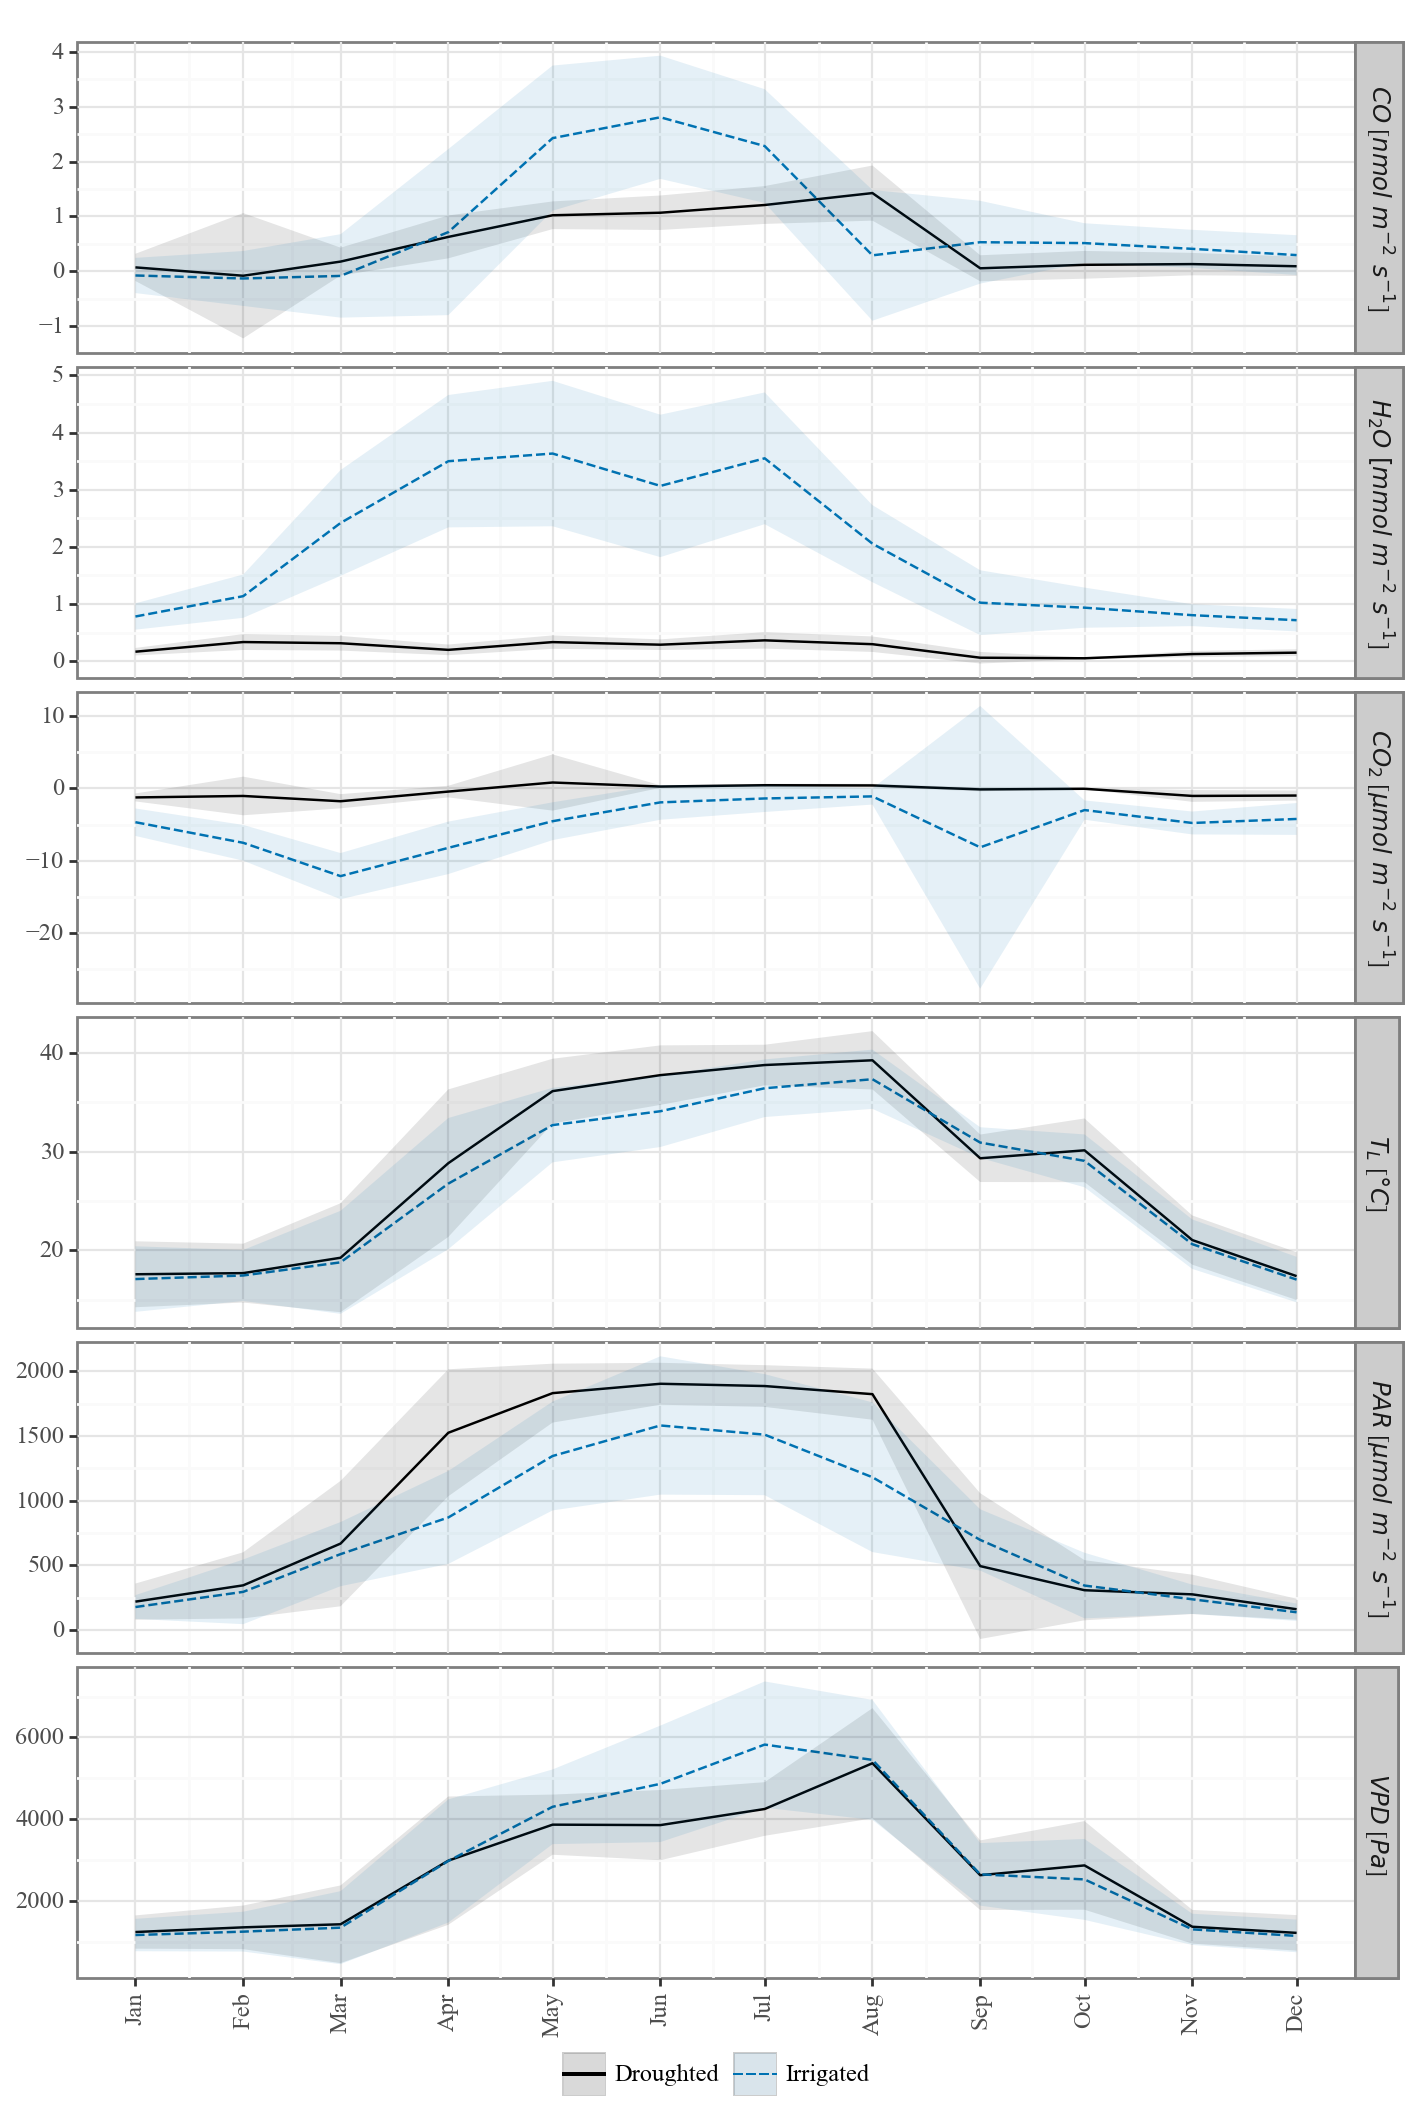

C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 18.0 x 27.000000000000004 cm image.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../graphs/02a_flux_monthly.png
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms\geom.py:289: FutureWarning: The default of obs

In [13]:
# Monthly data
def pvalue_text(p):
    if(p <= 0.001): p_text = '<.001'
    if(p > 0.001): p_text = '<.01'
    if(p > 0.01): p_text = '<.05'
    if(p > 0.05): p_text = p.round(2).astype(str)
    return(p_text)

temp = df.loc[df['status'] == 'cc', ['timestamp', 'treatment', 'chamber','season','rain','hamsin',
                                     'flux.co.ch_oc.nmol_m2_s',
                                     'flux.co2.ch_oc.umol_m2_s1',
                                     'flux.h2o.ch_oc.mmol_m2_s',
                                     'temp.leaf.current.chamber.c.oc',
                                     'par.current.chamber.umol_m2_s1',
                                     'VPD.Pa.oc']]
# Remove now-obsolete columns
temp.drop(['rain','hamsin','chamber'], axis=1, inplace=True)


temp['month'] = temp['timestamp'].dt.strftime('%m').astype(int)
midday = temp.loc[(temp['timestamp'].dt.hour >= 10) & (temp['timestamp'].dt.hour < 15), ['month','treatment',
                                                                                         'flux.co.ch_oc.nmol_m2_s',
                                                                                         'flux.h2o.ch_oc.mmol_m2_s',
                                                                                         'flux.co2.ch_oc.umol_m2_s1',
                                                                                         'temp.leaf.current.chamber.c.oc',
                                                                                         'par.current.chamber.umol_m2_s1',
                                                                                         'VPD.Pa.oc']]
midday.rename({'flux.co.ch_oc.nmol_m2_s': 'flux_co'}, axis=1, inplace=True)
midday.rename({'temp.leaf.current.chamber.c.oc': 'TL'}, axis=1, inplace=True)
midday2 = pd.melt(midday, id_vars=['month','treatment'])
grouped = midday2.groupby(['month','treatment','variable']).agg(['mean','median','std']).reset_index()
grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns.values]
grouped['timestamp'] = pd.to_datetime(grouped['month'], format='%m')
grouped['treatment'] = grouped['treatment'].str.replace('dro', 'Droughted')
grouped['treatment'] = grouped['treatment'].str.replace('irr', 'Irrigated')

print('Difference between treatments')
# Hot months, statistical differences
a = midday.loc[(midday['month'].isin([5,6,7])) & (midday['treatment'] == 'dro') & (~midday['flux_co'].isna()),'flux_co']
b = midday.loc[(midday['month'].isin([5,6,7])) & (midday['treatment'] == 'irr') & (~midday['flux_co'].isna()),'flux_co']
t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
print('Hot months, P =', pvalue_text(t[1]))
print('    Droughted:', np.round(np.mean(a),2), '±', np.round(np.std(a),2))
print('    Irrigated:', np.round(np.mean(b),2), '±', np.round(np.std(b),2))

# Hot months, statistical differences
a = midday.loc[(midday['month'].isin([10,11,12,1,2])) & (midday['treatment'] == 'dro') & (~midday['flux_co'].isna()),'flux_co']
b = midday.loc[(midday['month'].isin([10,11,12,1,2])) & (midday['treatment'] == 'irr') & (~midday['flux_co'].isna()),'flux_co']
t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
print('Cool months, P =', pvalue_text(t[1]))
print('    Droughted:', np.round(np.mean(a),2), '±', np.round(np.std(a),2))
print('    Irrigated:', np.round(np.mean(b),2), '±', np.round(np.std(b),2))

#grouped.loc[grouped['variable'] == 't_air', 'variable'] = '$T_{air}$ [$°C$]'
#grouped.loc[grouped['variable'] == 'flux_co', 'variable'] = 'CO flux [$nmol~m^{-2}~s^{-1}$]'
#grouped.loc[grouped['variable'] == 'par.current.chamber.umol_m2_s1', 'variable'] = 'PAR [$\mu mol~m^{-2}~s^{-1}$]'
#grouped.loc[grouped['variable'] == 'VPD.Pa', 'variable'] = 'VPD [$Pa$]'
#
grouped.loc[grouped['variable'] == 'flux_co', 'variable'] = '$CO$ [$nmol~m^{-2}~s^{-1}$]'
grouped.loc[grouped['variable'] == 'flux.h2o.ch_oc.mmol_m2_s', 'variable'] = '$H_2 O~ [mmol~m^{-2}~s^{-1}$]'
grouped.loc[grouped['variable'] == 'flux.co2.ch_oc.umol_m2_s1', 'variable'] = '$CO_2$ [$\mu mol~m^{-2}~s^{-1}$]'
grouped.loc[grouped['variable'] == 'TL', 'variable'] = '$T_L$ [$°C$]'
grouped.loc[grouped['variable'] == 'par.current.chamber.umol_m2_s1', 'variable'] = '$PAR$ [$\mu mol~m^{-2}~s^{-1}$]'
grouped.loc[grouped['variable'] == 'VPD.Pa.oc', 'variable'] = '$VPD$ [$Pa$]'

grouped['variable'] = order_cats(grouped['variable'], list_ordering=['$CO$ [$nmol~m^{-2}~s^{-1}$]',
                                                                     '$H_2 O~ [mmol~m^{-2}~s^{-1}$]',
                                                                     '$CO_2$ [$\mu mol~m^{-2}~s^{-1}$]',
                                                                     '$T_L$ [$°C$]',
                                                                     '$PAR$ [$\mu mol~m^{-2}~s^{-1}$]',
                                                                     '$VPD$ [$Pa$]'])

plt = ggplot(grouped)
plt = plt + geom_line(aes(x='timestamp', y='value_mean', colour='treatment', linetype='treatment'), size=0.5)
plt = plt + geom_ribbon(aes(x='timestamp', ymin='value_mean - value_std', ymax='value_mean + value_std', fill='treatment'), alpha=0.1)
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), axis_title_x = element_blank(), axis_title_y = element_blank(),
                  text=element_text(family="serif"),
                  legend_box_spacing=0.01, legend_title = element_blank(), legend_position='bottom')
plt = plt + theme(figure_size=(18/2.54, 27/2.54))
#plt = plt + coord_cartesian(ylim=[-2.0, 7.0])
plt = plt + scale_x_datetime(date_breaks = '1 month', date_labels = '%b')
plt = plt + facet_grid('variable ~', scales='free_y')
print(plt)

plt.save(graphs_path + '02a_flux_monthly.png', width=18, height=27, units='cm', dpi=600)
plt.save(graphs_path + '02a_flux_monthly.pdf', width=18, height=27, units='cm', dpi=600)

### Boxplots

C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms\geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\guide

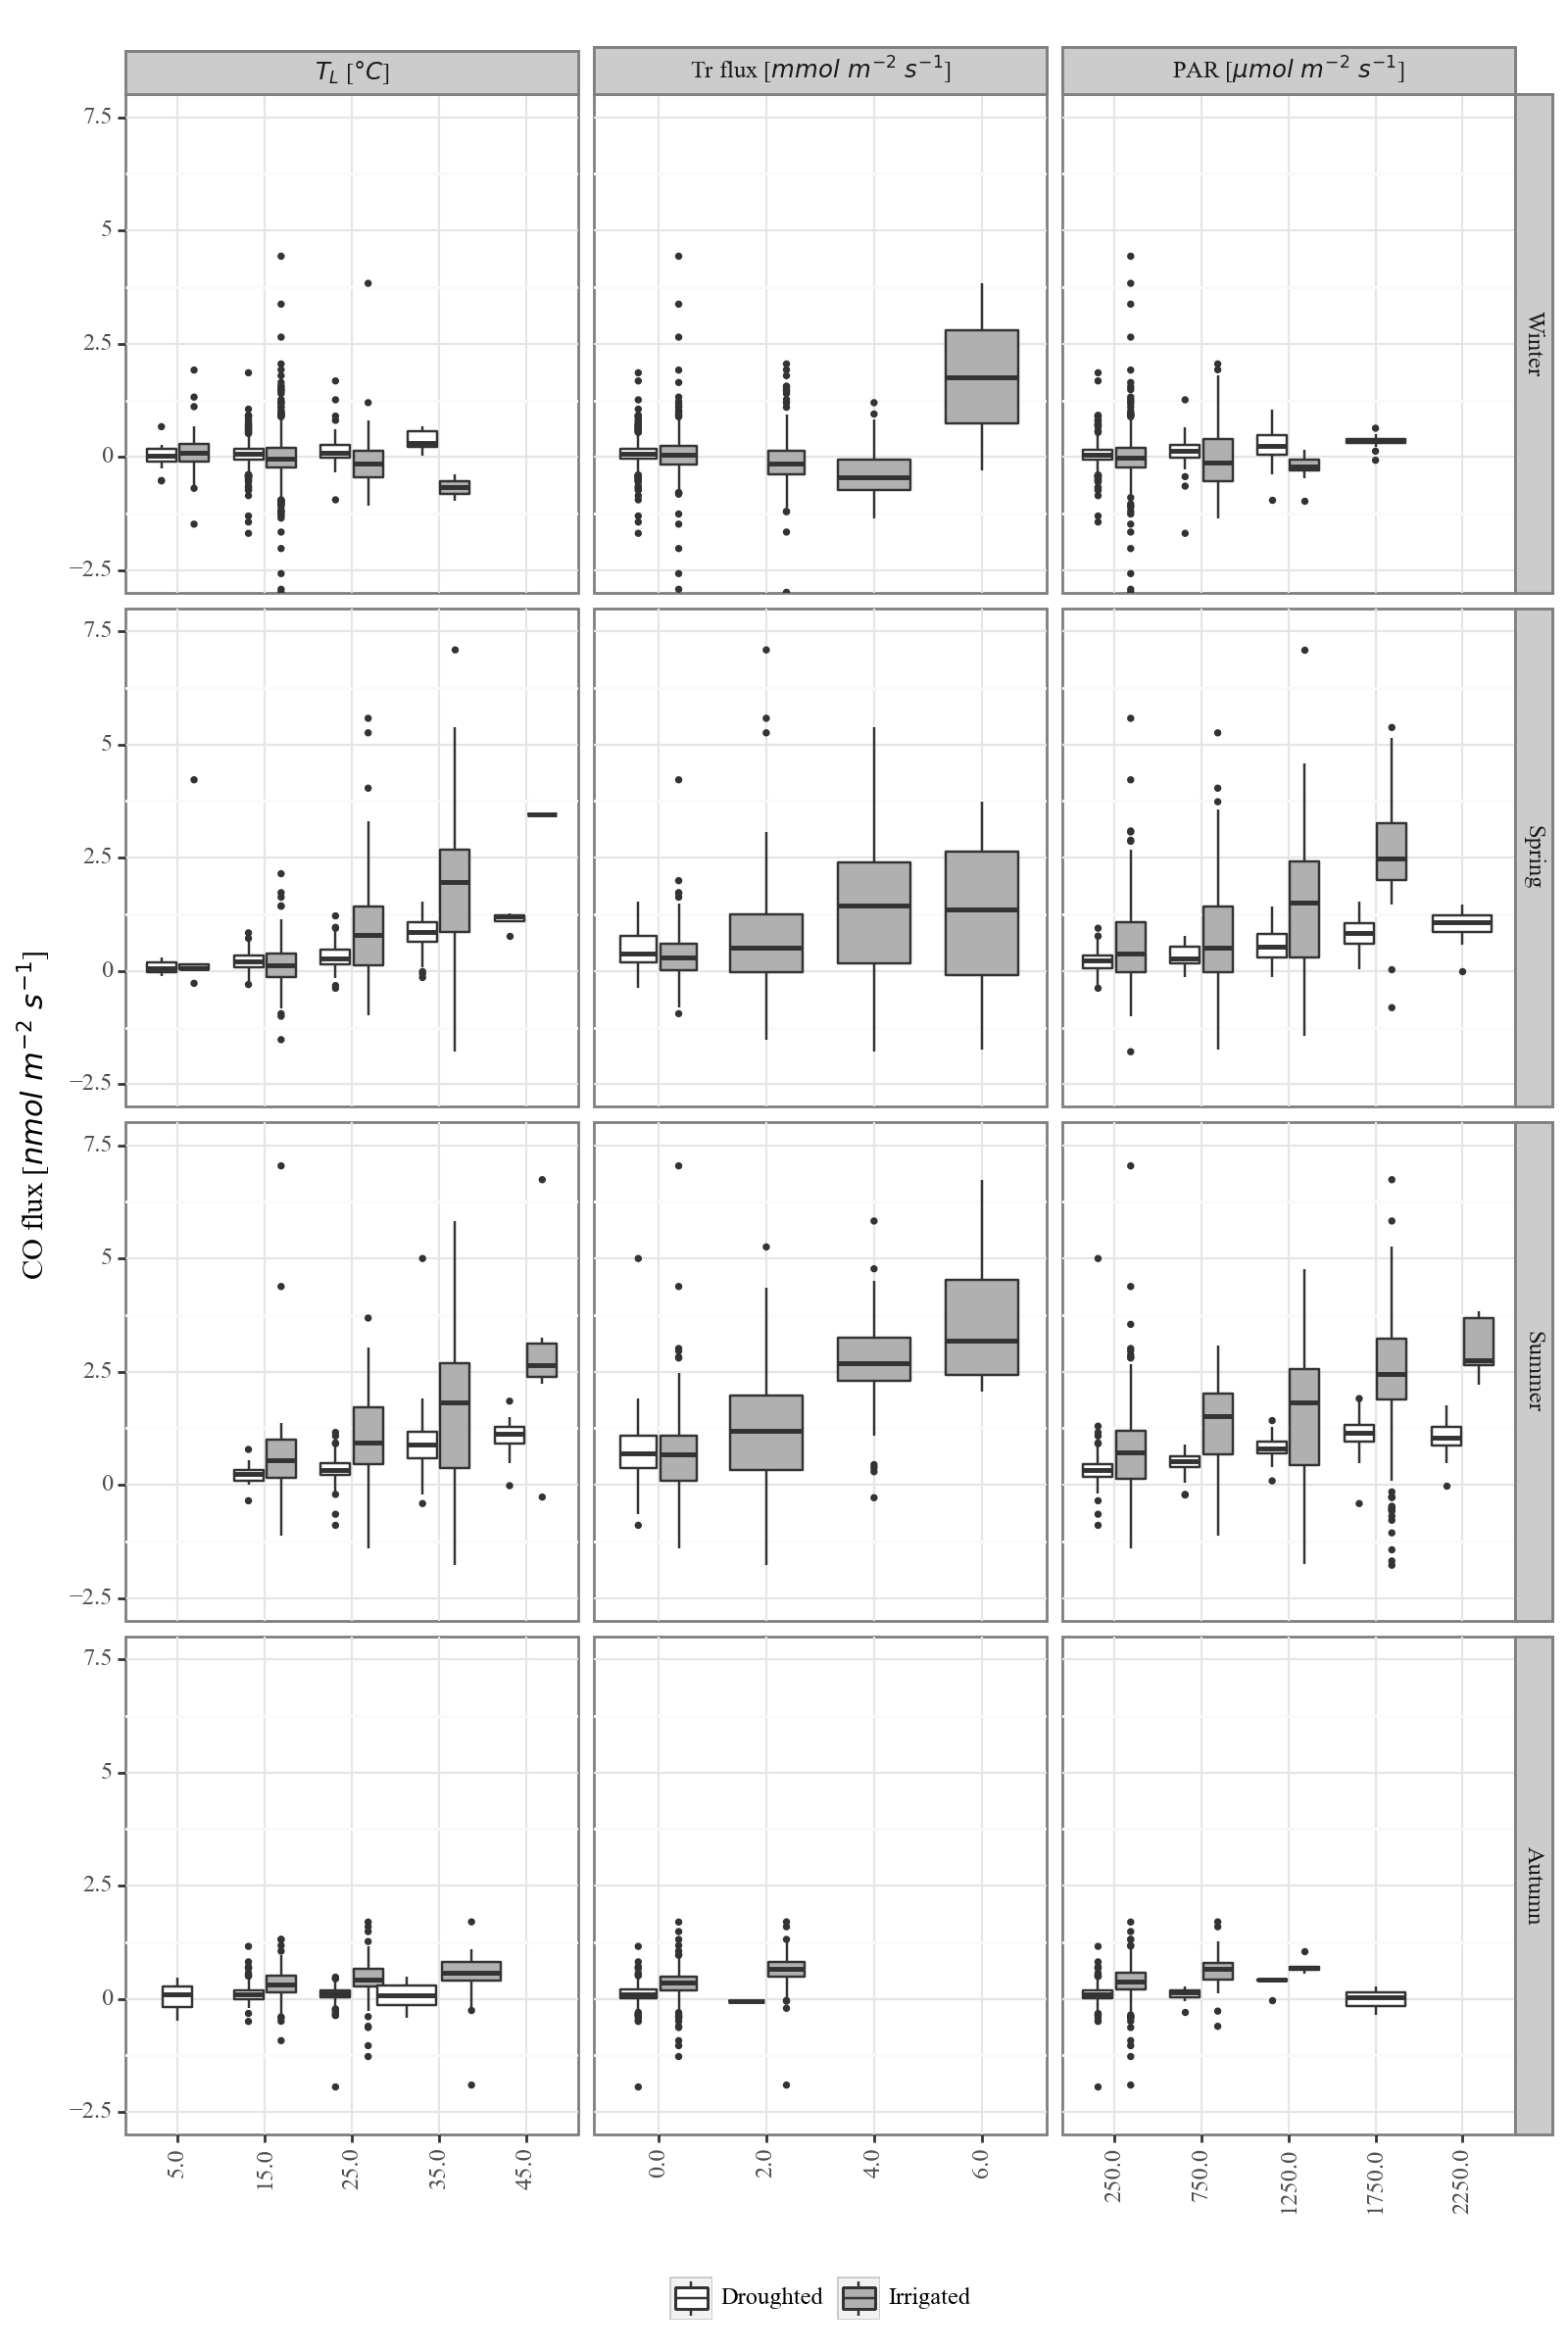

C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 19.200000000000003 x 19.200000000000003 cm image.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../graphs/02b_boxplot_var_seasonal.png
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms\geom.py:289: FutureWarni

In [17]:
temp = df.copy()
temp = df.loc[df['par.current.chamber.umol_m2_s1'] > 50].copy()
temp['treatment'] = temp['treatment'].str.replace('dro', 'Droughted')
temp['treatment'] = temp['treatment'].str.replace('irr', 'Irrigated')

# PAR
temp2 = temp.copy()
temp2.dropna(subset=['flux.co.ch_oc.nmol_m2_s','par.current.chamber.umol_m2_s1'], inplace=True)
temp2['bins'] = bin_variable(temp2['par.current.chamber.umol_m2_s1'], 500)
long_par = temp2[['treatment','season','flux.co.ch_oc.nmol_m2_s','bins']].melt(id_vars=['treatment','season','bins'])
long_par['variable'] = 'PAR [$\mu mol~m^{-2}~s^{-1}$]'

# VPD
temp2 = temp.copy()
temp2['VPD.kPa'] = temp2['VPD.Pa.oc']/1000
temp2.dropna(subset=['flux.co.ch_oc.nmol_m2_s','VPD.kPa'], inplace=True)
temp2['bins'] = bin_variable(temp2['VPD.kPa'], 2)
long_vpd = temp2[['treatment','season','flux.co.ch_oc.nmol_m2_s','bins']].melt(id_vars=['treatment','season','bins'])
long_vpd['variable'] = 'VPD [$kPa$]'

# T_air
#temp2 = temp.copy()
#temp2.dropna(subset=['flux.co.ch_oc.nmol_m2_s','temp.air.current.chamber.c'], inplace=True)
#temp2['bins'] = bin_variable(temp2['temp.air.current.chamber.c'], 10)
#long_ta = temp2[['treatment','season','flux.co.ch_oc.nmol_m2_s','bins']].melt(id_vars=['treatment','season','bins'])
#long_ta['variable'] = '$T_{air}$ [$°C$]'

# T_leaf
temp2 = temp.copy()
temp2.dropna(subset=['flux.co.ch_oc.nmol_m2_s','temp.leaf.current.chamber.c.oc'], inplace=True)
temp2['bins'] = bin_variable(temp2['temp.leaf.current.chamber.c.oc'], 10)
long_tl = temp2[['treatment','season','flux.co.ch_oc.nmol_m2_s','bins']].melt(id_vars=['treatment','season','bins'])
long_tl['variable'] = '$T_L$ [$°C$]'

# H2O flux
temp2 = temp.copy()
temp2.dropna(subset=['flux.co.ch_oc.nmol_m2_s','flux.h2o.ch_oc.mmol_m2_s'], inplace=True)
temp2['bins'] = bin_variable(temp2['flux.h2o.ch_oc.mmol_m2_s'], 2)
long_h2o = temp2[['treatment','season','flux.co.ch_oc.nmol_m2_s','bins']].melt(id_vars=['treatment','season','bins'])
long_h2o['variable'] = 'Tr flux [$mmol~m^{-2}~s^{-1}$]'
#long_h2o = long_h2o.loc[long_h2o['bins'].astype(float) < 3]

# g_tw total branch conductance
temp2 = temp.copy()
temp2['g_tCO'] = np.abs(temp2['g_tCO'])
temp2.dropna(subset=['flux.co.ch_oc.nmol_m2_s','g_tCO'], inplace=True)
temp2['bins'] = bin_variable(temp2['g_tw']*1000, 50)
long_gtw = temp2[['treatment','season','flux.co.ch_oc.nmol_m2_s','bins']].melt(id_vars=['treatment','season','bins'])
long_gtw['variable'] = '$g_{t,CO}~ [mol~m^{-2}~s^{-1}]$'

# SWC
temp2 = temp.copy()
temp2.dropna(subset=['flux.co.ch_oc.nmol_m2_s','swc_10_30cm'], inplace=True)
temp2['bins'] = bin_variable(temp2['swc_10_30cm'], 5)
long_swc = temp2[['treatment','season','flux.co.ch_oc.nmol_m2_s','bins']].melt(id_vars=['treatment','season','bins'])
long_swc['variable'] = 'SWC 10-30cm [%]'

# Merge
long_merged = pd.concat([long_tl, long_h2o, long_par])
#long_merged = pd.concat([long_par, long_tl, long_gtw])
long_merged['bins'] = long_merged['bins'].astype(float)
category_list = np.sort(long_merged['bins'].unique())
long_merged['bins'] = order_cats(long_merged['bins'], list_ordering=category_list) # Order bins

# Order seasons
long_merged['season'] = order_cats(long_merged['season'], list_ordering=['Winter','Spring','Summer','Autumn'])
long_merged['variable'] = order_cats(long_merged['variable'], list_ordering=['$T_L$ [$°C$]', 'Tr flux [$mmol~m^{-2}~s^{-1}$]', 'PAR [$\\mu mol~m^{-2}~s^{-1}$]'])

plt = ggplot(long_merged)
plt = plt + theme_bw()
plt = plt + geom_boxplot(aes(x='bins', y='value', fill='treatment'), outlier_size=0.5)
plt = plt + labs(x='', y='CO flux [$nmol~m^{-2}~s^{-1}$]', fill='')
plt = plt + facet_grid('season ~ variable', scales='free_x')
plt = plt + scale_colour_manual(values=bwPalette) + scale_fill_manual(values=bwPalette)
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5),
                  legend_title=element_blank(), #legend_box_spacing=0.3,
                  text=element_text(family="serif"))
plt = plt + theme(legend_position = 'bottom')
plt = plt + theme(figure_size=(8, 12))
plt = plt + coord_cartesian(ylim=[-2.5, 7.5])
print(plt)

plt.save(graphs_path + '02b_boxplot_var_seasonal.png', width=1.6*12, height=1.6*12, units='cm', dpi=600)
plt.save(graphs_path + '02b_boxplot_var_seasonal.pdf', width=1.6*12, height=1.6*12, units='cm', dpi=600)

C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms\geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\guide

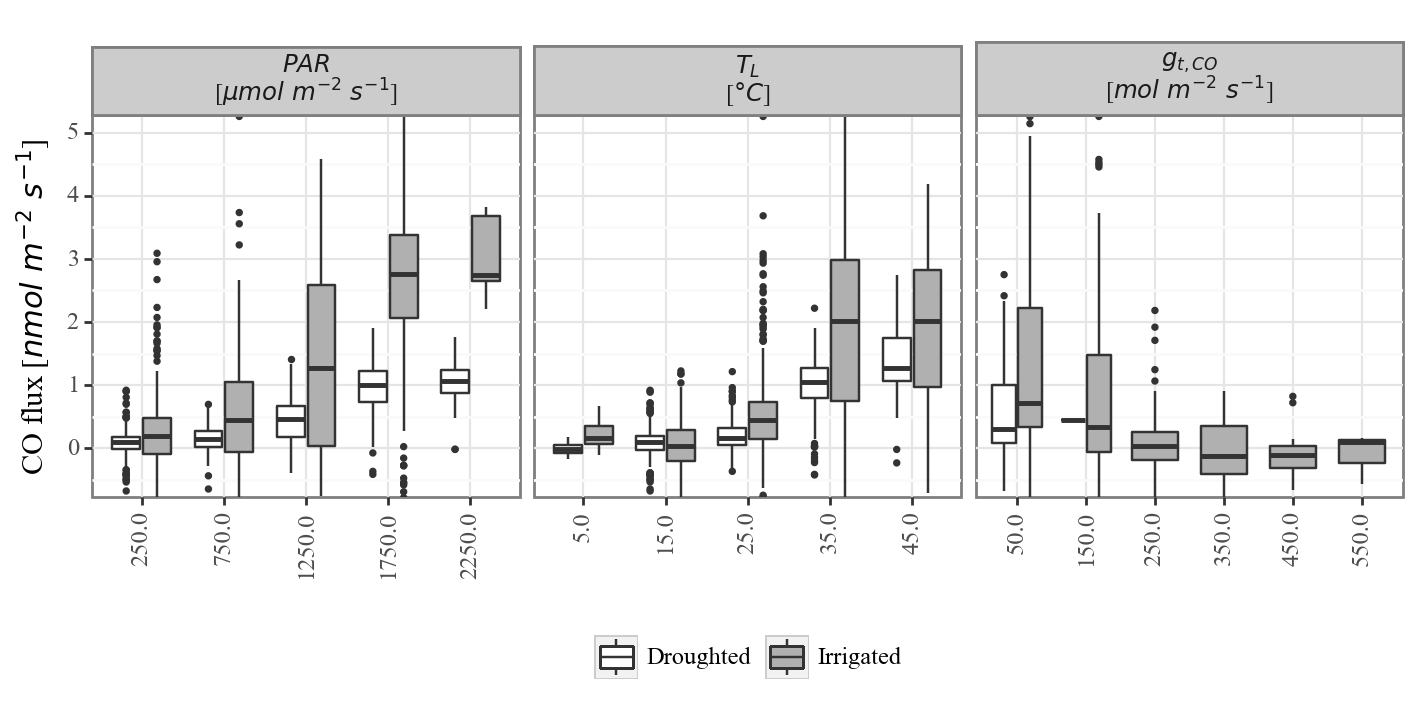

C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 18.0 x 9.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../graphs/02b_boxplot_var_all.png
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\geoms\geom.py:289: FutureWarning: The default of observed=False 

In [21]:
temp = df.copy()
#temp = df.loc[df['par.current.chamber.umol_m2_s1'] > 50].copy()
temp = temp.loc[(temp['timestamp'].dt.hour >= 10) & (temp['timestamp'].dt.hour < 15)].copy()
# Remove some bad values
temp.loc[temp['flux.co.ch_oc.nmol_m2_s'] < -0.8, 'flux.co.ch_oc.nmol_m2_s'] = np.nan
temp.loc[temp['conc_ci.co.nmol_mol'] < 10, 'conc_ci.co.nmol_mol'] = np.nan
temp.loc[(temp['flux.co.ch_oc.nmol_m2_s'] > 1) & (temp['timestamp'].dt.month < 4), 'flux.co.ch_oc.nmol_m2_s'] = np.nan
temp.loc[(temp['flux.co2.ch_oc.umol_m2_s1'] < -10) & (temp['timestamp'].dt.month >= 9), 'flux.co2.ch_oc.umol_m2_s1'] = np.nan
temp.loc[temp['flux.co2.ch_oc.umol_m2_s1'] > 2.5, 'flux.co2.ch_oc.umol_m2_s1'] = np.nan

temp['treatment'] = temp['treatment'].str.replace('dro', 'Droughted')
temp['treatment'] = temp['treatment'].str.replace('irr', 'Irrigated')

# PAR
temp2 = temp.copy()
temp2.dropna(subset=['flux.co.ch_oc.nmol_m2_s','par.current.chamber.umol_m2_s1'], inplace=True)
temp2['bins'] = bin_variable(temp2['par.current.chamber.umol_m2_s1'], 500)
long_par = temp2[['treatment','season','flux.co.ch_oc.nmol_m2_s','bins']].melt(id_vars=['treatment','season','bins'])
long_par['variable'] = '$PAR$\n[$\mu mol~m^{-2}~s^{-1}$]'

# VPD
temp2 = temp.copy()
temp2['VPD.kPa'] = temp2['VPD.Pa.oc']/1000
temp2.dropna(subset=['flux.co.ch_oc.nmol_m2_s','VPD.kPa'], inplace=True)
temp2['bins'] = bin_variable(temp2['VPD.kPa'], 2)
long_vpd = temp2[['treatment','season','flux.co.ch_oc.nmol_m2_s','bins']].melt(id_vars=['treatment','season','bins'])
long_vpd['variable'] = '$VPD$\n[$kPa$]'

# T_air
#temp2 = temp.copy()
#temp2.dropna(subset=['flux.co.ch_oc.nmol_m2_s','temp.air.current.chamber.c'], inplace=True)
#temp2['bins'] = bin_variable(temp2['temp.air.current.chamber.c'], 10)
#long_ta = temp2[['treatment','season','flux.co.ch_oc.nmol_m2_s','bins']].melt(id_vars=['treatment','season','bins'])
#long_ta['variable'] = '$T_{air}$ [$°C$]'

# T_leaf
temp2 = temp.copy()
temp2.dropna(subset=['flux.co.ch_oc.nmol_m2_s','temp.leaf.current.chamber.c.oc'], inplace=True)
temp2['bins'] = bin_variable(temp2['temp.leaf.current.chamber.c.oc'], 10)
long_tl = temp2[['treatment','season','flux.co.ch_oc.nmol_m2_s','bins']].melt(id_vars=['treatment','season','bins'])
long_tl['variable'] = '$T_L$\n[$°C$]'

# H2O flux
temp2 = temp.copy()
temp2.dropna(subset=['flux.co.ch_oc.nmol_m2_s','flux.h2o.ch_oc.mmol_m2_s'], inplace=True)
temp2['bins'] = bin_variable(temp2['flux.h2o.ch_oc.mmol_m2_s'], 1)
long_h2o = temp2[['treatment','season','flux.co.ch_oc.nmol_m2_s','bins']].melt(id_vars=['treatment','season','bins'])
long_h2o['variable'] = 'Tr flux\n[$mmol~m^{-2}~s^{-1}$]'
long_h2o = long_h2o.loc[long_h2o['bins'] != 6.5]
#long_h2o = long_h2o.loc[long_h2o['bins'].astype(float) < 3]

# g_tCO total branch conductance
temp2 = temp.copy()
temp2['g_tCO'] = np.abs(temp2['g_tCO'])
temp2.dropna(subset=['flux.co.ch_oc.nmol_m2_s','g_tCO'], inplace=True)
temp2['bins'] = bin_variable(temp2['g_tCO']*1000, 100)
long_gt = temp2[['treatment','season','flux.co.ch_oc.nmol_m2_s','bins']].melt(id_vars=['treatment','season','bins'])
long_gt['variable'] = '$g_{t,CO}$\n[$mol~m^{-2}~s^{-1}$]'

# COi
temp2 = temp.copy()
temp2.dropna(subset=['flux.co.ch_oc.nmol_m2_s','conc_ci.co.nmol_mol'], inplace=True)
temp2['bins'] = bin_variable(temp2['conc_ci.co.nmol_mol'], 250)
long_coi = temp2[['treatment','season','flux.co.ch_oc.nmol_m2_s','bins']].melt(id_vars=['treatment','season','bins'])
long_coi['variable'] = '$c_{CO,i}$\n[$nmol~mol^{-1}$]'
#long_coi = long_coi.loc[long_h2oi['bins'] != '-25'].copy()

# Merge
#long_merged = pd.concat([long_tl, long_h2o, long_par])
#long_merged = pd.concat([long_tl, long_gt, long_par])
long_merged = pd.concat([long_par, long_tl, long_gt])
long_merged['bins'] = long_merged['bins'].astype(float)
category_list = np.sort(long_merged['bins'].unique())
long_merged['bins'] = order_cats(long_merged['bins'], list_ordering=category_list) # Order bins

# Order seasons
#long_merged['variable'] = order_cats(long_merged['variable'], list_ordering=['$T_L$ [$°C$]', 'Tr flux [$mmol~m^{-2}~s^{-1}$]', 'PAR [$\\mu mol~m^{-2}~s^{-1}$]'])
#long_merged['variable'] = order_cats(long_merged['variable'], list_ordering=['$T_L$ [$°C$]', '$g_{t,CO}~ [mmol~m^{-2}~s^{-1}]$', 'PAR [$\\mu mol~m^{-2}~s^{-1}$]'])
long_merged['variable'] = order_cats(long_merged['variable'], list_ordering=['$PAR$\n[$\\mu mol~m^{-2}~s^{-1}$]', '$T_L$\n[$°C$]', '$g_{t,CO}$\n[$mol~m^{-2}~s^{-1}$]'])

plt = ggplot(long_merged)
plt = plt + theme_bw()
plt = plt + geom_boxplot(aes(x='bins', y='value', fill='treatment'), outlier_size=0.5)
plt = plt + labs(x='', y='CO flux [$nmol~m^{-2}~s^{-1}$]', fill='')
plt = plt + facet_grid(' ~ variable', scales='free_x')
plt = plt + scale_colour_manual(values=bwPalette) + scale_fill_manual(values=bwPalette)
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5),
                  legend_title=element_blank(), #legend_box_spacing=10.4,
                  text=element_text(family="serif"))
plt = plt + theme(legend_position = 'bottom')
plt = plt + theme(figure_size=(18/2.54, 9/2.54))
plt = plt + coord_cartesian(ylim=[-0.5, 5])
print(plt)

plt.save(graphs_path + '02b_boxplot_var_all.png', width=18, height=9, units='cm', dpi=600)
plt.save(graphs_path + '02b_boxplot_var_all.pdf', width=18, height=9, units='cm', dpi=600)

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_5564\1840494282.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_boxplot : Removed 607 rows containing non-finite values.


CO/Tr ratios were 2-15x larger in the droughted treatment
9.25
14.476190476190476
6.870967741935484
2.2352941176470584


C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


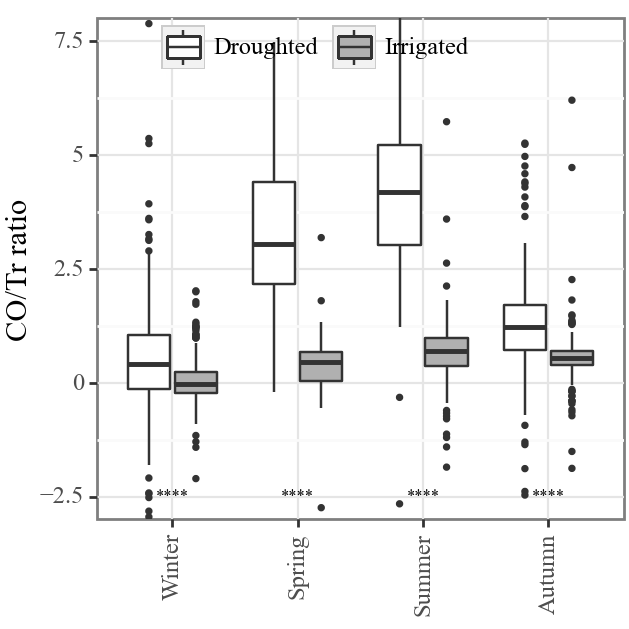

C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 7.999999999999999 x 7.999999999999999 cm image.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../graphs/02b_boxplot_co_h2o_ratio_seasonal.png
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_boxplot : Removed 607 rows containing non-finite values.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 7.999999999999999 x 7.999999999999999 cm image.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../graphs/02b_boxplot_co_h2o_ratio_seasonal.pdf
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\l

In [26]:
# CO/H2O flux, midday ratio

temp = df.loc[df['par.current.chamber.umol_m2_s1'] > 50].copy()
# Select midday
temp = temp.loc[(temp['timestamp'].dt.hour >= 10) & (temp['timestamp'].dt.hour < 15)].copy()

# Calculate ratio
temp['co_h2o_ratio'] = temp['flux.co.ch_oc.nmol_m2_s'] / temp['flux.h2o.ch_oc.mmol_m2_s']

# Rename
temp['treatment'] = temp['treatment'].str.replace('dro', 'Droughted')
temp['treatment'] = temp['treatment'].str.replace('irr', 'Irrigated')

# Order seasons
temp['season'] = order_cats(temp['season'], list_ordering=['Winter','Spring','Summer','Autumn'])

# Show values
mean_df = temp[['season', 'treatment', 'co_h2o_ratio']].groupby(['season', 'treatment']).agg(['median','mean','std'])
mean_df.reset_index(inplace=True)
mean_df.columns = ['_'.join(col).strip('_') for col in mean_df.columns.values]
mean_df['summary'] = np.round(mean_df['co_h2o_ratio_mean'], 2).astype(str) + '±' + np.round(mean_df['co_h2o_ratio_std'], 2).astype(str)
mean_df.drop(['co_h2o_ratio_mean', 'co_h2o_ratio_std'], axis=1, inplace=True)
#display(mean_df)
print('CO/Tr ratios were 2-15x larger in the droughted treatment')
print(0.37/0.04)
print(3.04/0.21)
print(4.26/0.62)
print(1.14/0.51)

plt = ggplot(temp)
plt = plt + theme_bw()
plt = plt + geom_boxplot(aes(x='season', y='co_h2o_ratio', fill='treatment'), outlier_size=0.5)
plt = plt + labs(x='Season', y='CO/Tr ratio', fill='')
plt = plt + scale_colour_manual(values=bwPalette) + scale_fill_manual(values=bwPalette)
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5),
                  text=element_text(family="serif"),
                  axis_title_x=element_blank())
plt = plt + theme(legend_position = (0.5, 0.95), legend_background=element_rect(fill='#ffffff00') )
plt = plt + theme(figure_size=(8/2.54, 8/2.54))
plt = plt + coord_cartesian(ylim=[-2.5, 7.5])
#plt = plt + geom_text(aes(x='season', y=-1.9, fill='treatment', label='summary'), nudge_x=-0.2, size=6, data=mean_df.loc[mean_df['treatment'] == 'Droughted'])
#plt = plt + geom_text(aes(x='season', y=-2.4, fill='treatment', label='summary'), nudge_x= 0.2, size=6, data=mean_df.loc[mean_df['treatment'] == 'Irrigated'])
#plt = plt + geom_text(aes(x='season', y=-2.9, fill='treatment'), label='****', size=6, data=mean_df.loc[mean_df['treatment'] == 'Irrigated'])
plt = plt + geom_text(aes(x='season', y=-2.5, fill='treatment'), label='****', size=6, data=mean_df.loc[mean_df['treatment'] == 'Irrigated'])
print(plt)

# For R
# Note: Figures in R contain significance *, but since all are <2.2e-10, it's pointless
temp.to_csv(graphs_path + '02b_boxplot_co_h2o_ratio_seasonal_data.csv', index=False)

plt.save(graphs_path + '02b_boxplot_co_h2o_ratio_seasonal.png', width=8, height=8, units='cm', dpi=600)
plt.save(graphs_path + '02b_boxplot_co_h2o_ratio_seasonal.pdf', width=8, height=8, units='cm', dpi=600)

### TODO: $CO/CO_2$ ratio, concentration, not flux

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_3240\4053425649.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_boxplot : Removed 498 rows containing non-finite values.


CO/CO2 ratios were 2-15x larger in the droughted treatment
9.25
14.476190476190476
6.870967741935484
2.2352941176470584


C:\Users\Jonathan\.conda\envs\dp\Lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


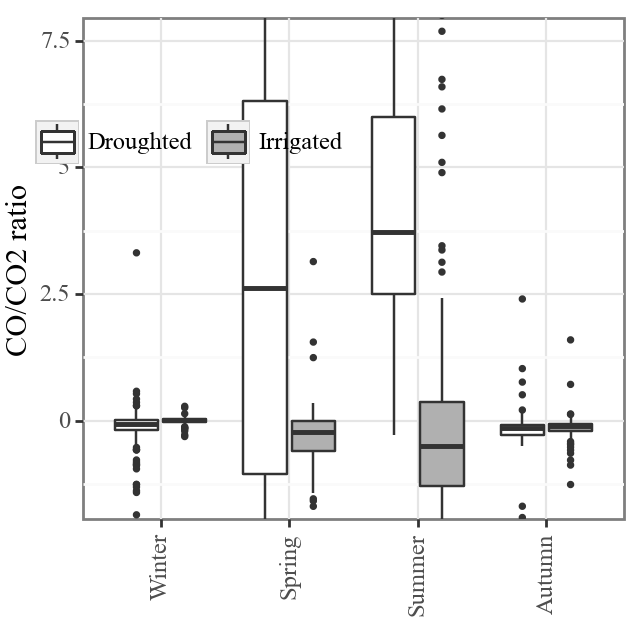

In [52]:
# CO/CO2 flux, midday ratio

temp = df.loc[df['par.current.chamber.umol_m2_s1'] > 150].copy()
# Select midday
temp = temp.loc[(temp['timestamp'].dt.hour >= 10) & (temp['timestamp'].dt.hour < 15)].copy()

# Calculate ratio
temp['co_co2_ratio'] = temp['flux.co.ch_oc.nmol_m2_s'] / (temp['flux.co2.ch_oc.umol_m2_s1'])

# Rename
temp['treatment'] = temp['treatment'].str.replace('dro', 'Droughted')
temp['treatment'] = temp['treatment'].str.replace('irr', 'Irrigated')

# Order seasons
temp['season'] = order_cats(temp['season'], list_ordering=['Winter','Spring','Summer','Autumn'])

# Show values
mean_df = temp[['season', 'treatment', 'co_co2_ratio']].groupby(['season', 'treatment']).agg(['median','mean','std'])
mean_df.reset_index(inplace=True)
mean_df.columns = ['_'.join(col).strip('_') for col in mean_df.columns.values]
mean_df['summary'] = np.round(mean_df['co_co2_ratio_mean'], 2).astype(str) + '±' + np.round(mean_df['co_co2_ratio_std'], 2).astype(str)
mean_df.drop(['co_co2_ratio_mean', 'co_co2_ratio_std'], axis=1, inplace=True)
#display(mean_df)
print('CO/CO2 ratios were 2-15x larger in the droughted treatment')
print(0.37/0.04)
print(3.04/0.21)
print(4.26/0.62)
print(1.14/0.51)

plt = ggplot(temp)
plt = plt + theme_bw()
plt = plt + geom_boxplot(aes(x='season', y='co_co2_ratio', fill='treatment'), outlier_size=0.5)
plt = plt + labs(x='Season', y='CO/CO2 ratio', fill='')
plt = plt + scale_colour_manual(values=bwPalette) + scale_fill_manual(values=bwPalette)
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5),
                  text=element_text(family="serif"),
                  axis_title_x=element_blank())
plt = plt + theme(legend_position = (0.3, 0.8), legend_background=element_rect(fill='#ffffff00') )
plt = plt + theme(figure_size=(8/2.54, 8/2.54))
plt = plt + coord_cartesian(ylim=[-1.5, 7.5])
#plt = plt + geom_text(aes(x='season', y=-1.9, fill='treatment', label='summary'), nudge_x=-0.2, size=6, data=mean_df.loc[mean_df['treatment'] == 'Droughted'])
#plt = plt + geom_text(aes(x='season', y=-2.4, fill='treatment', label='summary'), nudge_x= 0.2, size=6, data=mean_df.loc[mean_df['treatment'] == 'Irrigated'])
#plt = plt + geom_text(aes(x='season', y=-2.9, fill='treatment'), label='****', size=6, data=mean_df.loc[mean_df['treatment'] == 'Irrigated'])
plt = plt + geom_text(aes(x='season', y=-2.5, fill='treatment'), label='****', size=6, data=mean_df.loc[mean_df['treatment'] == 'Irrigated'])
print(plt)

# For R
# Note: Figures in R contain significance *, but since all are <2.2e-10, it's pointless
#temp.to_csv(graphs_path + '02b_boxplot_co_h2o_ratio_seasonal_data.csv', index=False)

#plt.save(graphs_path + '02b_boxplot_co_h2o_ratio_seasonal.png', width=8, height=8, units='cm', dpi=600)
#plt.save(graphs_path + '02b_boxplot_co_h2o_ratio_seasonal.pdf', width=8, height=8, units='cm', dpi=600)

In [15]:
# Daytime, correlation coefficient matrix
temp = df.copy()
temp = df.loc[df['par.current.chamber.umol_m2_s1'] > 50].copy()
temp['treatment'] = temp['treatment'].str.replace('dro', 'Droughted')
temp['treatment'] = temp['treatment'].str.replace('irr', 'Irrigated')

temp = temp[['treatment','season','flux.co.ch_oc.nmol_m2_s','par.current.chamber.umol_m2_s1',
              'VPD.Pa','temp.leaf.current.chamber.c' ]].copy()

temp = temp.dropna(subset=['flux.co.ch_oc.nmol_m2_s','par.current.chamber.umol_m2_s1', 'VPD.Pa.oc','temp.leaf.current.chamber.c'])

#print(np.corrcoef([temp['flux.co.ch_oc.nmol_m2_s'],temp['par.current.chamber.umol_m2_s1','temp.leaf.current.chamber.c'],temp['VPD.Pa']]))

display(temp[['flux.co.ch_oc.nmol_m2_s','par.current.chamber.umol_m2_s1', 'VPD.Pa.oc','temp.leaf.current.chamber.c']].corr())

flux.co.ch_oc.proj_la.nmol_m2_s  \
flux.co.ch_oc.proj_la.nmol_m2_s                         1.000000   
par.current.chamber.umol_m2_s1                          0.476782   
VPD.Pa                                                  0.520317   
temp.leaf.current.chamber.c                             0.473011   

                                 par.current.chamber.umol_m2_s1    VPD.Pa  \
flux.co.ch_oc.proj_la.nmol_m2_s                        0.476782  0.520317   
par.current.chamber.umol_m2_s1                         1.000000  0.819504   
VPD.Pa                                                 0.819504  1.000000   
temp.leaf.current.chamber.c                            0.795490  0.946027   

                                 temp.leaf.current.chamber.c  
flux.co.ch_oc.proj_la.nmol_m2_s                     0.473011  
par.current.chamber.umol_m2_s1                      0.795490  
VPD.Pa                                              0.946027  
temp.leaf.current.chamber.c                         1.000000

<ipython-input-16-970b5f34e683>:21: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


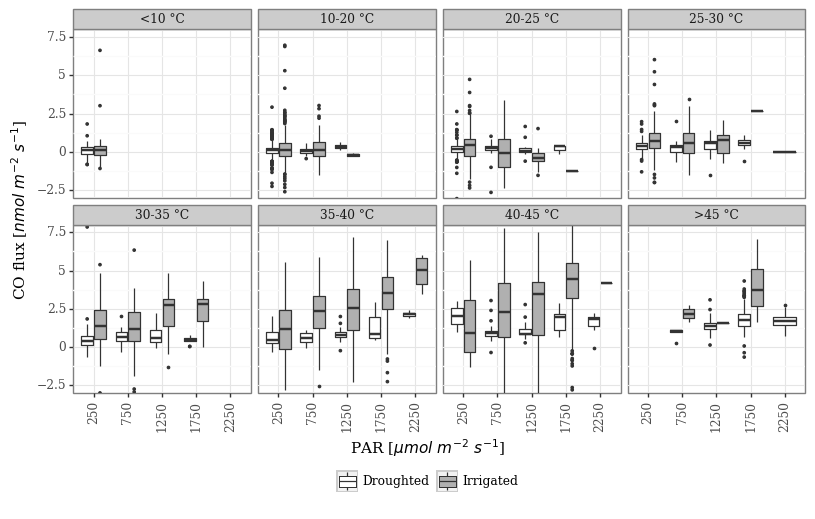

<ggplot: (123125920305)>


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 24.0 x 12.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/03a_boxplot_Tleaf_PAR.png
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 24.0 x 12.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/03a_boxplot_Tleaf_PAR.pdf
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


In [16]:
# Double binning to check the influence of light vs heat
temp = df.copy()
temp = df.loc[df['par.current.chamber.umol_m2_s1'] > 50].copy()
temp['treatment'] = temp['treatment'].str.replace('dro', 'Droughted')
temp['treatment'] = temp['treatment'].str.replace('irr', 'Irrigated')

# T_leaf
temp = temp.copy()
temp.dropna(subset=['flux.co.ch_oc.nmol_m2_s','temp.leaf.current.chamber.c','par.current.chamber.umol_m2_s1'], inplace=True)

#tl_bin_width = 5
#temp['tl_bins'] = bin_variable(temp['temp.leaf.current.chamber.c'], tl_bin_width)
#temp['tl_bins'] = temp['tl_bins'].astype(float)
#temp['tl_bins'] = (temp['tl_bins']-tl_bin_width/2).astype(int).astype(str).str.zfill(2) + '-' + (temp['tl_bins']+tl_bin_width/2).astype(int).astype(str).str.zfill(2) + '°C'
temp['par_bins'] = bin_variable(temp['par.current.chamber.umol_m2_s1'], 500)
# Leaf temperature bins, with some combined categories (>45°C, and 0-10, and 10-20)
tl_bins = [-10, 10, 20, 25, 30, 35, 40, 45, 100]
tl_bin_labels = ['<10 °C', '10-20 °C', '20-25 °C', '25-30 °C', '30-35 °C', '35-40 °C', '40-45 °C', '>45 °C']
temp['tl_bins'] = pd.cut(temp['temp.leaf.current.chamber.c'], bins=tl_bins, labels=tl_bin_labels, include_lowest=True)

temp.columns = temp.columns.str.replace('.', '_')

plt = ggplot(temp)
plt = plt + theme_bw()
plt = plt + geom_boxplot(aes(x='par_bins', y='flux_co_ch_oc_proj_la_nmol_m2_s', fill='treatment'), outlier_size=0.5)
plt = plt + labs(x='PAR [$\mu mol~m^{-2}~s^{-1}$]', y='CO flux [$nmol~m^{-2}~s^{-1}$]', fill='')
plt = plt + facet_wrap('~ tl_bins', ncol=4) #, scales='free_x'
plt = plt + scale_colour_manual(values=bwPalette) + scale_fill_manual(values=bwPalette)
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5),
                  legend_title=element_blank(), legend_box_spacing=0.6,
                  text=element_text(family="serif"))
plt = plt + theme(legend_position = 'bottom')
plt = plt + theme(figure_size=(24/2.54, 12/2.54))
plt = plt + coord_cartesian(ylim=[-2.5, 7.5])
print(plt)

plt.save(graphs_path + '03a_boxplot_Tleaf_PAR.png', width=24, height=12, units='cm', dpi=600)
plt.save(graphs_path + '03a_boxplot_Tleaf_PAR.pdf', width=24, height=12, units='cm', dpi=600)

<ipython-input-17-2312ae693ced>:21: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


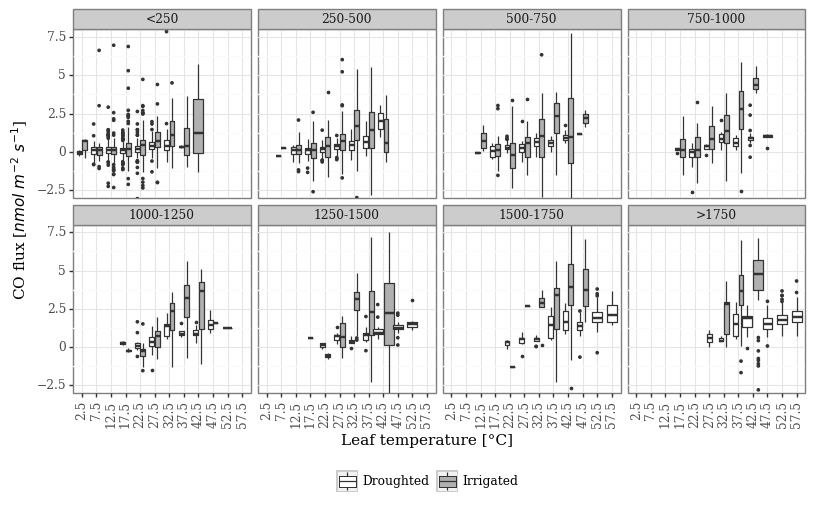

<ggplot: (123125736403)>


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 24.0 x 12.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/03b_boxplot_PAR_Tleaf.png
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 24.0 x 12.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/03b_boxplot_PAR_Tleaf.pdf
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


In [17]:
# Double binning to check the influence of light vs heat
temp = df.copy()
temp = df.loc[df['par.current.chamber.umol_m2_s1'] > 50].copy()
temp['treatment'] = temp['treatment'].str.replace('dro', 'Droughted')
temp['treatment'] = temp['treatment'].str.replace('irr', 'Irrigated')

# T_leaf
temp = temp.copy()
temp.dropna(subset=['flux.co.ch_oc.nmol_m2_s','temp.leaf.current.chamber.c','par.current.chamber.umol_m2_s1'], inplace=True)

tl_bin_width = 5
temp['tl_bins'] = bin_variable(temp['temp.leaf.current.chamber.c'], tl_bin_width)
#temp['tl_bins'] = temp['tl_bins'].astype(float)
#temp['tl_bins'] = (temp['tl_bins']-tl_bin_width/2).astype(int).astype(str).str.zfill(2) + '-' + (temp['tl_bins']+tl_bin_width/2).astype(int).astype(str).str.zfill(2) + '°C'
temp['par_bins'] = bin_variable(temp['par.current.chamber.umol_m2_s1'], 250)
# Leaf temperature bins, with some combined categories (>45°C, and 0-10, and 10-20)
par_bins = [-100, 250, 500, 750, 1000, 1250, 1500, 1750, 3000]
par_bin_labels = ['<250', '250-500', '500-750', '750-1000', '1000-1250', '1250-1500', '1500-1750', '>1750']
temp['par_bins'] = pd.cut(temp['par.current.chamber.umol_m2_s1'], bins=par_bins, labels=par_bin_labels, include_lowest=True)

temp.columns = temp.columns.str.replace('.', '_')

plt = ggplot(temp)
plt = plt + theme_bw()
plt = plt + geom_boxplot(aes(x='tl_bins', y='flux_co_ch_oc_proj_la_nmol_m2_s', fill='treatment'), outlier_size=0.5)
plt = plt + labs(x='Leaf temperature [°C]', y='CO flux [$nmol~m^{-2}~s^{-1}$]', fill='')
plt = plt + facet_wrap('~ par_bins', ncol=4) #, scales='free_x'
plt = plt + scale_colour_manual(values=bwPalette) + scale_fill_manual(values=bwPalette)
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5),
                  legend_title=element_blank(), legend_box_spacing=0.6,
                  text=element_text(family="serif"))
plt = plt + theme(legend_position = 'bottom')
plt = plt + theme(figure_size=(24/2.54, 12/2.54))
plt = plt + coord_cartesian(ylim=[-2.5, 7.5])
print(plt)

plt.save(graphs_path + '03b_boxplot_PAR_Tleaf.png', width=24, height=12, units='cm', dpi=600)
plt.save(graphs_path + '03b_boxplot_PAR_Tleaf.pdf', width=24, height=12, units='cm', dpi=600)

### FOR DAN

He wants basic plots...

<ipython-input-19-0b1b34f98b71>:21: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


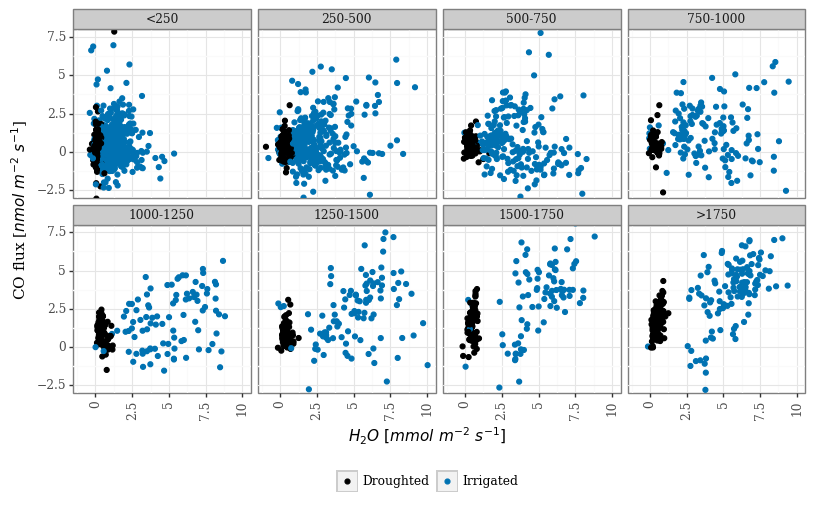

<ggplot: (123122681817)>


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 24.0 x 12.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/03c_boxplot_H2O_PAR.png
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 24.0 x 12.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/03c_boxplot_H2O_PAR.pdf
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


In [19]:
# Double binning to check the influence of light vs heat
temp = df.copy()
temp = df.loc[df['par.current.chamber.umol_m2_s1'] > 50].copy()
temp['treatment'] = temp['treatment'].str.replace('dro', 'Droughted')
temp['treatment'] = temp['treatment'].str.replace('irr', 'Irrigated')

# T_leaf
temp = temp.copy()
temp.dropna(subset=['flux.co.ch_oc.nmol_m2_s','flux.h2o.ch_oc.mmol_m2_s','par.current.chamber.umol_m2_s1'], inplace=True)

h2o_bin_width = 1
temp['h2o_bins'] = bin_variable(temp['flux.h2o.ch_oc.mmol_m2_s'], h2o_bin_width)
#temp['tl_bins'] = temp['tl_bins'].astype(float)
#temp['tl_bins'] = (temp['tl_bins']-tl_bin_width/2).astype(int).astype(str).str.zfill(2) + '-' + (temp['tl_bins']+tl_bin_width/2).astype(int).astype(str).str.zfill(2) + '°C'
temp['par_bins'] = bin_variable(temp['par.current.chamber.umol_m2_s1'], 250)
# Leaf temperature bins, with some combined categories (>45°C, and 0-10, and 10-20)
par_bins = [-100, 250, 500, 750, 1000, 1250, 1500, 1750, 3000]
par_bin_labels = ['<250', '250-500', '500-750', '750-1000', '1000-1250', '1250-1500', '1500-1750', '>1750']
temp['par_bins'] = pd.cut(temp['par.current.chamber.umol_m2_s1'], bins=par_bins, labels=par_bin_labels, include_lowest=True)

temp.columns = temp.columns.str.replace('.', '_')

plt = ggplot(temp)
plt = plt + theme_bw()
plt = plt + geom_point(aes(x='flux_h2o_ch_oc_proj_la_mmol_m2_s', y='flux_co_ch_oc_proj_la_nmol_m2_s', colour='treatment'))
plt = plt + labs(x='$H_2 O~ [mmol~m^{-2}~s^{-1}]$', y='CO flux [$nmol~m^{-2}~s^{-1}$]', colour='Treatment')
plt = plt + facet_wrap('~ par_bins', ncol=4) #, scales='free_x'
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5),
                  legend_title=element_blank(), legend_box_spacing=0.6,
                  text=element_text(family="serif"))
plt = plt + theme(legend_position = 'bottom')
plt = plt + theme(figure_size=(24/2.54, 12/2.54))
plt = plt + coord_cartesian(ylim=[-2.5, 7.5])
print(plt)

plt.save(graphs_path + '03c_boxplot_H2O_PAR.png', width=24, height=12, units='cm', dpi=600)
plt.save(graphs_path + '03c_boxplot_H2O_PAR.pdf', width=24, height=12, units='cm', dpi=600)

<ipython-input-18-90c1208938bf>:21: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


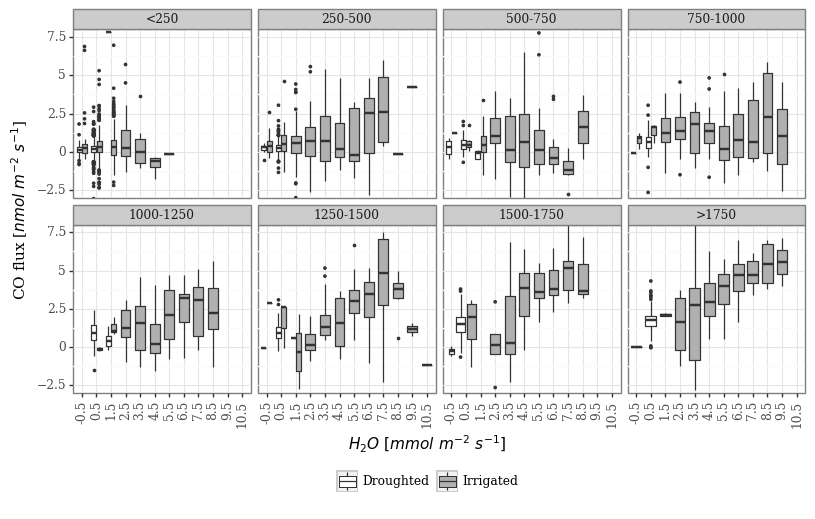

<ggplot: (193444870882)>


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 24.0 x 12.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/03c_boxplot_H2O_PAR.png
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 24.0 x 12.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/03c_boxplot_H2O_PAR.pdf
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


In [18]:
# Double binning to check the influence of light vs heat
temp = df.copy()
temp = df.loc[df['par.current.chamber.umol_m2_s1'] > 50].copy()
temp['treatment'] = temp['treatment'].str.replace('dro', 'Droughted')
temp['treatment'] = temp['treatment'].str.replace('irr', 'Irrigated')

# T_leaf
temp = temp.copy()
temp.dropna(subset=['flux.co.ch_oc.nmol_m2_s','flux.h2o.ch_oc.mmol_m2_s','par.current.chamber.umol_m2_s1'], inplace=True)

h2o_bin_width = 1
temp['h2o_bins'] = bin_variable(temp['flux.h2o.ch_oc.mmol_m2_s'], h2o_bin_width)
#temp['tl_bins'] = temp['tl_bins'].astype(float)
#temp['tl_bins'] = (temp['tl_bins']-tl_bin_width/2).astype(int).astype(str).str.zfill(2) + '-' + (temp['tl_bins']+tl_bin_width/2).astype(int).astype(str).str.zfill(2) + '°C'
temp['par_bins'] = bin_variable(temp['par.current.chamber.umol_m2_s1'], 250)
# Leaf temperature bins, with some combined categories (>45°C, and 0-10, and 10-20)
par_bins = [-100, 250, 500, 750, 1000, 1250, 1500, 1750, 3000]
par_bin_labels = ['<250', '250-500', '500-750', '750-1000', '1000-1250', '1250-1500', '1500-1750', '>1750']
temp['par_bins'] = pd.cut(temp['par.current.chamber.umol_m2_s1'], bins=par_bins, labels=par_bin_labels, include_lowest=True)

temp.columns = temp.columns.str.replace('.', '_')

plt = ggplot(temp)
plt = plt + theme_bw()
plt = plt + geom_boxplot(aes(x='h2o_bins', y='flux_co_ch_oc_proj_la_nmol_m2_s', fill='treatment'), outlier_size=0.5)
plt = plt + labs(x='$H_2 O~ [mmol~m^{-2}~s^{-1}]$', y='CO flux [$nmol~m^{-2}~s^{-1}$]', fill='')
plt = plt + facet_wrap('~ par_bins', ncol=4) #, scales='free_x'
plt = plt + scale_colour_manual(values=bwPalette) + scale_fill_manual(values=bwPalette)
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5),
                  legend_title=element_blank(), legend_box_spacing=0.6,
                  text=element_text(family="serif"))
plt = plt + theme(legend_position = 'bottom')
plt = plt + theme(figure_size=(24/2.54, 12/2.54))
plt = plt + coord_cartesian(ylim=[-2.5, 7.5])
print(plt)

plt.save(graphs_path + '03c_boxplot_H2O_PAR.png', width=24, height=12, units='cm', dpi=600)
plt.save(graphs_path + '03c_boxplot_H2O_PAR.pdf', width=24, height=12, units='cm', dpi=600)

<ipython-input-19-cee5c55ac656>:21: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


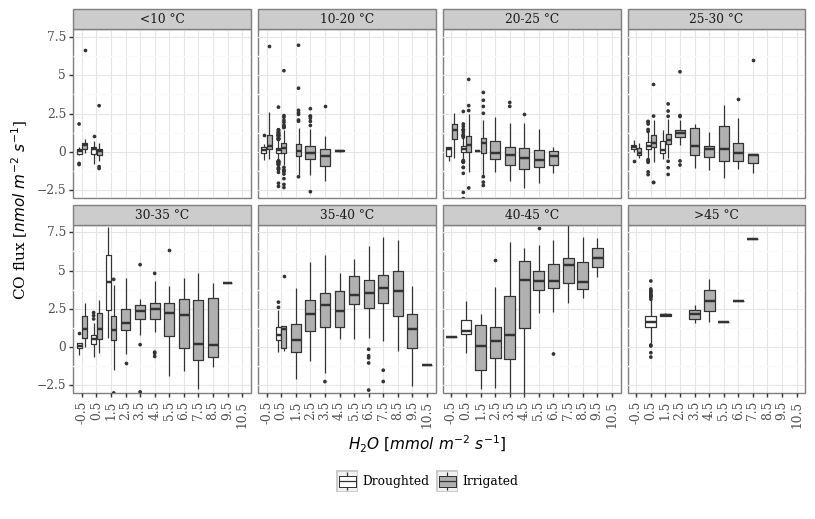

<ggplot: (193445116212)>


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 24.0 x 12.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/03c_boxplot_H2O_TL.png
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 24.0 x 12.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/03c_boxplot_H2O_TL.pdf
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


In [19]:
# Double binning to check the influence of light vs heat
temp = df.copy()
temp = df.loc[df['par.current.chamber.umol_m2_s1'] > 50].copy()
temp['treatment'] = temp['treatment'].str.replace('dro', 'Droughted')
temp['treatment'] = temp['treatment'].str.replace('irr', 'Irrigated')

# T_leaf
temp = temp.copy()
temp.dropna(subset=['flux.co.ch_oc.nmol_m2_s','flux.h2o.ch_oc.mmol_m2_s','temp.leaf.current.chamber.c'], inplace=True)

h2o_bin_width = 1
temp['h2o_bins'] = bin_variable(temp['flux.h2o.ch_oc.mmol_m2_s'], h2o_bin_width)
#temp['tl_bins'] = temp['tl_bins'].astype(float)
#temp['tl_bins'] = (temp['tl_bins']-tl_bin_width/2).astype(int).astype(str).str.zfill(2) + '-' + (temp['tl_bins']+tl_bin_width/2).astype(int).astype(str).str.zfill(2) + '°C'
temp['par_bins'] = bin_variable(temp['par.current.chamber.umol_m2_s1'], 250)
# Leaf temperature bins, with some combined categories (>45°C, and 0-10, and 10-20)
tl_bins = [-10, 10, 20, 25, 30, 35, 40, 45, 100]
tl_bin_labels = ['<10 °C', '10-20 °C', '20-25 °C', '25-30 °C', '30-35 °C', '35-40 °C', '40-45 °C', '>45 °C']
temp['tl_bins'] = pd.cut(temp['temp.leaf.current.chamber.c'], bins=tl_bins, labels=tl_bin_labels, include_lowest=True)

temp.columns = temp.columns.str.replace('.', '_')

plt = ggplot(temp)
plt = plt + theme_bw()
plt = plt + geom_boxplot(aes(x='h2o_bins', y='flux_co_ch_oc_proj_la_nmol_m2_s', fill='treatment'), outlier_size=0.5)
plt = plt + labs(x='$H_2 O~ [mmol~m^{-2}~s^{-1}]$', y='CO flux [$nmol~m^{-2}~s^{-1}$]', fill='')
plt = plt + facet_wrap('~ tl_bins', ncol=4) #, scales='free_x'
plt = plt + scale_colour_manual(values=bwPalette) + scale_fill_manual(values=bwPalette)
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5),
                  legend_title=element_blank(), legend_box_spacing=0.6,
                  text=element_text(family="serif"))
plt = plt + theme(legend_position = 'bottom')
plt = plt + theme(figure_size=(24/2.54, 12/2.54))
plt = plt + coord_cartesian(ylim=[-2.5, 7.5])
print(plt)

plt.save(graphs_path + '03c_boxplot_H2O_TL.png', width=24, height=12, units='cm', dpi=600)
plt.save(graphs_path + '03c_boxplot_H2O_TL.pdf', width=24, height=12, units='cm', dpi=600)

## OLD

<ipython-input-43-b6f540432161>:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


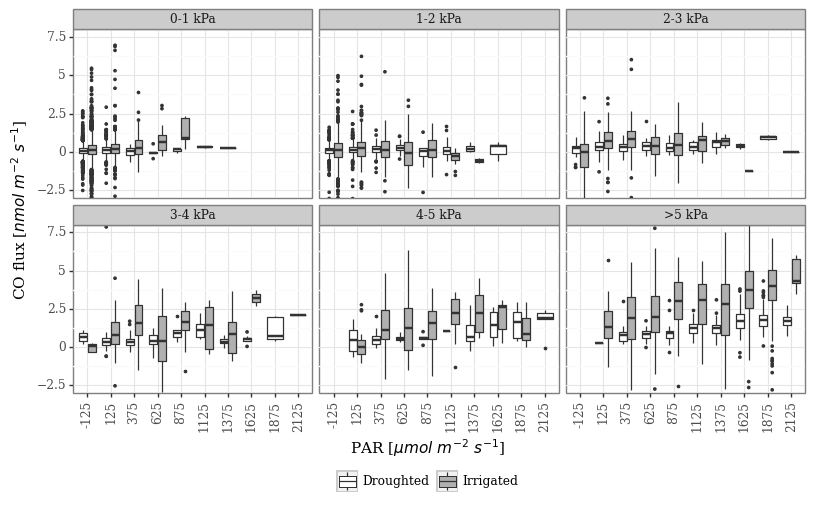

<ggplot: (152749623887)>


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 24.0 x 12.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/03c_boxplot_VPD_PAR.png
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 24.0 x 12.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/03c_boxplot_VPD_PAR.pdf
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


In [43]:
# Double binning to check the influence of light vs heat
temp = df.copy()
temp['treatment'] = temp['treatment'].str.replace('dro', 'Droughted')
temp['treatment'] = temp['treatment'].str.replace('irr', 'Irrigated')

# T_leaf
temp = temp.copy()
temp.dropna(subset=['flux.co.ch_oc.nmol_m2_s','par.current.chamber.umol_m2_s1','VPD.Pa'], inplace=True)

# Variable to be binned
temp['var_bins'] = bin_variable(temp['par.current.chamber.umol_m2_s1'], 250)
# Leaf temperature bins, with some combined categories (>45°C, and 0-10, and 10-20)
var2_bins = [-100000, 1000, 2000, 3000, 4000, 5000, 100000]
var2_bin_labels = ['0-1 kPa', '1-2 kPa', '2-3 kPa', '3-4 kPa', '4-5 kPa', '>5 kPa']
temp['var2_bins'] = pd.cut(temp['VPD.Pa'], bins=var2_bins, labels=var2_bin_labels, include_lowest=True)

temp.columns = temp.columns.str.replace('.', '_')

plt = ggplot(temp)
plt = plt + theme_bw()
plt = plt + geom_boxplot(aes(x='var_bins', y='flux_co_ch_oc_proj_la_nmol_m2_s', fill='treatment'), outlier_size=0.5)
plt = plt + labs(x='PAR [$\mu mol~m^{-2}~s^{-1}$]', y='CO flux [$nmol~m^{-2}~s^{-1}$]', fill='')
plt = plt + facet_wrap('~ var2_bins', ncol=3) #, scales='free_x'
plt = plt + scale_colour_manual(values=bwPalette) + scale_fill_manual(values=bwPalette)
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5),
                  legend_title=element_blank(), legend_box_spacing=0.6,
                  text=element_text(family="serif"))
plt = plt + theme(legend_position = 'bottom')
plt = plt + theme(figure_size=(24/2.54, 12/2.54))
plt = plt + coord_cartesian(ylim=[-2.5, 7.5])
print(plt)

#plt.save(graphs_path + '03c_boxplot_VPD_PAR.png', width=24, height=12, units='cm', dpi=600)
#plt.save(graphs_path + '03c_boxplot_VPD_PAR.pdf', width=24, height=12, units='cm', dpi=600)

<ipython-input-42-4018f8076b0b>:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


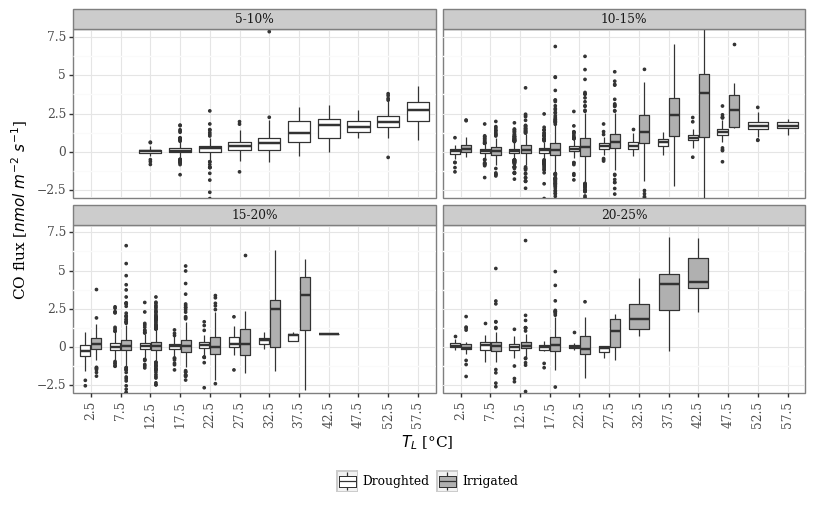

<ggplot: (152752220426)>


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 24.0 x 12.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/03d_boxplot_Tleaf_SWC.png
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 24.0 x 12.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/03d_boxplot_Tleaf_SWC.pdf
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


In [42]:
# Double binning to check the influence of light vs heat
temp = df.copy()
temp['treatment'] = temp['treatment'].str.replace('dro', 'Droughted')
temp['treatment'] = temp['treatment'].str.replace('irr', 'Irrigated')

# T_leaf
temp = temp.copy()
temp.dropna(subset=['flux.co.ch_oc.nmol_m2_s','swc_10_30cm','VPD.Pa'], inplace=True)

# Variable to be binned
temp['var_bins'] = bin_variable(temp['temp.leaf.current.chamber.c'], 5)
# Leaf temperature bins, with some combined categories (>45°C, and 0-10, and 10-20)
var2_bins = [0, 5, 10, 15, 20, 25, 30, 35, 100]
var2_bin_labels = ['0-5%', '5-10%', '10-15%', '15-20%', '20-25%', '25-30%', '30-35%', '>35%']
temp['var2_bins'] = pd.cut(temp['swc_10_30cm'], bins=var2_bins, labels=var2_bin_labels, include_lowest=True)

temp.columns = temp.columns.str.replace('.', '_')

plt = ggplot(temp)
plt = plt + theme_bw()
plt = plt + geom_boxplot(aes(x='var_bins', y='flux_co_ch_oc_proj_la_nmol_m2_s', fill='treatment'), outlier_size=0.5)
plt = plt + labs(x='$T_L$ [°C]', y='CO flux [$nmol~m^{-2}~s^{-1}$]', fill='')
plt = plt + facet_wrap('~ var2_bins', ncol=2) #, scales='free_x'
plt = plt + scale_colour_manual(values=bwPalette) + scale_fill_manual(values=bwPalette)
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5),
                  legend_title=element_blank(), legend_box_spacing=0.6,
                  text=element_text(family="serif"))
plt = plt + theme(legend_position = 'bottom')
plt = plt + theme(figure_size=(24/2.54, 12/2.54))
plt = plt + coord_cartesian(ylim=[-2.5, 7.5])
print(plt)

#plt.save(graphs_path + '03d_boxplot_Tleaf_SWC.png', width=24, height=12, units='cm', dpi=600)
#plt.save(graphs_path + '03d_boxplot_Tleaf_SWC.pdf', width=24, height=12, units='cm', dpi=600)

<ipython-input-48-283e159feb09>:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


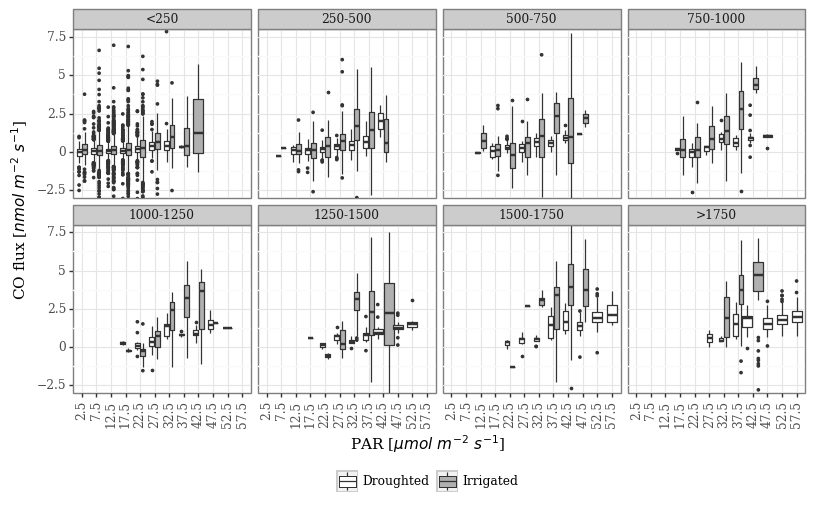

<ggplot: (152752887775)>


In [48]:
# Double binning to check the influence of light vs heat
temp = df.copy()
temp['treatment'] = temp['treatment'].str.replace('dro', 'Droughted')
temp['treatment'] = temp['treatment'].str.replace('irr', 'Irrigated')

# T_leaf
temp = temp.copy()
temp.dropna(subset=['flux.co.ch_oc.nmol_m2_s','par.current.chamber.umol_m2_s1','VPD.Pa'], inplace=True)

# Variable to be binned
temp['var_bins'] = bin_variable(temp['temp.leaf.current.chamber.c'], 5)
# Leaf temperature bins, with some combined categories (>45°C, and 0-10, and 10-20)
var2_bins = [-10000, 250, 500, 750, 1000, 1250, 1500, 1750, 10000]
var2_bin_labels = ['<250', '250-500', '500-750', '750-1000', '1000-1250', '1250-1500', '1500-1750', '>1750']
temp['var2_bins'] = pd.cut(temp['par.current.chamber.umol_m2_s1'], bins=par_bins, labels=par_bin_labels, include_lowest=True)

temp.columns = temp.columns.str.replace('.', '_')

plt = ggplot(temp)
plt = plt + theme_bw()
plt = plt + geom_boxplot(aes(x='var_bins', y='flux_co_ch_oc_proj_la_nmol_m2_s', fill='treatment'), outlier_size=0.5)
plt = plt + labs(x='PAR [$\mu mol~m^{-2}~s^{-1}$]', y='CO flux [$nmol~m^{-2}~s^{-1}$]', fill='')
plt = plt + facet_wrap('~ var2_bins', ncol=4) #, scales='free_x'
plt = plt + scale_colour_manual(values=bwPalette) + scale_fill_manual(values=bwPalette)
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5),
                  legend_title=element_blank(), legend_box_spacing=0.6,
                  text=element_text(family="serif"))
plt = plt + theme(legend_position = 'bottom')
plt = plt + theme(figure_size=(24/2.54, 12/2.54))
plt = plt + coord_cartesian(ylim=[-2.5, 7.5])
print(plt)

#plt.save(graphs_path + '03e_boxplot_Tleaf_SWC.png', width=24, height=12, units='cm', dpi=600)
#plt.save(graphs_path + '03e_boxplot_Tleaf_SWC.pdf', width=24, height=12, units='cm', dpi=600)

## OLD

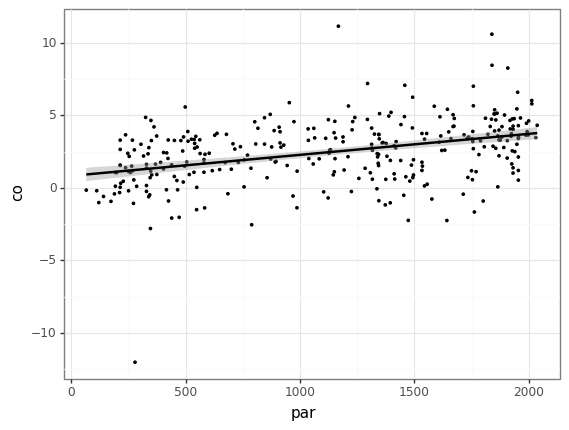

<ggplot: (152749938842)>
LinregressResult(slope=0.0014463975953557496, intercept=0.8251307807925932, rvalue=0.38969476411572296, pvalue=6.135492391695653e-13, stderr=0.00019259326779658882)
Multiple linear regression (Irrigated)
--------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     co   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     56.40
Date:                Wed, 26 Jul 2023   Prob (F-statistic):           6.14e-13
Time:                        22:12:55   Log-Likelihood:                -676.88
No. Observations:                 317   AIC:                             1358.
Df Residuals:                     315   BIC:                             1365.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8251      0.245      3.367      0.001       0.343       1.307
par            0.0014      0.000      7.510      0.000       0.001       0.002
==============================================================================
Omnibus:                       70.257   Durbin-Watson:                   1.346
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              485.884
Skew:                          -0.691   Prob(JB):                    3.10e-106
Kurtosis:                       8.906   Cond. No.                     2.70e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Intercept    0.825131
par          0.001446
dtype: float64

ANOVA results
-------------


df       sum_sq     mean_sq          F        PR(>F)
par         1.0   237.813614  237.813614  56.401828  6.135492e-13
Residual  315.0  1328.171293    4.216417        NaN           NaN

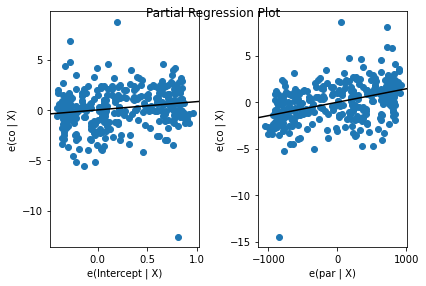

In [17]:
# Fit multiple regression
import statsmodels.api as sm

# Remove NAs
temp = df.copy()
temp = df.loc[(df['par.current.chamber.umol_m2_s1'] > 50)].copy()
temp['treatment'] = temp['treatment'].str.replace('dro', 'Droughted')
temp['treatment'] = temp['treatment'].str.replace('irr', 'Irrigated')
temp.dropna(subset=['flux.co.ch_oc.nmol_m2_s','temp.leaf.current.chamber.c','par.current.chamber.umol_m2_s1','swc_10_30cm'], inplace=True)

# Make bins and do multiple regression
temp['tl_bins'] = bin_variable(temp['temp.leaf.current.chamber.c'], 5)
temp['par_bins'] = bin_variable(temp['par.current.chamber.umol_m2_s1'], 250)
temp['tl_bins'] = temp['tl_bins'].astype(float)
temp['par_bins'] = temp['par_bins'].astype(float)

temp.rename({'flux.co.ch_oc.nmol_m2_s': 'co'}, axis=1, inplace=True)
temp.rename({'temp.leaf.current.chamber.c': 'tleaf'}, axis=1, inplace=True)
temp.rename({'par.current.chamber.umol_m2_s1': 'par'}, axis=1, inplace=True)

model = sm.formula.ols(formula='co ~ par', data=temp.loc[(temp['treatment'] == 'Irrigated') & (temp['tl_bins'] == 37.5)]).fit()
#predictions = model.predict(X) # make the predictions by the model

plt = ggplot(temp.loc[(temp['treatment'] == 'Irrigated') & (temp['tl_bins'] == 37.5)])
plt = plt + geom_point(aes(x='par', y='co'), size=0.5)
plt = plt + geom_smooth(aes(x='par', y='co'), method='lm')
plt = plt + theme_bw()
print(plt)

from scipy import stats
print(stats.linregress(temp.loc[(temp['treatment'] == 'Irrigated') & (temp['tl_bins'] == 37.5), 'par'],
                       temp.loc[(temp['treatment'] == 'Irrigated') & (temp['tl_bins'] == 37.5), 'co']))

# Print out the statistics
print('Multiple linear regression (Irrigated)')
print('--------------------------')
display(model.summary())

# Examples to show the coefficients for application
print(model.params)
print()

# # Plot
fig = sm.graphics.plot_partregress_grid(model)
fig.tight_layout(pad=1.0)

# Do an ANOVA
from statsmodels.stats.anova import anova_lm
anova_results = anova_lm(model)
print('ANOVA results')
print('-------------')
display(anova_results)

In [17]:
# Fit exponential growth curve
# https://rowannicholls.github.io/python/curve_fitting/exponential.html

from scipy.optimize import curve_fit

# Fit the function a * np.exp(b * t) + c to x and y
popt, pcov = curve_fit(lambda t, a, b, c: a * np.exp(b * t) + c, temp['tleaf'], temp['co'])

a = popt[0]
b = popt[1]
c = popt[2]
print(a,b,c)

# Plot here to see the fit and check


#https://stackoverflow.com/questions/63581359/how-to-fit-multiple-exponential-curves-using-python

9.113354435189432e-16 1.000000001150304 -0.061368679831558914


### Night-time

- To answer the question of whether it's heat or light-related

C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\facets\facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\facets\facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


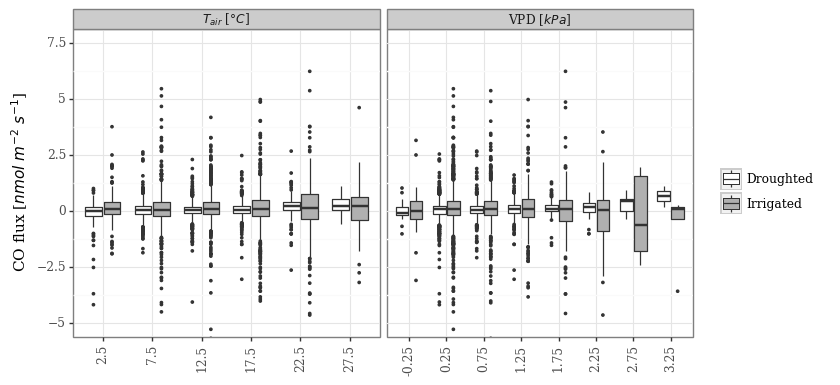

<ggplot: (114938058325)>


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 19.200000000000003 x 9.600000000000001 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/02b_boxplot_var_all_night.png
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\facets\facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\facets\facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have ma

In [33]:
temp = df.loc[df['par.current.chamber.umol_m2_s1'] < 5].copy()
temp['treatment'] = temp['treatment'].str.replace('dro', 'Droughted')
temp['treatment'] = temp['treatment'].str.replace('irr', 'Irrigated')

# PAR
temp2 = temp.copy()
temp2.dropna(subset=['flux.co.ch_oc.nmol_m2_s','par.current.chamber.umol_m2_s1'], inplace=True)
temp2['bins'] = bin_variable(temp2['par.current.chamber.umol_m2_s1'], 500)
long_par = temp2[['treatment','season','flux.co.ch_oc.nmol_m2_s','bins']].melt(id_vars=['treatment','season','bins'])
long_par['variable'] = 'PAR [$\mu mol~m^{-2}~s^{-1}$]'

# VPD
temp2 = temp.copy()
temp2['VPD.kPa'] = temp2['VPD.Pa']/1000
temp2.dropna(subset=['flux.co.ch_oc.nmol_m2_s','VPD.kPa'], inplace=True)
temp2['bins'] = bin_variable(temp2['VPD.kPa'], 0.5)
long_vpd = temp2[['treatment','season','flux.co.ch_oc.nmol_m2_s','bins']].melt(id_vars=['treatment','season','bins'])
long_vpd['variable'] = 'VPD [$kPa$]'

# T_air
temp2 = temp.copy()
temp2.dropna(subset=['flux.co.ch_oc.nmol_m2_s','temp.air.current.chamber.c'], inplace=True)
temp2['bins'] = bin_variable(temp2['temp.air.current.chamber.c'], 5)
long_ta = temp2[['treatment','season','flux.co.ch_oc.nmol_m2_s','bins']].melt(id_vars=['treatment','season','bins'])
long_ta['variable'] = '$T_{air}$ [$°C$]'

# Merge
long_merged = pd.concat([long_vpd, long_ta.loc[long_ta['bins'] < 32.5]])
long_merged['bins'] = long_merged['bins'].astype(float)
category_list = np.sort(long_merged['bins'].unique())
long_merged['bins'] = order_cats(long_merged['bins'], list_ordering=category_list) # Order bins

# Order seasons
long_merged['season'] = order_cats(long_merged['season'], list_ordering=['Winter','Spring','Summer','Autumn'])

plt = ggplot(long_merged)
plt = plt + theme_bw()
plt = plt + geom_boxplot(aes(x='bins', y='value', fill='treatment'), outlier_size=0.5)
plt = plt + labs(x='', y='CO flux [$nmol~m^{-2}~s^{-1}$]', fill='')
plt = plt + facet_grid(' ~ variable', scales='free_x')
plt = plt + scale_colour_manual(values=bwPalette) + scale_fill_manual(values=bwPalette)
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5),
                  text=element_text(family="serif"))
#plt = plt + theme(legend_position = 'bottom')
plt = plt + theme(figure_size=(8, 4))
plt = plt + coord_cartesian(ylim=[-5, 7.5])
print(plt)

plt.save(graphs_path + '02b_boxplot_var_all_night.png', width=1.6*12, height=1.6*6, units='cm', dpi=600)
plt.save(graphs_path + '02b_boxplot_var_all_night.pdf', width=1.6*12, height=1.6*6, units='cm', dpi=600)

<ipython-input-72-f3affa4578fe>:30: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\facets\facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\facets\facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


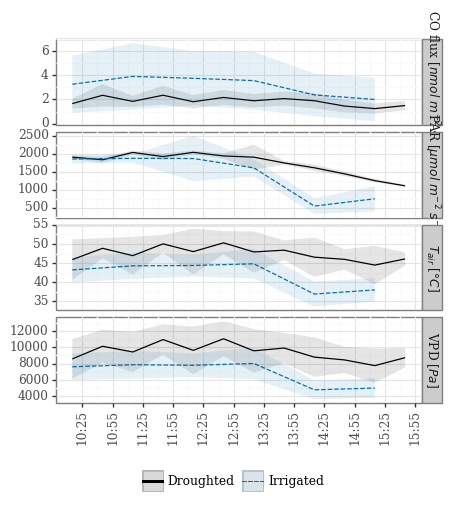

<ggplot: (114936756089)>


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 12.0 x 12.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/99a_temp_wiggles.png
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\facets\facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\facets\facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


In [72]:
# Summer, 11:00-15:00
temp = df.loc[(df['status'] == 'cc') & (df['season'] == 'Summer') & (df['timestamp'].dt.hour >= 10) & (df['timestamp'].dt.hour <= 15),
             ['timestamp', 'treatment', 'chamber','season','rain','hamsin',
              'flux.co.ch_oc.nmol_m2_s', 'temp.air.current.chamber.c', 'par.current.chamber.umol_m2_s1', 'VPD.Pa']].copy()

# Filters
temp = temp.loc[~temp['rain'].isin(['Post-rain', 'Rain'])]
temp = temp.loc[temp['hamsin'] == False]
temp = temp.loc[(temp['timestamp'] >= '2020-09-01 00:00') & (temp['timestamp'] < '2021-09-01 00:00')].copy()
# Remove now-obsolete columns
temp.drop(['rain','hamsin','chamber', 'season'], axis=1, inplace=True)

# Convert wide to long
long = pd.melt(temp, id_vars=['timestamp','treatment'])
long['time']  = long['timestamp'].dt.strftime('%H:%M')
#temp['month'] = temp['timestamp'].dt.strftime('%Y-%m')
# Rename all columns
long.loc[long['variable'] == 'temp.air.current.chamber.c', 'variable'] = '$T_{air}$ [$°C$]'
long.loc[long['variable'] == 'par.current.chamber.umol_m2_s1', 'variable'] = 'PAR [$\mu mol~m^{-2}~s^{-1}$]'
long.loc[long['variable'] == 'VPD.Pa', 'variable'] = 'VPD [$Pa$]'
long.loc[long['variable'] == 'flux.co.ch_oc.nmol_m2_s', 'variable'] = 'CO flux [$nmol~m^{-2}~s^{-1}$]'

long['treatment'] = long['treatment'].str.replace('dro', 'Droughted')
long['treatment'] = long['treatment'].str.replace('irr', 'Irrigated')

grouped = long.groupby(['time','treatment','variable']).agg(['mean','median','std'])
# Reset index and rename columns
grouped = grouped.reset_index()
grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns.values]
grouped.columns = grouped.columns.str.replace('.', '_')

grouped['timestamp'] = pd.to_datetime(grouped['time'], format='%H:%M')

# Order columns
def order_cats(col, list_ordering):
    cat_dtype = pd.CategoricalDtype(categories=list_ordering, ordered=True)
    col = col.astype(cat_dtype)
    return(col)
grouped['variable'] = order_cats(grouped['variable'], list_ordering=['CO flux [$nmol~m^{-2}~s^{-1}$]',
                                                                     'PAR [$\mu mol~m^{-2}~s^{-1}$]',
                                                                     '$T_{air}$ [$°C$]',
                                                                     'VPD [$Pa$]'])

# Plot the diurnal
plt = ggplot(grouped)
plt = plt + geom_line(aes(x='timestamp', y='value_median', colour='treatment', linetype='treatment'), size=0.5)
plt = plt + geom_ribbon(aes(x='timestamp', ymin='value_median - value_std', ymax='value_median + value_std', fill='treatment'), alpha=0.1)
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + labs(x='Time of day', y='Flux', colour='Treatment', fill='Treatment', linetype='Treatment')
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), axis_title_x = element_blank(), axis_title_y = element_blank(),
                  text=element_text(family="serif"),
                  legend_box_spacing=0.01, legend_title = element_blank(), legend_position='bottom')
plt = plt + facet_grid('variable ~', scales='free_y')
plt = plt + theme(figure_size=(12/2.54, 12/2.54))
#plt = plt + coord_cartesian(ylim=[-1.0, 5.0])
plt = plt + scale_x_datetime(date_breaks = '30 minutes', date_labels = '%H:%M')
print(plt)

plt.save(graphs_path + '99a_temp_wiggles.png', width=12, height=12, units='cm', dpi=600)

In [53]:
def labels_at(breaks, at):
    breaks_as_str = np.array(breaks).astype(str)
    return np.where(np.mod(breaks, at) == 0, breaks_as_str, '')

<ipython-input-58-65ea39b8046d>:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\layer.py:467: PlotnineWarning: geom_point : Removed 7403 rows containing missing values.


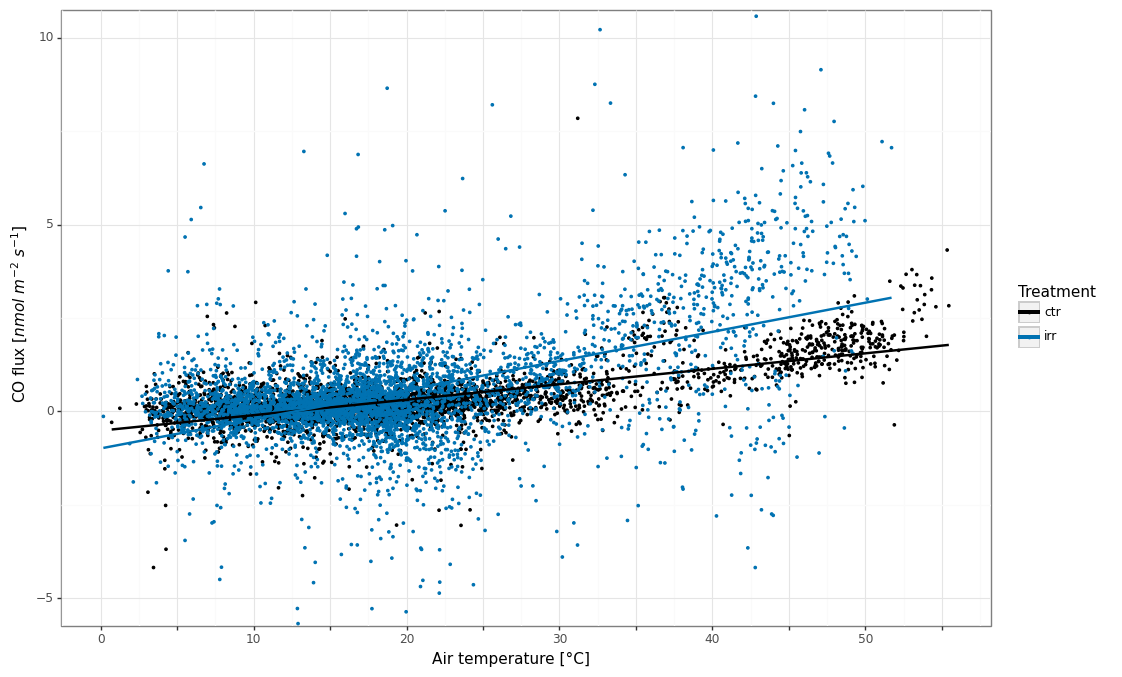

<ggplot: (114938510544)>


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 19.200000000000003 x 19.200000000000003 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/02b_CO_vs_Tair.png
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\layer.py:467: PlotnineWarning: geom_point : Removed 7403 rows containing missing values.


In [58]:
# CO by variable (TODO!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!)

temp = df.loc[df['status'] == 'cc', ['timestamp', 'treatment', 'chamber','season','rain','hamsin',
                                     'temp.air.current.chamber.c', 'par.current.chamber.umol_m2_s1',
                                     'flux.co.ch_oc.nmol_m2_s',
                                     'VPD.Pa', 'swc_40cm']]
# Filters
temp = temp.loc[~temp['rain'].isin(['Post-rain', 'Rain'])]
temp = temp.loc[temp['hamsin'] == False]
temp = temp.loc[(temp['timestamp'] >= '2020-09-01 00:00') & (temp['timestamp'] < '2021-09-01 00:00')].copy()
# Remove now-obsolete columns
temp.drop(['rain','hamsin','chamber'], axis=1, inplace=True)

temp = temp.groupby(['treatment', 'season']).resample('1h', on='timestamp').mean()
temp.reset_index(inplace=True)

temp.columns = temp.columns.str.replace('.', '_')

# temp['bins_t'] = bin_variable(temp['temp.air.current.chamber.c'], 10)

cbPalette = ['#000000', '#0072B2', '#E69F00', '#CC00CC', '#009E73', '#D55E00', '#CC79A7', '#FF3300', '#F0E442', '#56B4E9']

plt = ggplot(temp)
plt = plt + geom_point(aes(x='temp_air_current_chamber_c', y='flux_co_ch_oc_proj_la_nmol_m2_s', colour='treatment'), size=0.5)
plt = plt + geom_smooth(aes(x='temp_air_current_chamber_c', y='flux_co_ch_oc_proj_la_nmol_m2_s', colour='treatment'), method='lm', se=False)
#plt = plt + stat_smooth(aes(x='temp_air_current_chamber_c', y='flux_co_ch_oc_proj_la_nmol_m2_s', colour='treatment'), method='lm', formula='y ~ np.exp(x)', se=False)
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + labs(x='Air temperature [°C]', y='CO flux [$nmol~m^{-2}~s^{-1}$]', colour='Treatment', fill='Treatment')
#plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), axis_title_x = element_blank(),
#                  text=element_text(family="serif"))
#plt = plt + facet_wrap('~ season', ncol = 2)
#plt = plt + scale_y_log10()
#plt = plt + coord_cartesian(ylim=[-3, 3])
plt = plt + coord_cartesian(ylim=[-5, 10])
plt = plt + theme(figure_size=(12, 8))
plt = plt + scale_x_continuous(breaks=np.arange(0,70, 5), labels=labels_at(np.arange(0,70, 5), 10))

#plt = plt + scale_x_datetime(date_breaks = '3 hours', date_labels = '%H:%M')
print(plt)

plt.save(graphs_path + '02b_CO_vs_Tair.png', width=1.6*12, height=1.6*12, units='cm', dpi=600)

<ipython-input-37-311960044e5a>:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\layer.py:467: PlotnineWarning: geom_point : Removed 1355 rows containing missing values.


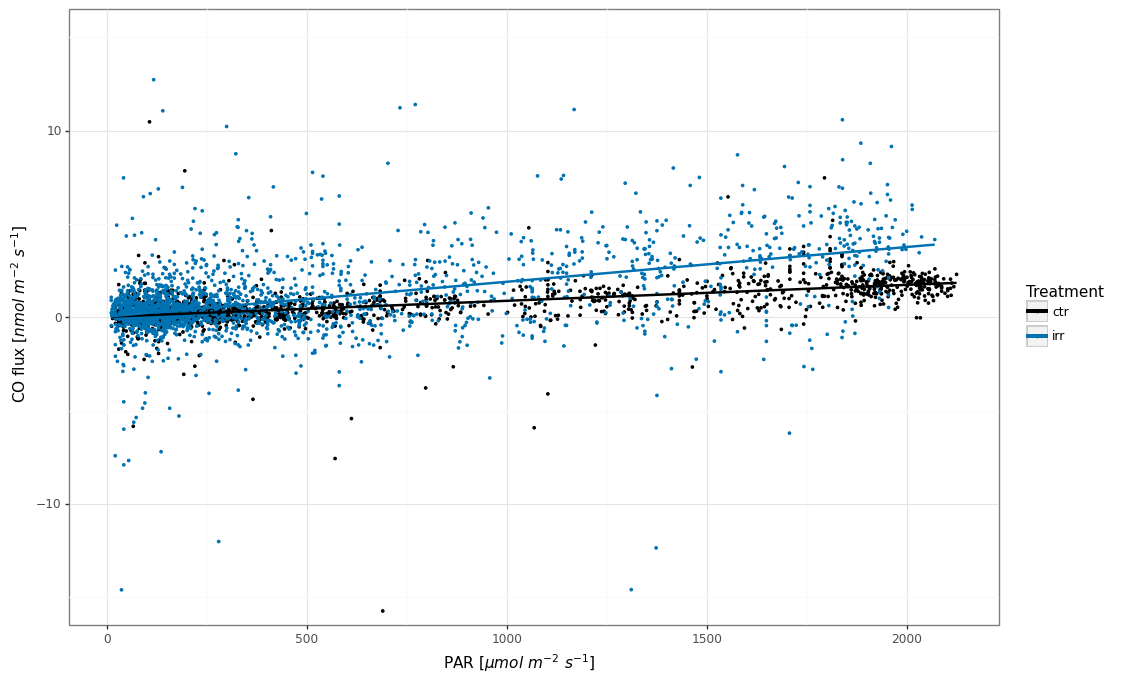

<ggplot: (153918438437)>


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 19.200000000000003 x 19.200000000000003 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/02b_CO_vs_PAR.png
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\layer.py:467: PlotnineWarning: geom_point : Removed 1355 rows containing missing values.


In [37]:
# CO by variable (TODO!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!)

temp = df.loc[df['status'] == 'cc', ['timestamp', 'treatment', 'chamber','season','rain','hamsin',
                                     'temp.air.current.chamber.c', 'par.current.chamber.umol_m2_s1',
                                     'flux.co.ch_oc.nmol_m2_s',
                                     'VPD.Pa', 'swc_40cm']]
# Filters
temp = temp.loc[~temp['rain'].isin(['Post-rain', 'Rain'])]
temp = temp.loc[temp['hamsin'] == False]
temp = temp.loc[(temp['timestamp'] >= '2020-09-01 00:00') & (temp['timestamp'] < '2021-09-01 00:00')].copy()
# Remove now-obsolete columns
temp.drop(['rain','hamsin','chamber'], axis=1, inplace=True)

temp = temp.groupby(['treatment', 'season']).resample('1h', on='timestamp').mean()
temp.reset_index(inplace=True)

temp.columns = temp.columns.str.replace('.', '_')

temp = temp.loc[temp['par_current_chamber_umol_m2_s1'] > 10]
# temp['bins_t'] = bin_variable(temp['temp.air.current.chamber.c'], 10)

cbPalette = ['#000000', '#0072B2', '#E69F00', '#CC00CC', '#009E73', '#D55E00', '#CC79A7', '#FF3300', '#F0E442', '#56B4E9']

plt = ggplot(temp)
plt = plt + geom_point(aes(x='par_current_chamber_umol_m2_s1', y='flux_co_ch_oc_proj_la_nmol_m2_s', colour='treatment'), size=0.5)
plt = plt + geom_smooth(aes(x='par_current_chamber_umol_m2_s1', y='flux_co_ch_oc_proj_la_nmol_m2_s', colour='treatment'), method='lm', se=False)
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + labs(x='PAR [$\mu mol~m^{-2}~s^{-1}$]', y='CO flux [$nmol~m^{-2}~s^{-1}$]', colour='Treatment', fill='Treatment')
#plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), axis_title_x = element_blank(),
#                  text=element_text(family="serif"))
#plt = plt + facet_wrap('~ season', ncol = 2)

plt = plt + theme(figure_size=(12, 8))
#plt = plt + scale_y_log10()
plt = plt + coord_cartesian(ylim=[-15, 15])

#plt = plt + scale_x_datetime(date_breaks = '3 hours', date_labels = '%H:%M')
print(plt)

plt.save(graphs_path + '02b_CO_vs_PAR.png', width=1.6*12, height=1.6*12, units='cm', dpi=600)

<ipython-input-36-75eadeb0320f>:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\layer.py:467: PlotnineWarning: geom_point : Removed 7065 rows containing missing values.


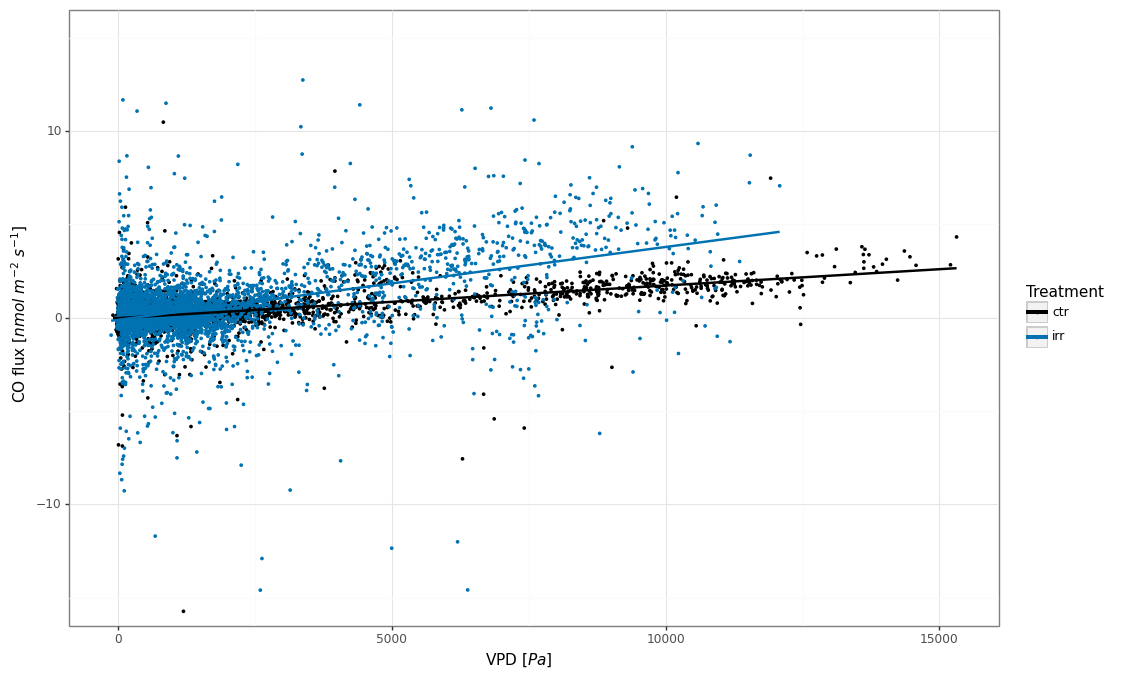

<ggplot: (153841847950)>


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 19.200000000000003 x 19.200000000000003 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/02b_CO_vs_VPD.png
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\layer.py:467: PlotnineWarning: geom_point : Removed 7065 rows containing missing values.


In [36]:
# CO by variable (TODO!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!)

temp = df.loc[df['status'] == 'cc', ['timestamp', 'treatment', 'chamber','season','rain','hamsin',
                                     'temp.air.current.chamber.c', 'par.current.chamber.umol_m2_s1',
                                     'flux.co.ch_oc.nmol_m2_s',
                                     'VPD.Pa', 'swc_40cm']]
# Filters
temp = temp.loc[~temp['rain'].isin(['Post-rain', 'Rain'])]
temp = temp.loc[temp['hamsin'] == False]
temp = temp.loc[(temp['timestamp'] >= '2020-09-01 00:00') & (temp['timestamp'] < '2021-09-01 00:00')].copy()
# Remove now-obsolete columns
temp.drop(['rain','hamsin','chamber'], axis=1, inplace=True)

temp = temp.groupby(['treatment', 'season']).resample('1h', on='timestamp').mean()
temp.reset_index(inplace=True)

temp.columns = temp.columns.str.replace('.', '_')

# temp['bins_t'] = bin_variable(temp['temp.air.current.chamber.c'], 10)

cbPalette = ['#000000', '#0072B2', '#E69F00', '#CC00CC', '#009E73', '#D55E00', '#CC79A7', '#FF3300', '#F0E442', '#56B4E9']

plt = ggplot(temp)
plt = plt + geom_point(aes(x='VPD_Pa', y='flux_co_ch_oc_proj_la_nmol_m2_s', colour='treatment'), size=0.5)
plt = plt + geom_smooth(aes(x='VPD_Pa', y='flux_co_ch_oc_proj_la_nmol_m2_s', colour='treatment'), method='lm', se=False)
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + labs(x='VPD [$Pa$]', y='CO flux [$nmol~m^{-2}~s^{-1}$]', colour='Treatment', fill='Treatment')
#plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), axis_title_x = element_blank(),
#                  text=element_text(family="serif"))
#plt = plt + facet_wrap('~ season', ncol = 2)

plt = plt + theme(figure_size=(12, 8))
#plt = plt + scale_y_log10()
plt = plt + coord_cartesian(ylim=[-15, 15])

#plt = plt + scale_x_datetime(date_breaks = '3 hours', date_labels = '%H:%M')
print(plt)

plt.save(graphs_path + '02b_CO_vs_VPD.png', width=1.6*12, height=1.6*12, units='cm', dpi=600)

<ipython-input-33-498944b4a0d6>:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\layer.py:467: PlotnineWarning: geom_point : Removed 7022 rows containing missing values.


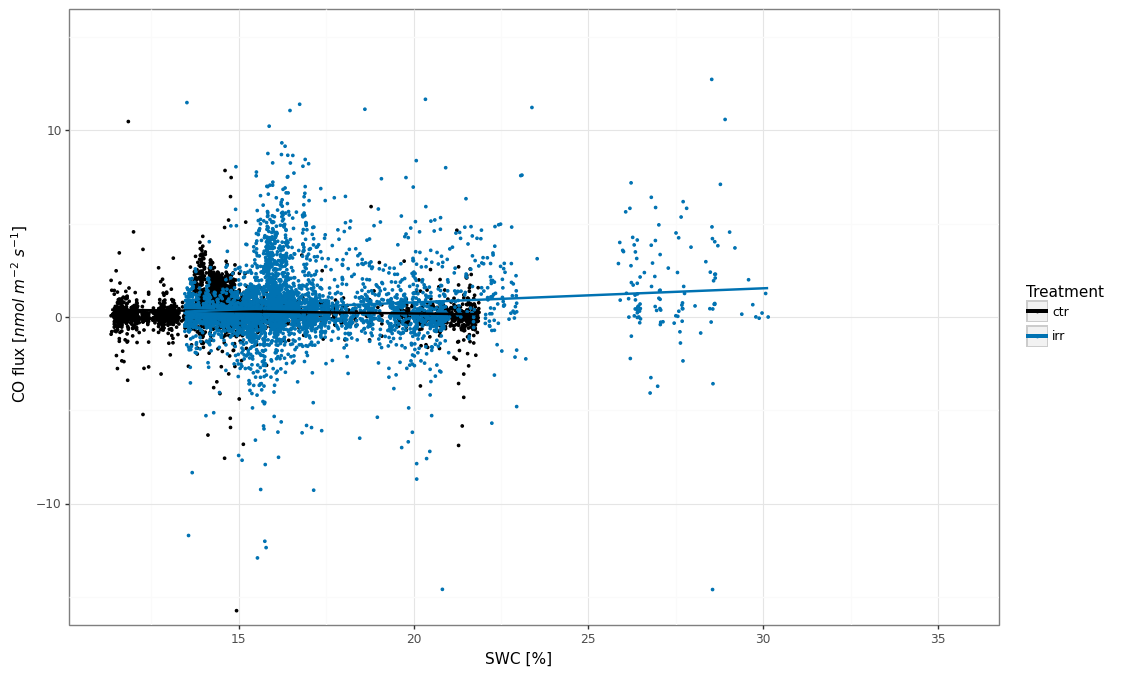

<ggplot: (100722216301)>


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 19.200000000000003 x 19.200000000000003 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/02b_CO_vs_SWC.png
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\layer.py:467: PlotnineWarning: geom_point : Removed 7022 rows containing missing values.


In [33]:
# CO by SWC: No correlation. If at all, show only in supplement

temp = df.loc[df['status'] == 'cc', ['timestamp', 'treatment', 'chamber','season','rain','hamsin',
                                     'temp.air.current.chamber.c', 'par.current.chamber.umol_m2_s1',
                                     'flux.co.ch_oc.nmol_m2_s',
                                     'VPD.Pa', 'swc_40cm']]
# Filters
temp = temp.loc[~temp['rain'].isin(['Post-rain', 'Rain'])]
temp = temp.loc[temp['hamsin'] == False]
temp = temp.loc[(temp['timestamp'] >= '2020-09-01 00:00') & (temp['timestamp'] < '2021-09-01 00:00')].copy()
# Remove now-obsolete columns
temp.drop(['rain','hamsin','chamber'], axis=1, inplace=True)

temp = temp.groupby(['treatment', 'season']).resample('1h', on='timestamp').mean()
temp.reset_index(inplace=True)

temp.columns = temp.columns.str.replace('.', '_')

# temp['bins_t'] = bin_variable(temp['temp.air.current.chamber.c'], 10)

cbPalette = ['#000000', '#0072B2', '#E69F00', '#CC00CC', '#009E73', '#D55E00', '#CC79A7', '#FF3300', '#F0E442', '#56B4E9']

plt = ggplot(temp)
plt = plt + geom_point(aes(x='swc_40cm', y='flux_co_ch_oc_proj_la_nmol_m2_s', colour='treatment'), size=0.5)
plt = plt + geom_smooth(aes(x='swc_40cm', y='flux_co_ch_oc_proj_la_nmol_m2_s', colour='treatment'), method='lm', se=False)
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + labs(x='SWC [%]', y='CO flux [$nmol~m^{-2}~s^{-1}$]', colour='Treatment', fill='Treatment')
#plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), axis_title_x = element_blank(),
#                  text=element_text(family="serif"))
#plt = plt + facet_wrap('~ season', ncol = 2)

plt = plt + theme(figure_size=(12, 8))
#plt = plt + scale_y_log10()
plt = plt + coord_cartesian(ylim=[-15, 15])

#plt = plt + scale_x_datetime(date_breaks = '3 hours', date_labels = '%H:%M')
print(plt)

plt.save(graphs_path + '02b_CO_vs_SWC.png', width=1.6*12, height=1.6*12, units='cm', dpi=600)

In [18]:
1e-1

0.1

<ipython-input-17-29575ec301a4>:23: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.


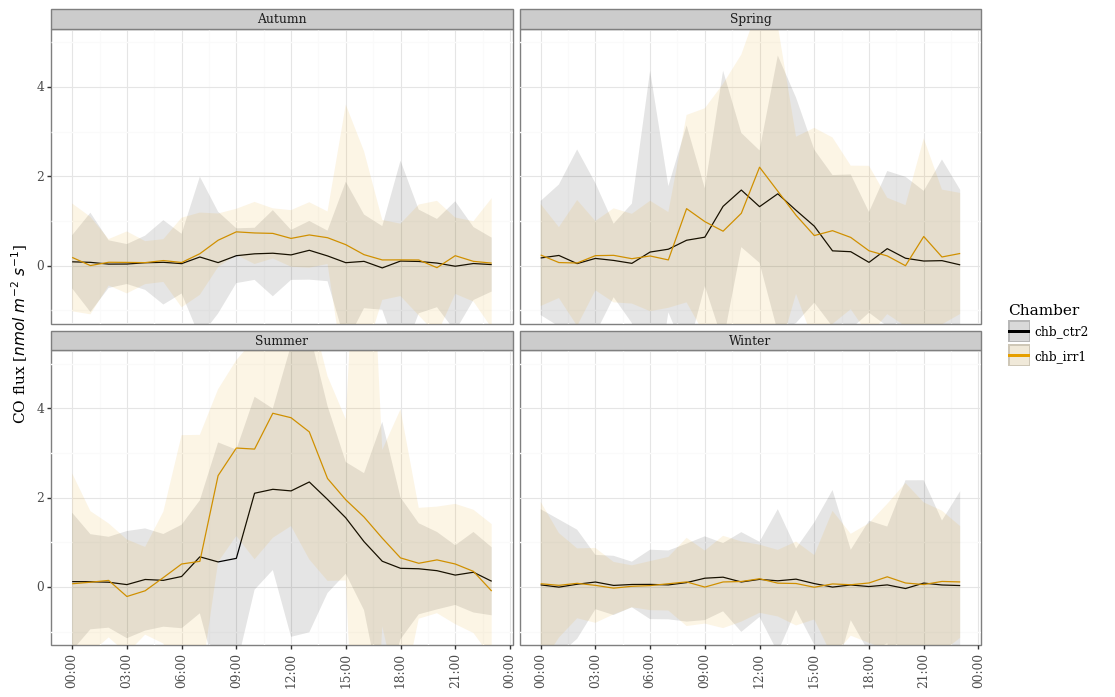

<ggplot: (137280922176)>


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 24.0 x 12.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/02a_diurnal_CO-flux_seasonal.png


In [17]:
# Colours
cbPalette = ['#000000', '#E69F00', '#0072B2', '#CC00CC', '#009E73', '#D55E00', '#CC79A7', '#FF3300', '#F0E442', '#56B4E9']

temp = df.loc[df['status'] == 'cc', ['timestamp', 'treatment', 'chamber','season','rain','hamsin','conc.co.nmol_mol',
                                     'flux.co.ch_amb.nmol_m2_s', 'flux.co.ch_oc.nmol_m2_s',
                                     'flux.co.ch_amb.nmol_m2_s', 'flux.co.ch_oc.nmol_m2_s',
                                     'temp.leaf.current.chamber.c', 'temp.air.current.chamber.c',
                                     'par.ambient.umol_m2_s1', 'par.current.chamber.umol_m2_s1']]
# Filters
temp = temp.loc[~temp['rain'].isin(['Post-rain', 'Rain'])]
temp = temp.loc[(temp['timestamp'] >= '2020-09-01 00:00') & (temp['timestamp'] < '2021-09-01 00:00')]

temp['time']  = temp['timestamp'].dt.strftime('%H:%M')
#temp['month'] = temp['timestamp'].dt.strftime('%Y-%m')

grouped = temp.groupby(['chamber','time','season']).agg(['mean','median','std'])
# Reset index and rename columns
grouped = grouped.reset_index()
grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns.values]
grouped.columns = grouped.columns.str.replace('.', '_')
#print(grouped.columns.values)

grouped['timestamp'] = pd.to_datetime(grouped['time'], format='%H:%M')
# Plot the diurnal
plt = ggplot(grouped)
plt = plt + geom_line(aes(x='timestamp', y='flux_co_ch_oc_proj_la_nmol_m2_s_median', colour='chamber'), size=0.5)
plt = plt + geom_ribbon(aes(x='timestamp', ymin='flux_co_ch_oc_proj_la_nmol_m2_s_median - flux_co_ch_oc_proj_la_nmol_m2_s_std', ymax='flux_co_ch_oc_proj_la_nmol_m2_s_median + flux_co_ch_oc_proj_la_nmol_m2_s_std', fill='chamber'), alpha=0.1)
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + labs(x='Time', y='CO flux [$nmol~m^{-2}~s^{-1}$]', colour='Chamber', fill='Chamber')
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), axis_title_x = element_blank(),
                  text=element_text(family="serif"))
plt = plt + facet_wrap('~ season', ncol = 2)
plt = plt + theme(figure_size=(12, 8))
plt = plt + coord_cartesian(ylim=[-1.0, 5.0])
plt = plt + scale_x_datetime(date_breaks = '3 hours', date_labels = '%H:%M')
print(plt)

plt.save(graphs_path + '02a_diurnal_CO-flux_seasonal.png', width=1.6*15, height=1.6*7.5, units='cm', dpi=600)

<ipython-input-48-8c8c1e5ae617>:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.


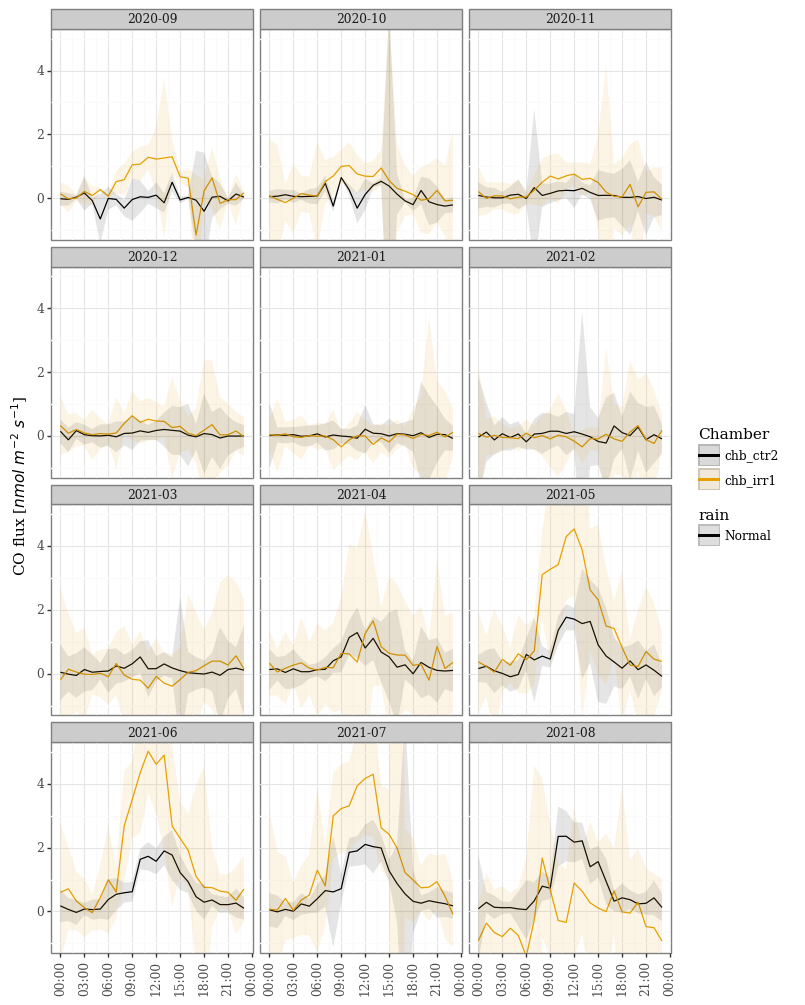

<ggplot: (150597678273)>


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 15.999999999999998 x 24.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/01a_diurnal_CO-flux_monthly.png


In [48]:
# Colours
cbPalette = ['#000000', '#E69F00', '#0072B2', '#CC00CC', '#009E73', '#D55E00', '#CC79A7', '#FF3300', '#F0E442', '#56B4E9']

temp = df.loc[(df['status'] == 'cc') & (df['rain'] != 'Post-rain'), ['timestamp', 'treatment', 'chamber','rain','conc.co.nmol_mol',
                                     'flux.co.ch_amb.nmol_m2_s', 'flux.co.ch_oc.nmol_m2_s',
                                     'flux.co.ch_amb.nmol_m2_s', 'flux.co.ch_oc.nmol_m2_s',
                                     'temp.leaf.current.chamber.c', 'temp.air.current.chamber.c',
                                     'par.ambient.umol_m2_s1', 'par.current.chamber.umol_m2_s1', 'VPD.Pa']]
temp = temp.loc[(temp['timestamp'] >= '2020-09-01 00:00') & (temp['timestamp'] < '2021-09-01 00:00')]

temp['time']  = temp['timestamp'].dt.strftime('%H:%M')
temp['month'] = temp['timestamp'].dt.strftime('%Y-%m')

grouped = temp.groupby(['chamber','time','month','rain']).agg(['mean','median','std'])
# Reset index and rename columns
grouped = grouped.reset_index()
grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns.values]
grouped.columns = grouped.columns.str.replace('.', '_')
#print(grouped.columns.values)

grouped['timestamp'] = pd.to_datetime(grouped['time'], format='%H:%M')
# Plot the diurnal
plt = ggplot(grouped)
plt = plt + geom_line(aes(x='timestamp', y='flux_co_ch_oc_proj_la_nmol_m2_s_median', colour='chamber', linetype='rain'), size=0.5)
plt = plt + geom_ribbon(aes(x='timestamp', ymin='flux_co_ch_oc_proj_la_nmol_m2_s_median - flux_co_ch_oc_proj_la_nmol_m2_s_std', ymax='flux_co_ch_oc_proj_la_nmol_m2_s_median + flux_co_ch_oc_proj_la_nmol_m2_s_std', fill='chamber', linetype='rain'), alpha=0.1)
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + labs(x='Time', y='CO flux [$nmol~m^{-2}~s^{-1}$]', colour='Chamber', fill='Chamber', linetype='rain')
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), axis_title_x = element_blank(),
                  text=element_text(family="serif"))
plt = plt + facet_wrap('~ month', ncol = 3)
plt = plt + theme(figure_size=(8, 12))
plt = plt + coord_cartesian(ylim=[-1.0, 5.0])
plt = plt + scale_x_datetime(date_breaks = '3 hours', date_labels = '%H:%M')
print(plt)

plt.save(graphs_path + '01a_diurnal_CO-flux_monthly.png', width=1.6*10, height=1.6*15, units='cm', dpi=600)

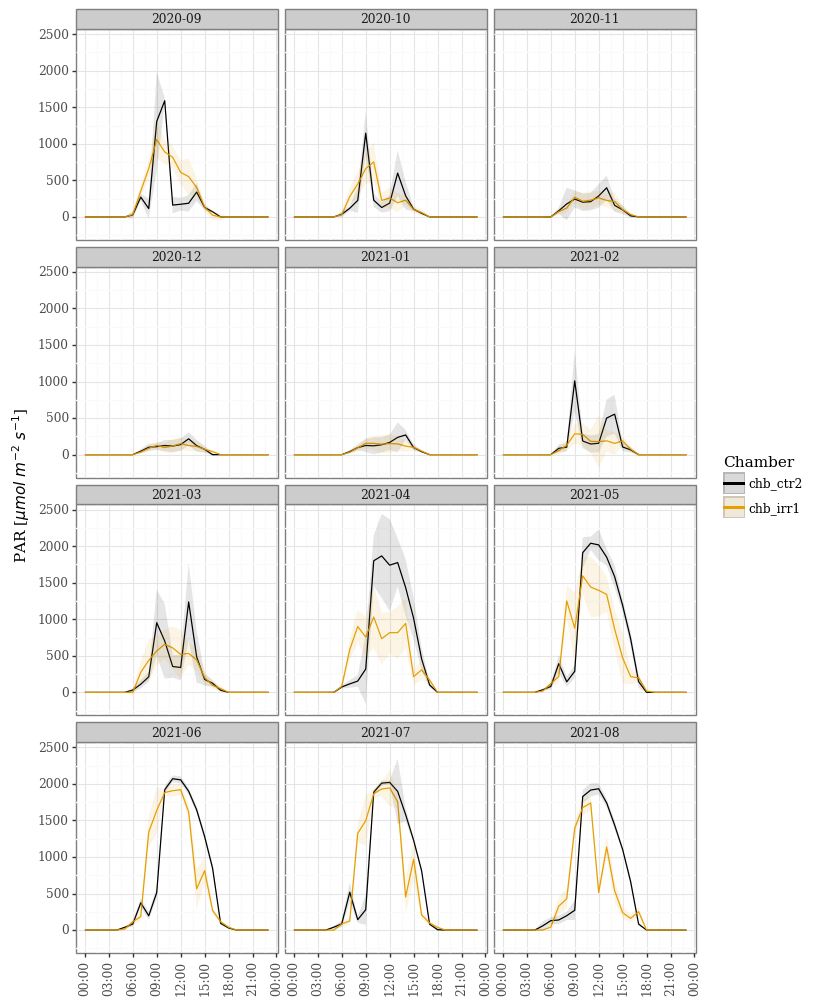

<ggplot: (148639701887)>


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 15.999999999999998 x 24.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/01b_diurnal_PAR_monthly.png


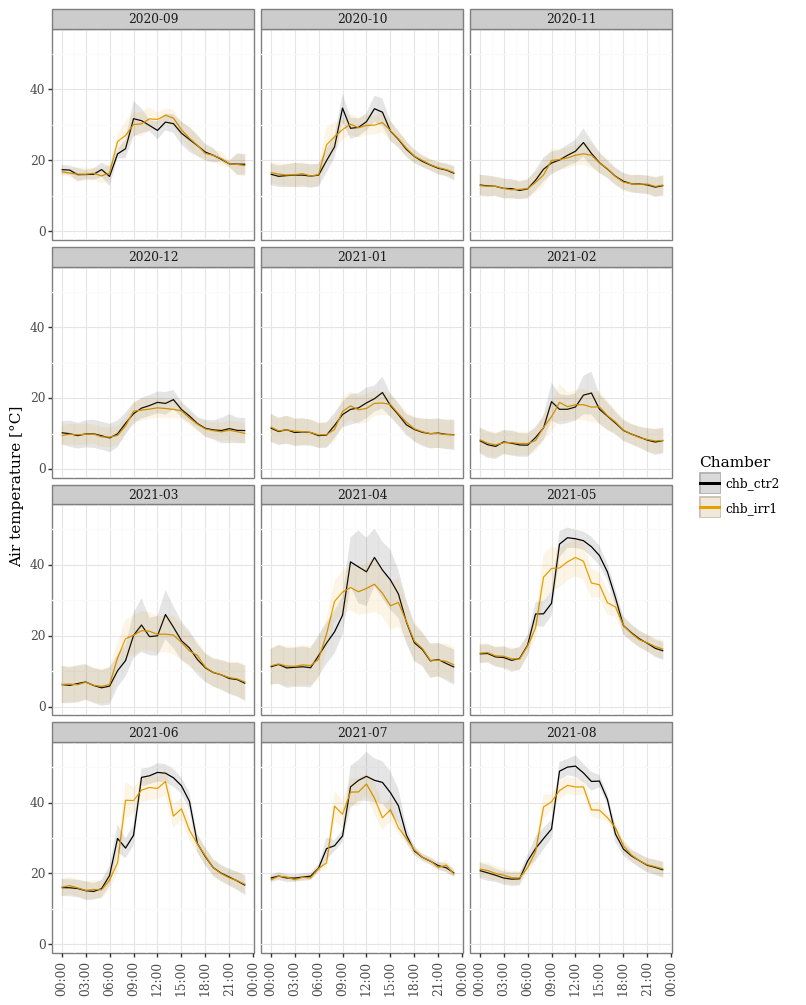

<ggplot: (148643533885)>


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 15.999999999999998 x 24.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/01c_diurnal_T_monthly.png


['chamber' 'time' 'month' 'conc_co_nmol_mol_mean'
 'conc_co_nmol_mol_median' 'conc_co_nmol_mol_std'
 'flux_co_ch_amb_proj_la_nmol_m2_s_mean'
 'flux_co_ch_amb_proj_la_nmol_m2_s_median'
 'flux_co_ch_amb_proj_la_nmol_m2_s_std'
 'flux_co_ch_oc_proj_la_nmol_m2_s_mean'
 'flux_co_ch_oc_proj_la_nmol_m2_s_median'
 'flux_co_ch_oc_proj_la_nmol_m2_s_std' 'flux_co_ch_amb_nmol_m2_s_mean'
 'flux_co_ch_amb_nmol_m2_s_median' 'flux_co_ch_amb_nmol_m2_s_std'
 'flux_co_ch_oc_nmol_m2_s_mean' 'flux_co_ch_oc_nmol_m2_s_median'
 'flux_co_ch_oc_nmol_m2_s_std' 'temp_leaf_current_chamber_c_mean'
 'temp_leaf_current_chamber_c_median' 'temp_leaf_current_chamber_c_std'
 'temp_air_current_chamber_c_mean' 'temp_air_current_chamber_c_median'
 'temp_air_current_chamber_c_std' 'par_ambient_umol_m2_s1_mean'
 'par_ambient_umol_m2_s1_median' 'par_ambient_umol_m2_s1_std'
 'par_current_chamber_umol_m2_s1_mean'
 'par_current_chamber_umol_m2_s1_median'
 'par_current_chamber_umol_m2_s1_std' 'VPD_Pa_mean' 'VPD_Pa_median'
 'VPD_Pa_

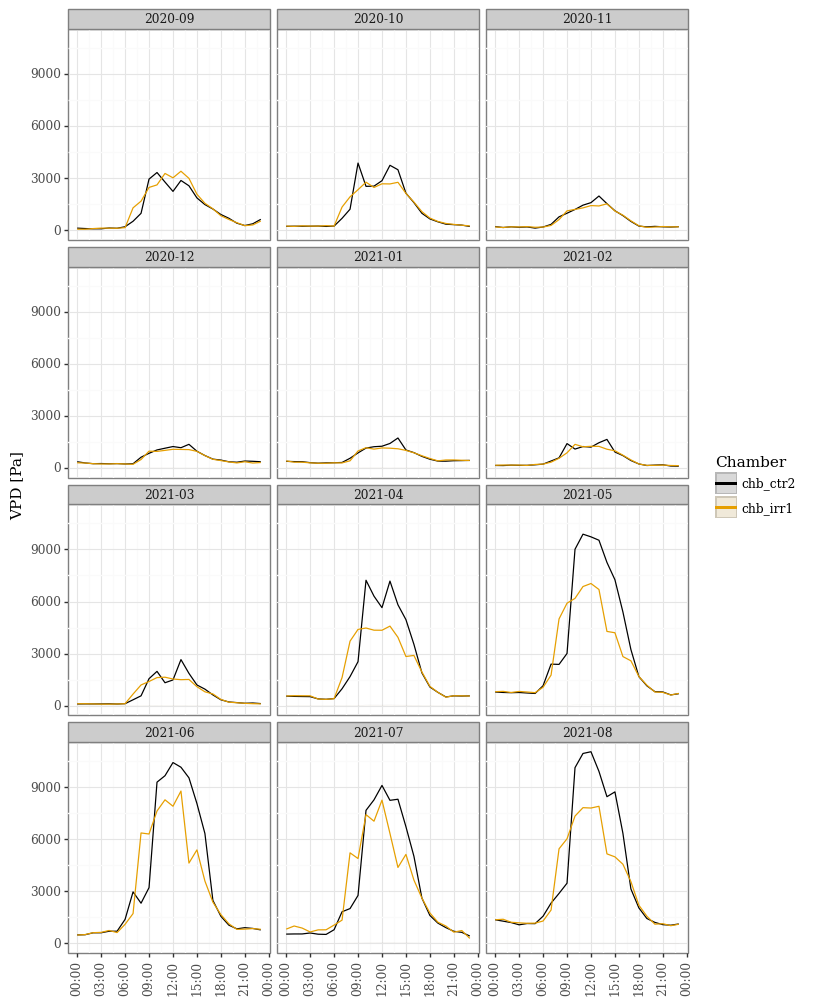

<ggplot: (148639818623)>


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 15.999999999999998 x 24.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/01d_diurnal_VPD_monthly.png


In [136]:
# Colours
cbPalette = ['#000000', '#E69F00', '#0072B2', '#CC00CC', '#009E73', '#D55E00', '#CC79A7', '#FF3300', '#F0E442', '#56B4E9']


# PAR
plt = ggplot(grouped)
plt = plt + geom_line(aes(x='timestamp', y='par_current_chamber_umol_m2_s1_median', colour='chamber'), size=0.5)
plt = plt + geom_ribbon(aes(x='timestamp', ymin='par_current_chamber_umol_m2_s1_median - par_current_chamber_umol_m2_s1_std', ymax='par_current_chamber_umol_m2_s1_median + par_current_chamber_umol_m2_s1_std', fill='chamber'), alpha=0.1)
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + labs(x='Time', y='PAR [$\mu mol~m^{-2}~s^{-1}$]', colour='Chamber', fill='Chamber')
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), axis_title_x = element_blank(),
                  text=element_text(family="serif"))
plt = plt + facet_wrap('~ month', ncol = 3)
plt = plt + theme(figure_size=(8, 12))
#plt = plt + coord_cartesian(ylim=[-1.0, 5.0])
plt = plt + scale_x_datetime(date_breaks = '3 hours', date_labels = '%H:%M')
print(plt)
plt.save(graphs_path + '01b_diurnal_PAR_monthly.png', width=1.6*10, height=1.6*15, units='cm', dpi=600)


# Air T
plt = ggplot(grouped)
plt = plt + geom_line(aes(x='timestamp', y='temp_air_current_chamber_c_median', colour='chamber'), size=0.5)
plt = plt + geom_ribbon(aes(x='timestamp', ymin='temp_air_current_chamber_c_median - temp_air_current_chamber_c_std', ymax='temp_air_current_chamber_c_median + temp_air_current_chamber_c_std', fill='chamber'), alpha=0.1)
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + labs(x='Time', y='Air temperature [°C]', colour='Chamber', fill='Chamber', parse=True)
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), axis_title_x = element_blank(),
                  text=element_text(family="serif"))
plt = plt + facet_wrap('~ month', ncol = 3)
plt = plt + theme(figure_size=(8, 12))
#plt = plt + coord_cartesian(ylim=[-1.0, 5.0])
plt = plt + scale_x_datetime(date_breaks = '3 hours', date_labels = '%H:%M')
print(plt)
plt.save(graphs_path + '01c_diurnal_T_monthly.png', width=1.6*10, height=1.6*15, units='cm', dpi=600)


# VPD
print(grouped.columns.values)
plt = ggplot(grouped)
plt = plt + geom_line(aes(x='timestamp', y='VPD_Pa_median', colour='chamber'), size=0.5)
plt = plt + geom_ribbon(aes(x='timestamp', ymin='temp_air_current_chamber_c_median - temp_air_current_chamber_c_std', ymax='temp_air_current_chamber_c_median + temp_air_current_chamber_c_std', fill='chamber'), alpha=0.1)
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + labs(x='Time', y='VPD [Pa]', colour='Chamber', fill='Chamber', parse=True)
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), axis_title_x = element_blank(),
                  text=element_text(family="serif"))
plt = plt + facet_wrap('~ month', ncol = 3)
plt = plt + theme(figure_size=(8, 12))
#plt = plt + coord_cartesian(ylim=[-1.0, 5.0])
plt = plt + scale_x_datetime(date_breaks = '3 hours', date_labels = '%H:%M')
print(plt)
plt.save(graphs_path + '01d_diurnal_VPD_monthly.png', width=1.6*10, height=1.6*15, units='cm', dpi=600)

In [126]:
temp = df.loc[df['status'] == 'cc', ['timestamp', 'treatment', 'chamber','conc.co.nmol_mol',
                                     'flux.co.ch_amb.nmol_m2_s', 'flux.co.ch_oc.nmol_m2_s',
                                     'flux.co.ch_amb.nmol_m2_s', 'flux.co.ch_oc.nmol_m2_s',
                                     'temp.leaf.current.chamber.c', 'temp.air.current.chamber.c',
                                     'par.ambient.umol_m2_s1', 'par.current.chamber.umol_m2_s1']]
temp = temp.loc[(temp['timestamp'] >= '2020-09-01 00:00') & (temp['timestamp'] < '2021-09-01 00:00')]
temp['day'] = temp['timestamp'].dt.strftime('%Y-%m-%d')

# Function to filter data points outside 75% quartile
def filter_quartile(group):
    q75 = group['flux.co.ch_oc.nmol_m2_s'].quantile(0.95)
    return group[group['flux.co.ch_oc.nmol_m2_s'] <= q75]

# Group by 'Category' and apply the filter
filtered_df = temp.groupby(['day','chamber']).apply(filter_quartile)

# Reset the index of the filtered DataFrame
filtered_df.reset_index(drop=True, inplace=True)

#display(filtered_df)

C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


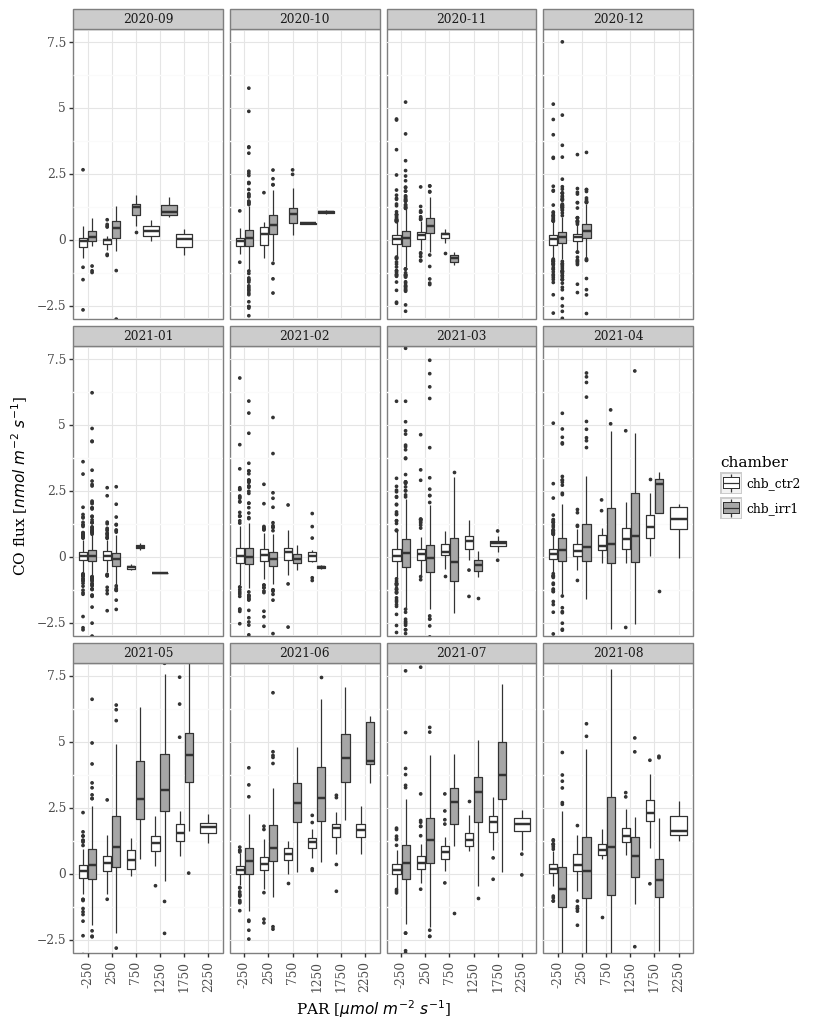

<ggplot: (148640166370)>


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 15.999999999999998 x 24.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/01e_CO_PAR_monthly.png
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


In [139]:
cbPalette = ["#ffffff", "#a6a6a6"]

temp = df.loc[df['status'] == 'cc', ['timestamp', 'treatment', 'chamber','conc.co.nmol_mol',
                                     'flux.co.ch_amb.nmol_m2_s', 'flux.co.ch_oc.nmol_m2_s',
                                     'flux.co.ch_amb.nmol_m2_s', 'flux.co.ch_oc.nmol_m2_s',
                                     'temp.leaf.current.chamber.c', 'temp.air.current.chamber.c',
                                     'par.ambient.umol_m2_s1', 'par.current.chamber.umol_m2_s1']]
temp = temp.loc[(temp['timestamp'] >= '2020-09-01 00:00') & (temp['timestamp'] < '2021-09-01 00:00')]
temp = temp.loc[temp['chamber'].isin(['chb_irr1','chb_ctr2'])]

temp.dropna(subset=['flux.co.ch_oc.nmol_m2_s','par.current.chamber.umol_m2_s1'], inplace=True)
temp['bins_par'] = bin_variable(temp['par.current.chamber.umol_m2_s1'], 500)

temp['time']  = temp['timestamp'].dt.strftime('%H:%M')
temp['month'] = temp['timestamp'].dt.strftime('%Y-%m')

plt = ggplot(temp)
plt = plt + theme_bw()
plt = plt + geom_boxplot(aes(x='bins_par', y='flux.co.ch_oc.nmol_m2_s', fill='chamber'), outlier_size=0.5)
plt = plt + labs(x='PAR [$\mu mol~m^{-2}~s^{-1}$]', y='CO flux [$nmol~m^{-2}~s^{-1}$]', parse=True)
plt = plt + facet_wrap(['month'])
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), #axis_title_x = element_blank(),
                  text=element_text(family="serif"))
#plt = plt + theme(legend_position = 'top')
plt = plt + theme(figure_size=(8, 12))
plt = plt + coord_cartesian(ylim=[-2.5, 7.5])
print(plt)
plt.save(graphs_path + '01e_CO_PAR_monthly.png', width=1.6*10, height=1.6*15, units='cm', dpi=600)

C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


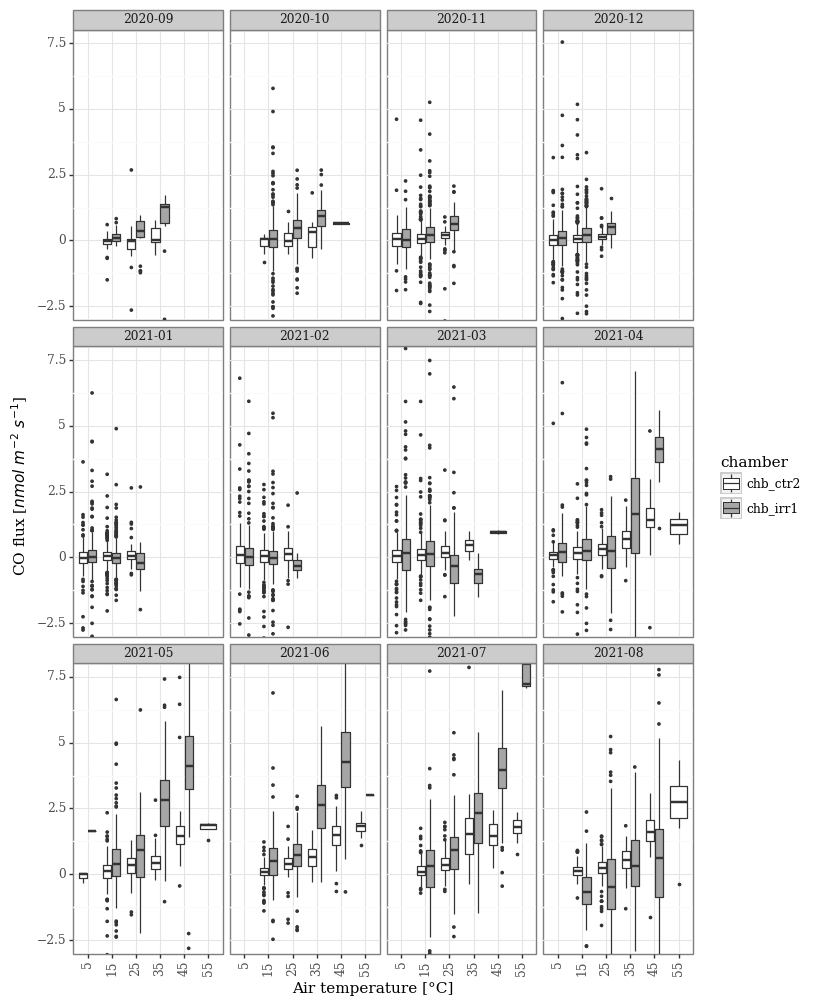

<ggplot: (148644556156)>


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 15.999999999999998 x 24.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/01f_CO_T_monthly.png
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


In [138]:
cbPalette = ["#ffffff", "#a6a6a6"]

temp = df.loc[df['status'] == 'cc', ['timestamp', 'treatment', 'chamber','conc.co.nmol_mol',
                                     'flux.co.ch_amb.nmol_m2_s', 'flux.co.ch_oc.nmol_m2_s',
                                     'flux.co.ch_amb.nmol_m2_s', 'flux.co.ch_oc.nmol_m2_s',
                                     'temp.leaf.current.chamber.c', 'temp.air.current.chamber.c',
                                     'par.ambient.umol_m2_s1', 'par.current.chamber.umol_m2_s1']]
temp = temp.loc[(temp['timestamp'] >= '2020-09-01 00:00') & (temp['timestamp'] < '2021-09-01 00:00')]
temp = temp.loc[temp['chamber'].isin(['chb_irr1','chb_ctr2'])]

temp.dropna(subset=['flux.co.ch_oc.nmol_m2_s','temp.air.current.chamber.c'], inplace=True)
temp['bins_t'] = bin_variable(temp['temp.air.current.chamber.c'], 10)

temp['time']  = temp['timestamp'].dt.strftime('%H:%M')
temp['month'] = temp['timestamp'].dt.strftime('%Y-%m')

plt = ggplot(temp)
plt = plt + theme_bw()
plt = plt + geom_boxplot(aes(x='bins_t', y='flux.co.ch_oc.nmol_m2_s', fill='chamber'), outlier_size=0.5)
plt = plt + labs(x='Air temperature [°C]', y='CO flux [$nmol~m^{-2}~s^{-1}$]', parse=True)
plt = plt + facet_wrap(['month'])
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), #axis_title_x = element_blank(),
                  text=element_text(family="serif"))
#plt = plt + theme(legend_position = 'top')
plt = plt + theme(figure_size=(8, 12))
plt = plt + coord_cartesian(ylim=[-2.5, 7.5])
print(plt)
plt.save(graphs_path + '01f_CO_T_monthly.png', width=1.6*10, height=1.6*15, units='cm', dpi=600)

C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


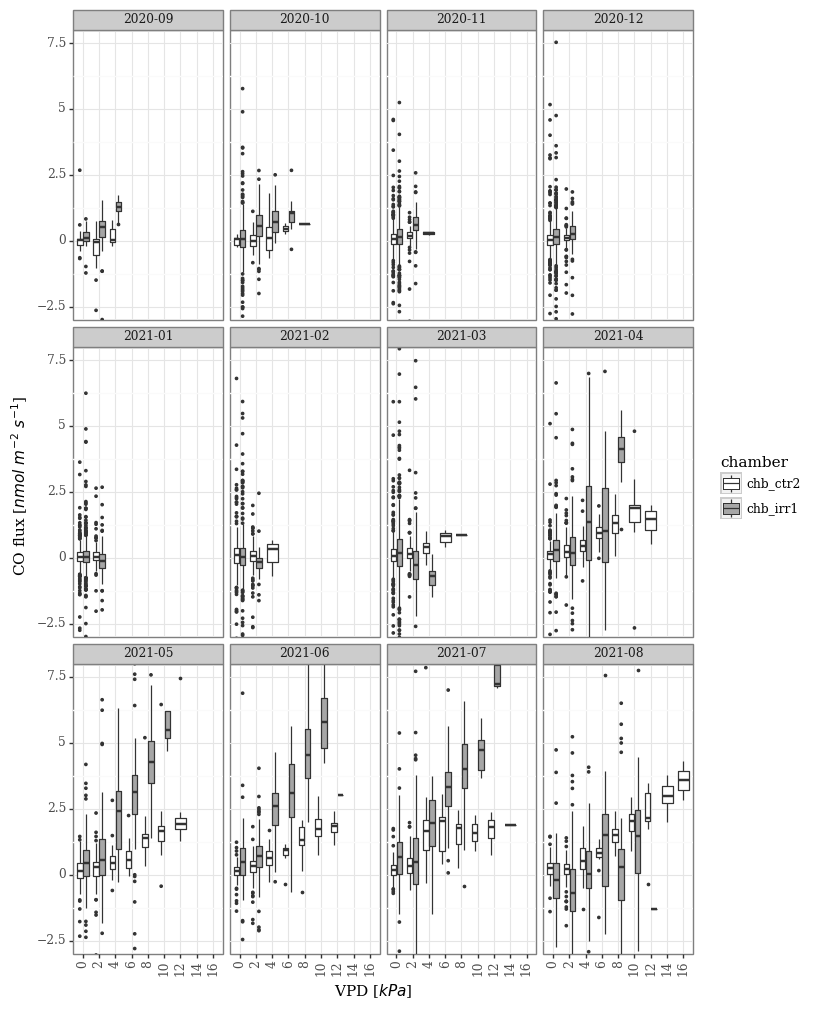

<ggplot: (148643457639)>


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 15.999999999999998 x 24.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/01g_CO_VPD_monthly.png
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


In [134]:
cbPalette = ["#ffffff", "#a6a6a6"]

temp = df.loc[df['status'] == 'cc', ['timestamp', 'treatment', 'chamber','conc.co.nmol_mol',
                                     'flux.co.ch_amb.nmol_m2_s', 'flux.co.ch_oc.nmol_m2_s',
                                     'flux.co.ch_amb.nmol_m2_s', 'flux.co.ch_oc.nmol_m2_s',
                                     'temp.leaf.current.chamber.c', 'temp.air.current.chamber.c',
                                     'par.ambient.umol_m2_s1', 'par.current.chamber.umol_m2_s1','VPD.Pa']]
temp = temp.loc[(temp['timestamp'] >= '2020-09-01 00:00') & (temp['timestamp'] < '2021-09-01 00:00')]
temp = temp.loc[temp['chamber'].isin(['chb_irr1','chb_ctr2'])]
temp['VPD.kPa'] = temp['VPD.Pa']/1000

temp.dropna(subset=['flux.co.ch_oc.nmol_m2_s','VPD.kPa'], inplace=True)
temp['bins_vpd'] = bin_variable(temp['VPD.kPa'], 2)

temp['time']  = temp['timestamp'].dt.strftime('%H:%M')
temp['month'] = temp['timestamp'].dt.strftime('%Y-%m')

plt = ggplot(temp)
plt = plt + theme_bw()
plt = plt + geom_boxplot(aes(x='bins_vpd', y='flux.co.ch_oc.nmol_m2_s', fill='chamber'), outlier_size=0.5)
plt = plt + labs(x='VPD [$kPa$]', y='CO flux [$nmol~m^{-2}~s^{-1}$]', parse=True)
plt = plt + facet_wrap(['month'])
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), #axis_title_x = element_blank(),
                  text=element_text(family="serif"))
#plt = plt + theme(legend_position = 'top')
plt = plt + theme(figure_size=(8, 12))
plt = plt + coord_cartesian(ylim=[-2.5, 7.5])
print(plt)
plt.save(graphs_path + '01g_CO_VPD_monthly.png', width=1.6*10, height=1.6*15, units='cm', dpi=600)

C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


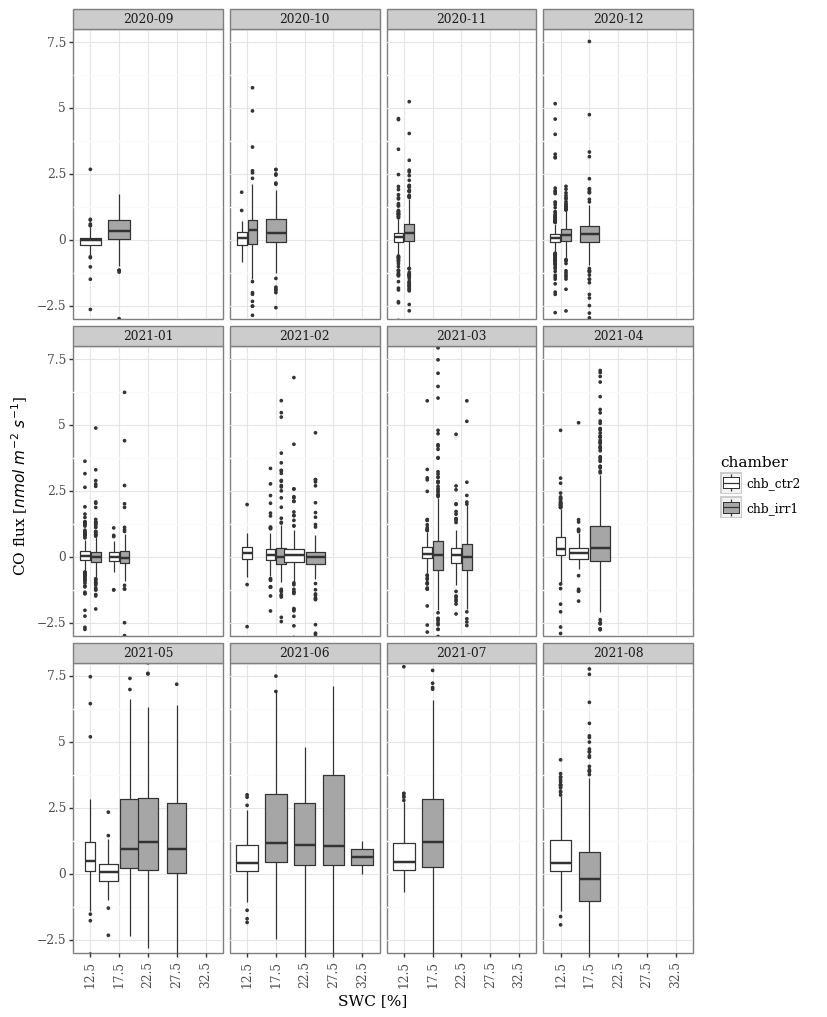

<ggplot: (153841898981)>


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 15.999999999999998 x 24.0 cm image.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../graphs/01h_CO_SWC_monthly.png
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


In [39]:
cbPalette = ["#ffffff", "#a6a6a6"]

temp = df.loc[df['status'] == 'cc', ['timestamp', 'treatment', 'chamber','conc.co.nmol_mol',
                                     'flux.co.ch_amb.nmol_m2_s', 'flux.co.ch_oc.nmol_m2_s',
                                     'flux.co.ch_amb.nmol_m2_s', 'flux.co.ch_oc.nmol_m2_s',
                                     'temp.leaf.current.chamber.c', 'temp.air.current.chamber.c',
                                     'par.ambient.umol_m2_s1', 'par.current.chamber.umol_m2_s1', 'swc_40cm']]
temp = temp.loc[(temp['timestamp'] >= '2020-09-01 00:00') & (temp['timestamp'] < '2021-09-01 00:00')]
temp = temp.loc[temp['chamber'].isin(['chb_irr1','chb_ctr2'])]

temp.dropna(subset=['flux.co.ch_oc.nmol_m2_s','swc_40cm'], inplace=True)
temp['bins_swc'] = bin_variable(temp['swc_40cm'], 5)

temp['time']  = temp['timestamp'].dt.strftime('%H:%M')
temp['month'] = temp['timestamp'].dt.strftime('%Y-%m')

plt = ggplot(temp)
plt = plt + theme_bw()
plt = plt + geom_boxplot(aes(x='bins_swc', y='flux.co.ch_oc.nmol_m2_s', fill='chamber'), outlier_size=0.5)
plt = plt + labs(x='SWC [%]', y='CO flux [$nmol~m^{-2}~s^{-1}$]', parse=True)
plt = plt + facet_wrap(['month'])
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), #axis_title_x = element_blank(),
                  text=element_text(family="serif"))
#plt = plt + theme(legend_position = 'top')
plt = plt + theme(figure_size=(8, 12))
plt = plt + coord_cartesian(ylim=[-2.5, 7.5])
print(plt)
plt.save(graphs_path + '01h_CO_SWC_monthly.png', width=1.6*10, height=1.6*15, units='cm', dpi=600)

In [ ]:
temp = df.loc[(df['status'] == 'cc'), ['timestamp', 'treatment', 'flux.co.ch_amb.nmol_m2_s', 'flux.co.ch_oc.nmol_m2_s',\
                                       'flux.co.ch_amb.nmol_m2_s','flux.co.ch_oc.nmol_m2_s']]
display(temp)

# Resample to half hours
temp_30min = temp.groupby(['treatment']).resample('1h', on='timestamp').mean()
temp_30min.reset_index(inplace=True)
#temp.groupby(['treatment','month'])
display(temp_30min)

array(['plot', 'timestamp', 'flux.co.ch_amb.nmol_m2_s',
       'flux.co.ch_oc.nmol_m2_s', 'flux.co.ch_amb.proj_la.nmol_m2_s',
       'flux.co.ch_oc.proj_la.nmol_m2_s', 'time', 'month'], dtype=object)

<ipython-input-11-0540440ace44>:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


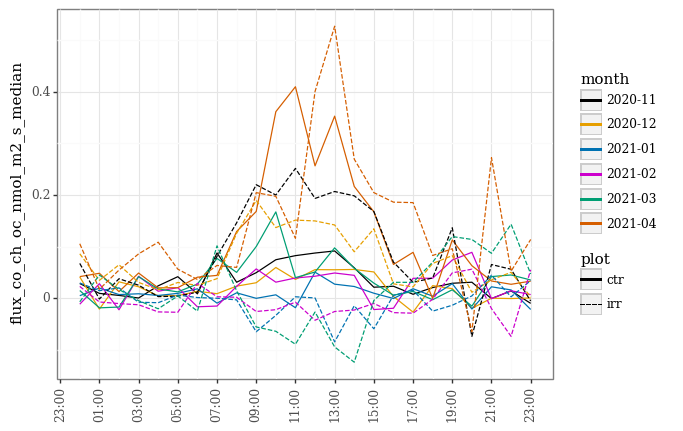

<ggplot: (186906850913)>


In [11]:
from plotnine import *
# Colours
cbPalette = ['#000000', '#E69F00', '#0072B2', '#CC00CC', '#009E73', '#D55E00', '#CC79A7', '#FF3300', '#F0E442', '#56B4E9']

temp_30min['time'] = temp_30min['timestamp'].dt.strftime('%H:%M')
temp_30min['month'] = temp_30min['timestamp'].dt.strftime('%Y-%m')

# Averaging
grouped = temp_30min.groupby(['month','time','treatment']).agg(['mean','median','std'])
# Reset index and rename columns
grouped = grouped.reset_index()
grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns.values]

grouped['timestamp'] = pd.to_datetime(grouped['time'], utc=True)
grouped.columns = grouped.columns.str.replace(".", "_")

# Plot the diurnal
plt = ggplot(grouped)
plt = plt + geom_line(aes(x='timestamp', y='flux_co_ch_oc_nmol_m2_s_median', colour='month', linetype='treatment'), size=0.5)
#plt = plt + geom_ribbon(aes(x='timestamp', ymin='flux_co_ch_oc_nmol_m2_s_median - flux_co_ch_oc_nmol_m2_s_std', ymax='flux_co_ch_oc_nmol_m2_s_median + flux_co_ch_oc_nmol_m2_s_std', fill='month'), alpha=0.1)
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), axis_title_x = element_blank(),
                  text=element_text(family="serif"))
plt = plt + scale_x_datetime(date_breaks = '2 hours', date_labels = '%H:%M')
print(plt)

C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


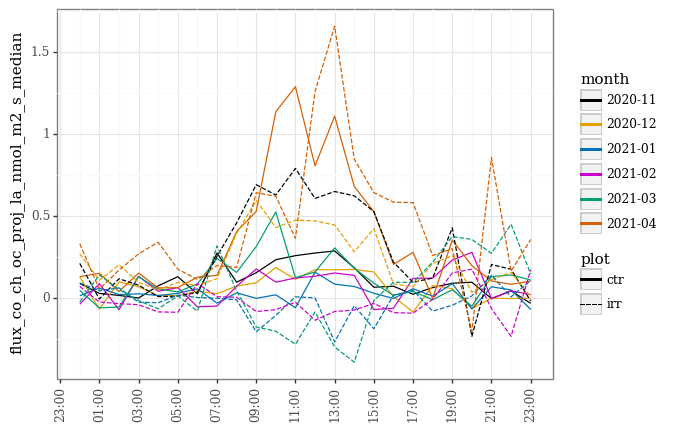

<ggplot: (186907071380)>


In [12]:
# Plot the diurnal
plt = ggplot(grouped)
plt = plt + geom_line(aes(x='timestamp', y='flux_co_ch_oc_proj_la_nmol_m2_s_median', colour='month', linetype='treatment'), size=0.5)
#plt = plt + geom_ribbon(aes(x='timestamp', ymin='flux_co_ch_oc_nmol_m2_s_median - flux_co_ch_oc_nmol_m2_s_std', ymax='flux_co_ch_oc_nmol_m2_s_median + flux_co_ch_oc_nmol_m2_s_std', fill='month'), alpha=0.1)
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), axis_title_x = element_blank(),
                  text=element_text(family="serif"))
plt = plt + scale_x_datetime(date_breaks = '2 hours', date_labels = '%H:%M')
print(plt)

array(['month', 'time', 'plot', 'flux_co_ch_amb_nmol_m2_s_mean',
       'flux_co_ch_amb_nmol_m2_s_median', 'flux_co_ch_amb_nmol_m2_s_std',
       'flux_co_ch_oc_nmol_m2_s_mean', 'flux_co_ch_oc_nmol_m2_s_median',
       'flux_co_ch_oc_nmol_m2_s_std',
       'flux_co_ch_amb_proj_la_nmol_m2_s_mean',
       'flux_co_ch_amb_proj_la_nmol_m2_s_median',
       'flux_co_ch_amb_proj_la_nmol_m2_s_std',
       'flux_co_ch_oc_proj_la_nmol_m2_s_mean',
       'flux_co_ch_oc_proj_la_nmol_m2_s_median',
       'flux_co_ch_oc_proj_la_nmol_m2_s_std', 'timestamp'], dtype=object)

C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


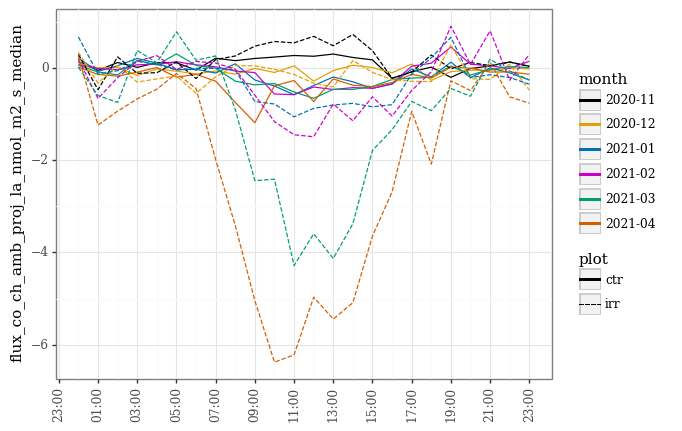

<ggplot: (186907125035)>


In [13]:
display(grouped.columns.values)

# Plot the diurnal
plt = ggplot(grouped)
plt = plt + geom_line(aes(x='timestamp', y='flux_co_ch_amb_proj_la_nmol_m2_s_median', colour='month', linetype='treatment'), size=0.5)
#plt = plt + geom_ribbon(aes(x='timestamp', ymin='flux_co_ch_oc_nmol_m2_s_median - flux_co_ch_oc_nmol_m2_s_std', ymax='flux_co_ch_oc_nmol_m2_s_median + flux_co_ch_oc_nmol_m2_s_std', fill='month'), alpha=0.1)
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(rotation = 90, hjust=0.5), axis_title_x = element_blank(),
                  text=element_text(family="serif"))
plt = plt + scale_x_datetime(date_breaks = '2 hours', date_labels = '%H:%M')
print(plt)

# Emission of CO in november! Absorption in Jan-Apr